In [1]:
%load_ext autoreload
%load_ext autotime

time: 215 µs (started: 2024-12-12 21:23:11 -08:00)


In [2]:
import numpy as np
import os
import pandas as pd
import sys
import time
import warnings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 1.19 s (started: 2024-12-12 21:23:12 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46185"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.51 ms (started: 2024-12-12 21:23:13 -08:00)


In [4]:
# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-deepspeed-dlio-scr-step100-node-16"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-deepspeed-dlio-scr-step100-node-16"
logical_view_types = False
output_max_bottlenecks = 1
output_root_only = False
percentile = 0.9
run_dir = ".wisio/dftracer/deepspeed-dlio-scr-step100-node-16"
# trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.6-develop/corona/megatron-deepspeed/dlio-scr-step100/node-16/v1/COMPACT/*.pfw.gz"
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.6-develop/corona/megatron-deepspeed/dlio-scr-step100/node-16/v1/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]


time: 1.35 ms (started: 2024-12-12 21:23:13 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.constants import Layer
from wisio.plots import plot_bottleneck_summary
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={65e6}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 2.97 s (started: 2024-12-12 21:23:14 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 5.84 ms (started: 2024-12-12 21:23:17 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=0 threads=0, memory=0 B>

time: 3.49 s (started: 2024-12-12 21:23:17 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 13min 3s (started: 2024-12-12 21:23:20 -08:00)


In [9]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 586 µs (started: 2024-12-12 21:36:24 -08:00)


In [10]:
checkpoint_dir

'/p/lustre3/iopp/wisio-checkpoints/dftracer-deepspeed-dlio-scr-step100-node-16'

time: 1.94 ms (started: 2024-12-12 21:36:24 -08:00)


In [11]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 33.5 s (started: 2024-12-12 21:36:24 -08:00)


In [12]:
import dask.dataframe as dd

ddf = dd.read_parquet(f"{checkpoint_dir}/_traces")
ddf

Dask DataFrame Structure:
                    cat             time            epoch           level func_name              pid             step               te              tid       time_range               ts            type        tinterval         image_id          io_cat            phase             size     compute_time  checkpoint_time        read_time             hash   value file_name host_name acc_pat  count proc_name
npartitions=263                                                                                                                                                                                                                                                                                                                                                                                                       
                 string  double[pyarrow]  uint64[pyarrow]  uint8[pyarrow]    string  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  string    string    string   int64  int64    object
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...
...                 ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...
Dask Name: read-parquet, 1 graph layer

time: 60.5 ms (started: 2024-12-12 22:04:57 -08:00)


In [13]:
ddf.memory_usage(deep=True).sum().compute() / 1024**3

75.63941041566432

time: 22.7 s (started: 2024-12-12 22:04:58 -08:00)


In [22]:
len(ddf)

128135449

time: 5.07 s (started: 2024-12-12 15:11:25 -08:00)


In [24]:
ddf[ddf['file_name'].str.contains('/ssd')].head()

cat      time  epoch  level func_name     pid  step          te     tid  \
0  POSIX  0.000001   <NA>      1     lseek  995356  <NA>  1540455119  995356   
1  POSIX  0.001164   <NA>      1      read  995356  <NA>  1540456291  995356   
2  POSIX  0.000001   <NA>      1     lseek  995356  <NA>  1540456302  995356   
3  POSIX  0.000002   <NA>      1     lseek  995356  <NA>  1540478479  995356   
4  POSIX  0.001826   <NA>      1      read  995356  <NA>  1540480316  995356   

   time_range  ...  compute_time  checkpoint_time  read_time  hash  value  \
0          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
1          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
2          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
3          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
4          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   

                                           file_name  host_name  acc_pat  \
0  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
1  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
2  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
3  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
4  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   

   count                    proc_name  
0      1  app#corona200#995356#995356  
1      1  app#corona200#995356#995356  
2      1  app#corona200#995356#995356  
3      1  app#corona200#995356#995356  
4      1  app#corona200#995356#995356  

[5 rows x 27 columns]

time: 1.15 s (started: 2024-12-12 15:13:52 -08:00)


In [29]:
ddf.head()[['file_name']]

file_name
0  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
1  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
3  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
4  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...

time: 365 ms (started: 2024-12-12 15:17:46 -08:00)


In [16]:
import os


def set_file_dir(df):
    return df.assign(
        file_dir=df['file_name'].fillna('').map(os.path.dirname).astype("string[pyarrow]"),
    )

time: 895 µs (started: 2024-12-12 16:03:09 -08:00)


In [17]:
traces.head()

cat      time  epoch  level func_name     pid  step          te     tid  \
0  POSIX  0.000001   <NA>      1     lseek  995356  <NA>  1540455119  995356   
1  POSIX  0.001164   <NA>      1      read  995356  <NA>  1540456291  995356   
2  POSIX  0.000001   <NA>      1     lseek  995356  <NA>  1540456302  995356   
3  POSIX  0.000002   <NA>      1     lseek  995356  <NA>  1540478479  995356   
4  POSIX  0.001826   <NA>      1      read  995356  <NA>  1540480316  995356   

   time_range  ...  compute_time  checkpoint_time  read_time  hash  value  \
0          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
1          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
2          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
3          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   
4          23  ...          <NA>             <NA>       <NA>  <NA>   <NA>   

                                           file_name  host_name  acc_pat  \
0  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
1  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
2  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
3  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   
4  /l/ssd/haridev/scr/checkpoints/scr_megatron_de...  corona200        0   

   count                    proc_name  
0      1  app#corona200#995356#995356  
1      1  app#corona200#995356#995356  
2      1  app#corona200#995356#995356  
3      1  app#corona200#995356#995356  
4      1  app#corona200#995356#995356  

[5 rows x 27 columns]

time: 2.95 s (started: 2024-12-12 15:00:30 -08:00)


In [14]:
flat_views[('time_range',)].sort_index().to_csv('dlio_scr_step100_time_range.csv')

time: 118 ms (started: 2024-12-12 22:05:21 -08:00)


In [15]:
flat_views[('proc_name',)].sort_index().to_csv('dlio_scr_step100_proc_name.csv')

time: 17.9 s (started: 2024-12-12 22:05:21 -08:00)


In [16]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('dlio_scr_step100_host_name.csv')

time: 45.7 ms (started: 2024-12-12 22:05:39 -08:00)


In [17]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('dlio_scr_step100_proc_id.csv')

time: 84.2 ms (started: 2024-12-12 22:05:39 -08:00)


In [48]:
traces['image_id'].nunique().compute()

6156286

time: 23.5 s (started: 2024-12-07 00:16:23 -08:00)


In [22]:
traces['proc_name'].nunique().compute()

31232

time: 22.9 s (started: 2024-12-06 23:44:43 -08:00)


In [13]:
traces['file_name'].nunique().compute()

484081

time: 25.1 s (started: 2024-12-11 08:24:22 -08:00)


In [15]:
traces.query('file_name.str.contains("lustre")')['file_name'].nunique().compute()

28935

time: 25 s (started: 2024-12-11 08:26:36 -08:00)


In [14]:
traces.query('file_name.str.contains("ssd")')['file_name'].nunique().compute()

48182

time: 26.3 s (started: 2024-12-11 08:25:59 -08:00)


In [18]:
flat_views[('time_range',)].query('compute_time > 0').sort_index().head()

checkpoint_bw  checkpoint_bw_score  checkpoint_compute_per  \
time_range                                                               
3                    <NA>                 <NA>                    <NA>   
4                    <NA>                 <NA>                    <NA>   
5                    <NA>                 <NA>                    <NA>   
6                    <NA>                 <NA>                    <NA>   
7                    <NA>                 <NA>                    <NA>   

            checkpoint_compute_per_score  checkpoint_count  \
time_range                                                   
3                                   <NA>               NaN   
4                                   <NA>               NaN   
5                                   <NA>               NaN   
6                                   <NA>               NaN   
7                                   <NA>               NaN   

            checkpoint_count_per  checkpoint_count_per_score  \
time_range                                                     
3                            NaN                        <NA>   
4                            NaN                        <NA>   
5                            NaN                        <NA>   
6                            NaN                        <NA>   
7                            NaN                        <NA>   

            checkpoint_intensity  checkpoint_intensity_score  checkpoint_ops  \
time_range                                                                     
3                           <NA>                        <NA>             NaN   
4                           <NA>                        <NA>             NaN   
5                           <NA>                        <NA>             NaN   
6                           <NA>                        <NA>             NaN   
7                           <NA>                        <NA>             NaN   

            ...  u_reader_sample_time  u_reader_sample_time_norm  \
time_range  ...                                                    
3           ...                   0.0                        0.0   
4           ...                   0.0                        0.0   
5           ...                   0.0                        0.0   
6           ...                   0.0                        0.0   
7           ...                   0.0                        0.0   

            u_reader_sample_time_norm_score  u_reader_sample_time_per  \
time_range                                                              
3                                         0                       NaN   
4                                         0                       NaN   
5                                         0                       NaN   
6                                         0                       NaN   
7                                         0                       NaN   

            u_reader_sample_time_per_score  u_reader_time  u_reader_time_norm  \
time_range                                                                      
3                                     <NA>            0.0                 0.0   
4                                     <NA>            0.0                 0.0   
5                                     <NA>            0.0                 0.0   
6                                     <NA>            0.0                 0.0   
7                                     <NA>            0.0                 0.0   

            u_reader_time_norm_score  u_reader_time_per  \
time_range                                                
3                                  0                NaN   
4                                  0                NaN   
5                                  0                NaN   
6                                  0                NaN   
7                                  0                NaN   

            u_reader_time_per_score  
time_range                           
3

time: 475 ms (started: 2024-12-12 17:06:09 -08:00)



Mapping Back Top PCA Components to Original Features:

PC4 - Feature Importance: 0.5979
posix_close_count_per_score     0.277333
posix_open_count_per_score      0.277333
posix_pctl_time_norm_score      0.273061
u_posix_pctl_time_norm_score    0.273061
posix_stat_count_per_score      0.269894
Name: PC4, dtype: float64

PC3 - Feature Importance: 0.3186
checkpoint_compute_per_score    0.248003
checkpoint_ops_rank_score       0.242703
checkpoint_time_per_score       0.241680
checkpoint_time_norm_score      0.240546
checkpoint_count_per_score      0.230892
Name: PC3, dtype: float64

PC8 - Feature Importance: 0.0426
u_posix_other_time_norm_score    0.269209
u_posix_other_time_per_score     0.257675
posix_other_time_per_score       0.252846
posix_stat_time_per_score        0.215649
posix_other_count_per_score      0.205693
Name: PC8, dtype: float64

PC10 - Feature Importance: 0.0105
u_posix_read_lustre_time_norm_score    0.237992
u_posix_other_time_per_score           0.224648
posix_other_ti

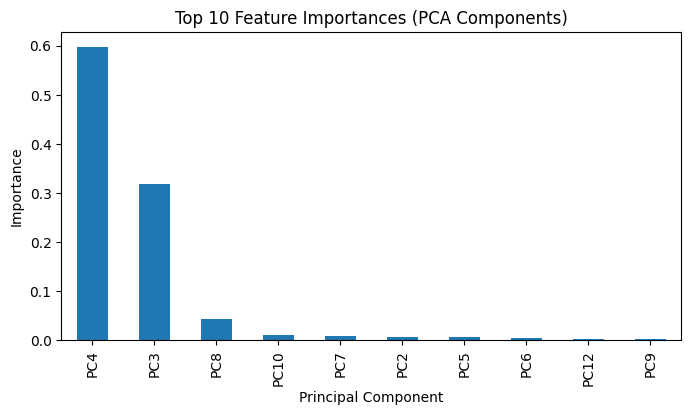

time: 527 ms (started: 2024-12-12 17:20:20 -08:00)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col and not col.startswith('d_')]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target]).fillna(0)  # All columns except the target
y = df[target].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 95% of variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Note: PCA transforms features, so feature names are lost. Use "PC1", "PC2", etc.
n_components = X_pca.shape[1]
feature_names = [f'PC{i + 1}' for i in range(n_components)]

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Display top components
# print("Feature Importances (Random Forest on PCA Components):")
# print(feature_importances)

# Create a DataFrame for PCA components
components = pd.DataFrame(
    pca.components_, 
    columns=X.columns, 
    index=[f'PC{i + 1}' for i in range(pca.n_components_)]
)

# Display top contributing features for each principal component
# for pc in components.index:
#     print(f"\n{pc} - Top Contributing Features:")
#     print(components.loc[pc].sort_values(ascending=False).head())

# Extract feature importances from Random Forest
feature_importances = pd.Series(rf.feature_importances_, index=components.index).sort_values(ascending=False)

# Map back top PCA components to original features
print("\nMapping Back Top PCA Components to Original Features:")
for component in feature_importances.head(5).index:  # Top 5 PCA components
    print(f"\n{component} - Feature Importance: {feature_importances[component]:.4f}")
    print(components.loc[component].sort_values(ascending=False).head())

# Plot feature importances
plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (PCA Components)')
plt.ylabel('Importance')
plt.xlabel('Principal Component')
plt.show()



Mapping Back Top PCA Components to Original Features:

PC2 - Feature Importance: 0.4494
posix_compute_per_score       0.211641
posix_write_time_per_score    0.200768
posix_bw_score                0.195039
posix_time_per_score          0.191989
posix_write_bw_score          0.189234
Name: PC2, dtype: float64

PC3 - Feature Importance: 0.3142
posix_other_count_per_score       0.234614
posix_stat_count_per_score        0.229743
posix_stat_time_per_score         0.218956
posix_metadata_time_norm_score    0.210602
u_posix_other_time_norm_score     0.210602
Name: PC3, dtype: float64

PC5 - Feature Importance: 0.1838
checkpoint_time_per_score       0.240702
checkpoint_time_norm_score      0.235704
checkpoint_count_per_score      0.221820
checkpoint_ops_rank_score       0.204715
checkpoint_compute_per_score    0.201235
Name: PC5, dtype: float64

PC9 - Feature Importance: 0.0114
posix_metadata_count_per_score    0.374647
reader_time_per_score             0.314504
reader_sample_time_per_score  

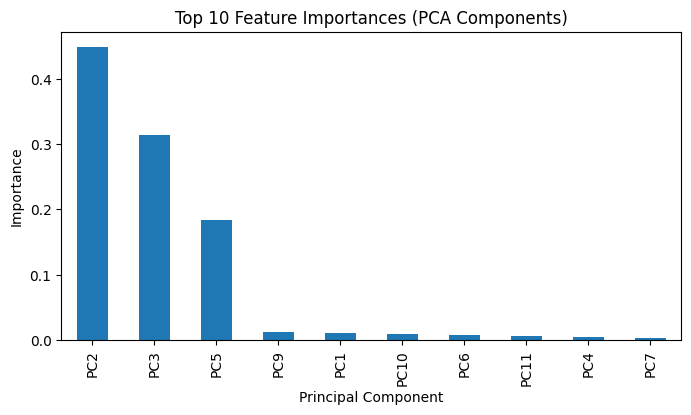

time: 582 ms (started: 2024-12-12 17:20:25 -08:00)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('dlio_scr_opt_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col and not col.startswith('d_')]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target]).fillna(0)  # All columns except the target
y = df[target].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 95% of variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Note: PCA transforms features, so feature names are lost. Use "PC1", "PC2", etc.
n_components = X_pca.shape[1]
feature_names = [f'PC{i + 1}' for i in range(n_components)]

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Display top components
# print("Feature Importances (Random Forest on PCA Components):")
# print(feature_importances)

# Create a DataFrame for PCA components
components = pd.DataFrame(
    pca.components_, 
    columns=X.columns, 
    index=[f'PC{i + 1}' for i in range(pca.n_components_)]
)

# Display top contributing features for each principal component
# for pc in components.index:
#     print(f"\n{pc} - Top Contributing Features:")
#     print(components.loc[pc].sort_values(ascending=False).head())

# Extract feature importances from Random Forest
feature_importances = pd.Series(rf.feature_importances_, index=components.index).sort_values(ascending=False)

# Map back top PCA components to original features
print("\nMapping Back Top PCA Components to Original Features:")
for component in feature_importances.head(5).index:  # Top 5 PCA components
    print(f"\n{component} - Feature Importance: {feature_importances[component]:.4f}")
    print(components.loc[component].sort_values(ascending=False).head())

# Plot feature importances
plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (PCA Components)')
plt.ylabel('Importance')
plt.xlabel('Principal Component')
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (with PCA):", mse)


Mean Squared Error (with PCA): 0.0803346153846154
time: 7.71 ms (started: 2024-12-12 17:20:29 -08:00)


In [23]:
# Predict and calculate MSE without PCA
y_pred_original = rf.predict(X_test)  # Replace with the original untransformed X_test
mse_original = mean_squared_error(y_test, y_pred_original)
print("Mean Squared Error (without PCA):", mse_original)


Mean Squared Error (without PCA): 0.0803346153846154
time: 7.51 ms (started: 2024-12-12 17:20:30 -08:00)


In [26]:
flat_views[('time_range',)][['compute_time', 'checkpoint_time', 'dataloader_time', 'image_time', 'reader_time', 'posix_time']]

compute_time  checkpoint_time  dataloader_time  image_time  \
time_range                                                               
0                   <NA>        43.096319             <NA>        <NA>   
1                   <NA>        77.091335             <NA>        <NA>   
2                   <NA>         1.402312        31.846272        <NA>   
3               2.442508             <NA>         0.047975    0.047975   
4              39.080244             <NA>         0.072795    0.072795   
...                  ...              ...              ...         ...   
146            65.946785             <NA>         0.025611    0.025611   
147            63.504348             <NA>         0.027593    0.027593   
148            41.522051        48.089183         0.015524    0.015524   
149                 <NA>             <NA>             <NA>        <NA>   
150                 <NA>         0.196467             <NA>        <NA>   

            reader_time  posix_time  
time_range                           
0                  <NA>   14.637737  
1                  <NA>    0.000922  
2                  <NA>    0.038727  
3              0.036653    7.163027  
4              0.028424    3.531519  
...                 ...         ...  
146            0.001696    0.001555  
147            0.001765    0.001552  
148            0.001077   19.576859  
149                <NA>   41.397566  
150                <NA>    8.242917  

[151 rows x 6 columns]

time: 12.5 ms (started: 2024-12-12 17:20:54 -08:00)


In [15]:
traces.query('cat.isin(["data_loader"])')['func_name'].value_counts().compute()

func_name
TorchDataset.__getitem__    6156287
TorchDataLoader.read            128
Name: count, dtype: int64[pyarrow]

time: 17.7 s (started: 2024-12-08 21:57:01 -08:00)


In [55]:
traces.query('cat.isin(["data_loader"]) & time_range.isin([2, 3])').groupby(['func_name']).agg({'time': sum}).compute()

time
func_name                             
TorchDataLoader.__init__      0.003188
TorchDataset.__init__      2068.280766
TorchDataLoader.read       2075.368617
TorchDataLoader.next          0.000849
TorchDataset.worker_init  19356.039865
TorchDataset.__getitem__     13.552707

time: 23.6 s (started: 2024-12-07 00:21:22 -08:00)


In [14]:
traces.query('cat.isin(["data_loader"])')['time'].sum().compute()

26023.822627

time: 23.1 s (started: 2024-12-06 23:12:25 -08:00)


In [16]:
traces.query('cat.isin(["reader"])')['time'].sum().compute()

1553.1264840000001

time: 22.7 s (started: 2024-12-06 23:13:14 -08:00)


In [17]:
traces.query('cat.isin(["checkpoint"])')['time'].sum().compute()

539162.04773

time: 22.8 s (started: 2024-12-06 23:14:03 -08:00)


In [15]:
traces.query('cat.isin(["POSIX", "STDIO"])')['time'].sum().compute()

219459.346577

time: 25.1 s (started: 2024-12-06 23:12:48 -08:00)


<Axes: xlabel='time_range'>

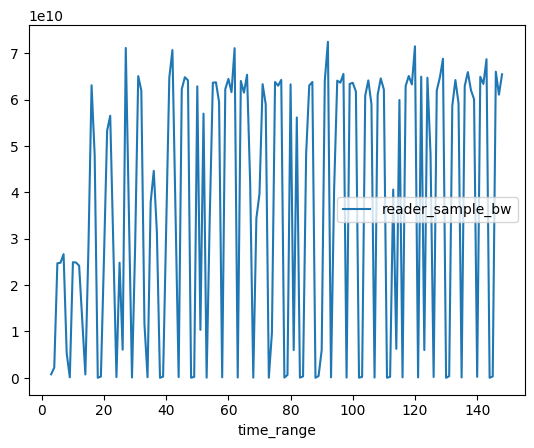

time: 254 ms (started: 2024-12-08 22:54:34 -08:00)


In [22]:
import pandas as pd
pd.read_csv('dlio_scr_step100_time_range.csv').query('reader_sample_bw > 0').set_index('time_range')[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'dataloader_sample_time',
        'reader_sample_bw',
        # 'posix_bw',
    ]
].plot(kind='line')

In [23]:
pd.read_csv('dlio_scr_step100_time_range.csv').query(
    'dlio_compute_util > 0 & dlio_compute_util < 0.99'
).set_index('time_range')[
    [
        'dlio_compute_util',
        'reader_sample_size',
        'reader_sample_time',
        'reader_sample_bw',
        'u_checkpoint_time',
        'u_posix_time',
        'u_posix_read_time',
        'u_posix_write_time',
        'u_posix_metadata_time',
    ]
]

dlio_compute_util  reader_sample_size  reader_sample_time  \
time_range                                                              
3                    0.448283          28123200.0            0.036653   
8                    0.534477          16588800.0            0.003135   
12                   0.658895         107827200.0            0.004459   
17                   0.627692          87091200.0            0.001813   
22                   0.603127          78796800.0            0.001394   
27                   0.625119          99532800.0            0.001399   
33                   0.509268           4147200.0            0.000354   
37                   0.637863          87091200.0            0.002764   
38                   0.968698          12441600.0            0.649950   
42                   0.599377          74649600.0            0.001056   
47                   0.654869          91238400.0            0.001422   
48                   0.974058          24883200.0            0.985969   
52                   0.602260          58060800.0            0.001019   
53                   0.968896          45619200.0            1.046639   
57                   0.581352          41472000.0            0.000697   
58                   0.971959          62208000.0            0.553154   
62                   0.540488          24883200.0            0.000350   
67                   0.546474          29030400.0            0.000692   
68                   0.984282          45619200.0            0.907929   
72                   0.564035          41196600.0            0.000698   
73                   0.988706          37324800.0            1.302247   
77                   0.568775          45619200.0            0.000710   
78                   0.981492          29030400.0            0.530404   
82                   0.585105          58060800.0            0.001034   
83                   0.988305          20736000.0            0.418800   
87                   0.593449          66355200.0            0.001040   
88                   0.967890          11821950.0            0.794439   
92                   0.632938          74649600.0            0.001030   
97                   0.607838          45619200.0            0.000696   
98                   0.989726          91238400.0            1.569468   
101                  0.682761         103680000.0            0.001679   
102                  0.985018          24883200.0            0.829100   
106                  0.627733          62208000.0            0.001054   
111                  0.574508          28364175.0            1.022391   
115                  0.669642          78796800.0            0.001315   
116                  0.987658          62208000.0            0.590011   
120                  0.539956          24883200.0            0.000348   
125                  0.582574          33177600.0            0.000687   
129                  0.664856          95385600.0            0.001386   
130                  0.946510          24883200.0            1.569276   
134                  0.625953          62208000.0            0.001050   
135                  0.982419          66355200.0            0.752522   
139                  0.547820          20736000.0            0.000345   
143                  0.652897          95385600.0            0.001388   
144                  0.968613          16588800.0            1.046895   
148                  0.448081          70502400.0            0.001077   

            reader_sample_bw  u_checkpoint_time  u_posix_time  \
time_range                                                      
3               7.672824e+08                NaN      4.720519   
8               5.291483e+09          56.062811     48.391064   
12              2.418192e+10           4.312509      0.000000   
17              4.803707e+10          23.166701      0.000000   
22              5.652568e+10          42.563216      0.000000   
27              7.114568e+10          28.836725     

time: 104 ms (started: 2024-12-08 22:54:49 -08:00)


<Axes: >

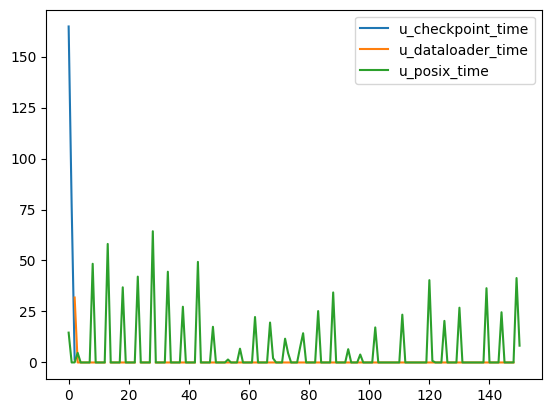

time: 175 ms (started: 2024-12-08 22:55:24 -08:00)


In [24]:
pd.read_csv('dlio_scr_step100_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        # 'dataloader_sample_time',
        'u_posix_time',
    ]
].plot(kind='line')

<Axes: >

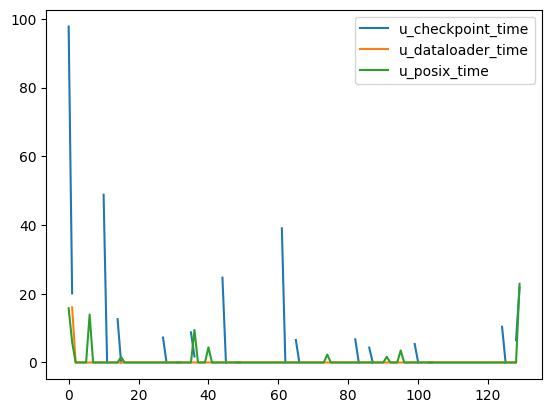

time: 164 ms (started: 2024-12-08 22:55:36 -08:00)


In [25]:
pd.read_csv('dlio_scr_opt_step100_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        # 'dataloader_sample_time',
        'u_posix_time',
    ]
].plot(kind='line')

In [14]:
df3.sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        'compute_time',
        # 'dlio_compute_time',
        # 'dlio_stall_time',
        'dlio_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].max().sum()

22644.65629

In [2]:
import pandas as pd

<Axes: >

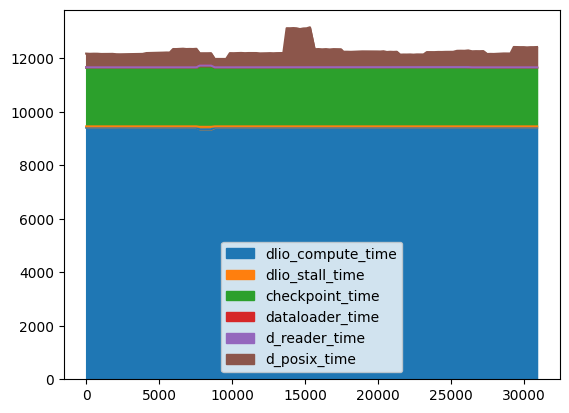

time: 1.71 s (started: 2024-12-08 22:55:46 -08:00)


In [26]:
pd.read_csv('dlio_scr_step100_proc_name.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'd_reader_time',
        # 'dataloader_sample_time',
        'd_posix_time',
    ]
].plot(kind='area') #, ylim=(0, 6000)) #kind='bar', stacked=True)

<Axes: >

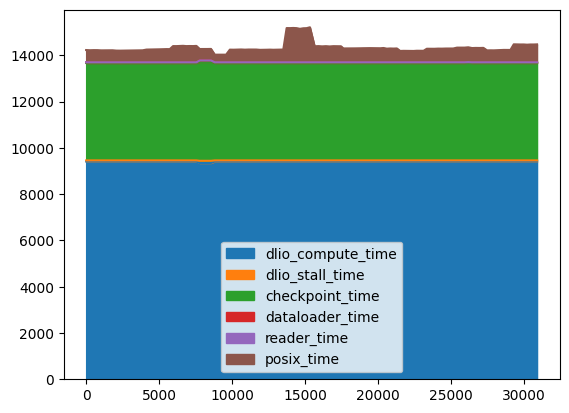

In [ ]:
pd.read_csv('dlio_scr_step100_proc_name.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'd_reader_time',
        # 'dataloader_sample_time',
        'd_posix_time',
    ]
].plot(kind='area') #, ylim=(0, 6000)) #kind='bar', stacked=True)

<Axes: >

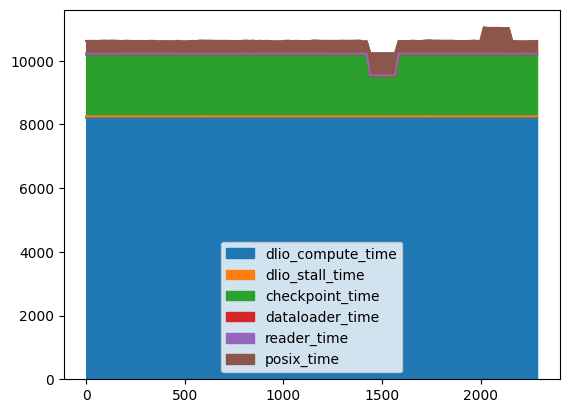

In [15]:
pd.read_csv('dlio_scr_opt_step100_proc_name.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area') #, ylim=(0, 6000)) #kind='bar', stacked=True)

<Axes: >

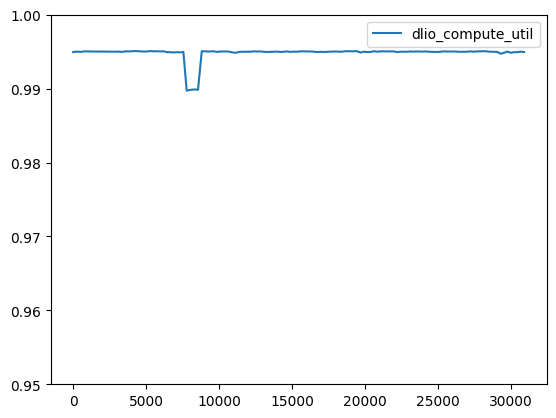

time: 1.61 s (started: 2024-12-08 21:24:35 -08:00)


In [22]:
pd.read_csv('dlio_scr_step100_proc_name.csv').query('dlio_stall_time > 0')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot(ylim=(0.95, 1))

<Axes: >

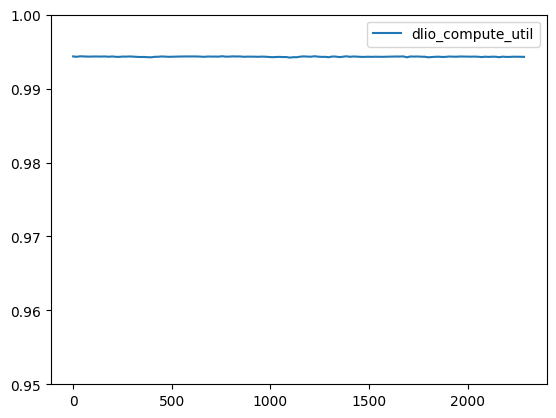

In [12]:
pd.read_csv('dlio_scr_opt_step100_proc_name.csv').query('dlio_stall_time > 0')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot(ylim=(0.95, 1))

In [3]:
df4 = pd.read_csv('dlio_scr_opt_step100_proc_name.csv')

<Axes: >

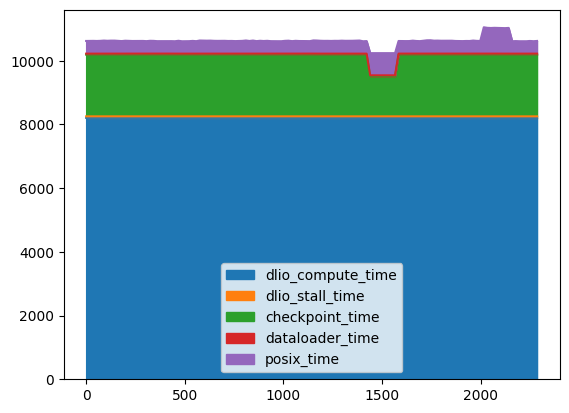

In [ ]:
df4.query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        # 'dataloader_sample_time',
        'd_reader_time',
        'd_posix_time',
    ]
].plot(kind='area') #kind='area', stacked=True)

<Axes: >

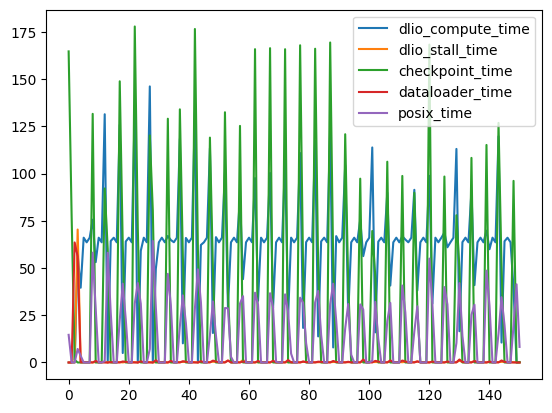

In [22]:
pd.read_csv('dlio_scr_step100_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot() #kind='bar', stacked=True)

<Axes: >

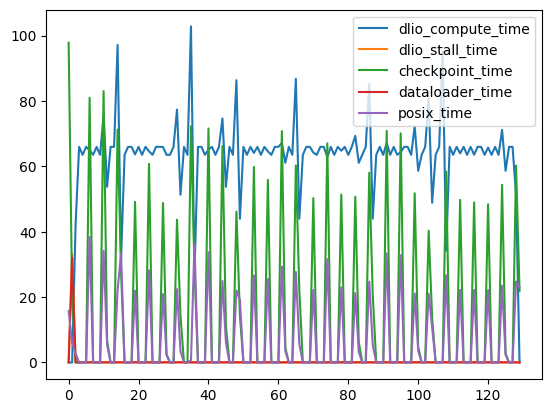

In [19]:
pd.read_csv('dlio_scr_opt_step100_time_range.csv').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='line')

In [24]:
metric_boundaries

{('proc_name',): 15263.008328,
 ('time_range',): 16620.608,
 ('proc_name', 'time_range'): 16620.608,
 ('time_range', 'proc_name'): 15263.008328,
 ('proc_name', 'host_name'): 15255.537883,
 ('proc_name', 'proc_id'): 15257.188308,
 ('proc_name', 'thread_id'): 15263.008328}

time: 2.39 ms (started: 2024-12-08 21:58:51 -08:00)


In [25]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dlio_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                7345.043799
checkpoint_time             4952.660786
dlio_compute_time           9422.426394
dlio_stall_time              105.177232
dlio_time                   9468.259311
dataloader_time               61.492428
dataloader_sample_time        29.646156
posix_time                  2218.731697
u_checkpoint_time           3701.718842
u_dataloader_time             31.846272
u_dataloader_sample_time            0.0
u_posix_time                 807.746878
dtype: double[pyarrow]

time: 5.53 ms (started: 2024-12-08 21:58:54 -08:00)


In [10]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dlio_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                7345.043799
checkpoint_time             4952.660786
dlio_compute_time           9422.426394
dlio_stall_time              105.177232
dlio_time                   9468.259311
dataloader_time              149.394569
dataloader_sample_time        29.646156
posix_time                  2218.731697
u_checkpoint_time           3701.718842
u_dataloader_time             117.35388
u_dataloader_sample_time            0.0
u_posix_time                 807.746878
dtype: double[pyarrow]

time: 6.94 ms (started: 2024-12-03 08:30:15 -08:00)


In [ ]:
 App Time  Runtime: 9773.62 seconds (100%)                                                                      │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Time: 23268.77 seconds (238.08%)                                                                 │
│            ├── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)      

In [12]:
persisted_traces['cat'].value_counts().compute()

cat
POSIX             94425930
STDIO             20200529
data_loader        6157823
reader             6156288
dlio_benchmark      767743
ai_framework        384000
checkpoint           41856
storage               1280
config                1024
dftracer               768
Name: count, dtype: int64[pyarrow]

time: 1.35 s (started: 2024-12-01 14:49:59 -08:00)


In [22]:
persisted_traces.query('cat == "dlio_benchmark"')['func_name'].value_counts().compute()

func_name
<module>.iter     383872
<module>.yield    383871
Name: count, dtype: int64[pyarrow]

time: 689 ms (started: 2024-12-01 13:05:41 -08:00)


In [23]:
persisted_traces.query('cat == "ai_framework"')['func_name'].value_counts().compute()

func_name
TorchFramework.compute                  384000
TorchFramework.trace_object             384000
TorchFramework.get_loader                  384
TorchFramework.is_nativeio_available       256
TorchFramework.init_loader                 128
Name: count, dtype: int64[pyarrow]

time: 1.71 s (started: 2024-12-01 13:05:56 -08:00)


In [26]:
persisted_traces.query('cat == "data_loader"')['func_name'].value_counts().compute()

func_name
TorchDataset.__getitem__    6156287
TorchDataset.worker_init        768
TorchDataLoader.__init__        256
TorchDataLoader.finalize        128
TorchDataLoader.next            128
TorchDataLoader.read            128
TorchDataset.__init__           128
Name: count, dtype: int64[pyarrow]

time: 771 ms (started: 2024-12-01 13:06:59 -08:00)


In [25]:
persisted_traces.query('cat == "reader"')['func_name'].value_counts().compute()

func_name
IndexedBinaryMMapReader.get_sample    6156288
IndexedBinaryMMapReader.read_index    6156288
IndexedBinaryMMapReader.__init__          768
IndexedBinaryMMapReader.load_index        768
Name: count, dtype: int64[pyarrow]

time: 923 ms (started: 2024-12-01 13:06:45 -08:00)


In [27]:
persisted_traces.query('cat == "checkpoint"')['func_name'].value_counts().compute()

func_name
SCRPyTorchCheckpointing.save_state    28800
SCRPyTorchCheckpointing.checkpoint     3840
SCRPyTorchCheckpointing.get_tensor     1280
SCRPyTorchCheckpointing.__init__        128
SCRPyTorchCheckpointing.finalize        128
                                      ...  
checkpoint_start_1_500                  128
checkpoint_start_1_600                  128
checkpoint_start_1_700                  128
checkpoint_start_1_800                  128
checkpoint_start_1_900                  128
Name: count, Length: 65, dtype: int64[pyarrow]

time: 646 ms (started: 2024-12-01 13:07:30 -08:00)


In [28]:
persisted_traces.query('cat == "storage"')['func_name'].value_counts().compute()

func_name
FileStorage.get_uri             512
FileStorage.__init__            256
FileStorage.walk_node           256
FileStorage.create_namespace    128
FileStorage.get_node            128
Name: count, dtype: int64[pyarrow]

time: 637 ms (started: 2024-12-01 13:07:45 -08:00)


In [29]:
persisted_traces.query('cat == "POSIX"')['func_name'].value_counts().compute()

func_name
lseek         43701460
read          24729700
__lxstat64     7203712
__xstat64      4655231
write          4478320
__fxstat64     2893062
lseek64        1744772
close          1639328
open64          898050
open            742990
unlink          415616
mmap64          387072
__xstat         324650
fsync           163596
opendir         143602
access          133951
__lxstat         57600
readlink         39936
chmod            28800
chown            28800
link              3328
mkdir             2980
fork              2816
__fxstat          2560
mmap              1536
ftruncate         1312
rmdir              764
fcntl              256
dup2               128
dup                  2
Name: count, dtype: int64[pyarrow]

time: 2.47 s (started: 2024-12-01 13:08:02 -08:00)


In [30]:
persisted_traces.query('cat == "STDIO"')['func_name'].value_counts().compute()

func_name
fwrite     20054143
fclose        71137
fopen64       55712
fopen         17993
fread          1288
fseek           128
ftell           128
Name: count, dtype: int64[pyarrow]

time: 1.15 s (started: 2024-12-01 13:08:16 -08:00)


In [20]:
persisted_traces.query('step.isna()')['func_name'].value_counts().compute()

func_name
lseek                         43701460
read                          24729700
fwrite                        20054143
__lxstat64                     7203712
__xstat64                      4655231
                                ...   
TorchFramework.init_loader         128
dup2                               128
fseek                              128
ftell                              128
dup                                  2
Name: count, Length: 63, dtype: int64[pyarrow]

time: 2.81 s (started: 2024-12-01 12:11:59 -08:00)


In [18]:
persisted_traces.query('step > 0')['func_name'].value_counts().compute()

func_name
IndexedBinaryMMapReader.get_sample    6156288
IndexedBinaryMMapReader.read_index    6156288
TorchDataset.__getitem__              6156287
<module>.iter                          383872
<module>.yield                         383871
                                       ...   
checkpoint_start_1_500                    128
checkpoint_start_1_600                    128
checkpoint_start_1_700                    128
checkpoint_start_1_800                    128
checkpoint_start_1_900                    128
Name: count, Length: 68, dtype: int64[pyarrow]

time: 877 ms (started: 2024-12-01 12:10:42 -08:00)


In [13]:
hlms['compute'].compute()

proc_name  acc_pat               func_name  io_cat  \
491    app#corona198#1466102#1466102        0  TorchFramework.compute       6   
492    app#corona198#1466102#1466102        0  TorchFramework.compute       6   
495    app#corona198#1466102#1466102        0  TorchFramework.compute       6   
496    app#corona198#1466102#1466102        0  TorchFramework.compute       6   
504    app#corona198#1466102#1466102        0  TorchFramework.compute       6   
...                              ...      ...                     ...     ...   
87742    app#corona200#995356#995356        0  TorchFramework.compute       6   
87751    app#corona200#995356#995356        0  TorchFramework.compute       6   
87768    app#corona200#995356#995356        0  TorchFramework.compute       6   
87771    app#corona200#995356#995356        0  TorchFramework.compute       6   
87797    app#corona200#995356#995356        0  TorchFramework.compute       6   

       time_range           cat       time  count  size_min  size_max  size  
491            31  ai_framework  65.941054     27        47        73  1620  
492            32  ai_framework  63.497449     26        74        99  2249  
495            40  ai_framework  63.497505     26        30        55  1105  
496            41  ai_framework  65.940475     27        56        82  1863  
504            60  ai_framework  65.939547     27        42        68  1485  
...           ...           ...        ...    ...       ...       ...   ...  
87742          33  ai_framework   2.442457      1       100       100   100  
87751          52  ai_framework  34.194253     14        87       100  1309  
87768          85  ai_framework  65.946183     27        32        58  1215  
87771          89  ai_framework   63.50259     26         4        29   429  
87797         141  ai_framework  65.946111     27        25        51  1026  

[18172 rows x 11 columns]

time: 72.1 ms (started: 2024-12-01 14:50:07 -08:00)


In [26]:
flat_views[('time_range',)][['compute_time_norm_score']]

compute_time_norm_score
time_range                         
0                                 0
1                                 0
2                                 0
3                                 1
4                                 2
...                             ...
146                               2
147                               2
148                               2
149                               0
150                               0

[151 rows x 1 columns]

time: 11 ms (started: 2024-12-03 08:37:44 -08:00)


In [15]:
time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=3).sum()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=3, win_type='gaussian').sum(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=3, win_type='hann').sum()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view[['reader_time', 'reader_r3_time', 'reader_r3_gauss_time', 'reader_r3_hann_time']]

reader_time  reader_r3_time  reader_r3_gauss_time  \
time_range                                                      
0              0.000000             NaN                   NaN   
1              0.000000             NaN                   NaN   
2              0.000000        0.000000              0.000000   
3              0.036653        0.036653              0.022231   
4              0.028424        0.065077              0.053893   
...                 ...             ...                   ...   
146            0.001696        1.399701              0.987113   
147            0.001765        0.354571              0.215726   
148            0.001077        0.004538              0.003447   
149            0.000000        0.002842              0.002148   
150            0.000000        0.001077              0.000653   

            reader_r3_hann_time  
time_range                       
0                           NaN  
1                           NaN  
2                      0.000000  
3                      0.000000  
4                      0.036653  
...                         ...  
146                    0.351110  
147                    0.001696  
148                    0.001765  
149                    0.001077  
150                    0.000000  

[151 rows x 4 columns]

In [39]:
import pandas as pd
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')


# time_range_view = pd.read_csv('cosmoflow_node4_proc_name.csv').copy().set_index('proc_name')
time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=4).sum()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=4, win_type='gaussian').sum(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=4, win_type='hann').sum()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=4).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=4, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=4, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')]
image_cols = [col for col in time_range_view.columns if 'image_' in col and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + checkpoint_cols + dataloader_cols + image_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]

norm_scores = time_range_view[norm_cols]
norm_scores

dlio_compute_util_score  checkpoint_bw_score  \
time_range                                                 
0                              <NA>                 <NA>   
1                              <NA>                 <NA>   
2                              <NA>                 <NA>   
3                              <NA>                 <NA>   
4                              <NA>                 <NA>   
...                             ...                  ...   
146                            <NA>                 <NA>   
147                            <NA>                 <NA>   
148                            <NA>                 <NA>   
149                            <NA>                 <NA>   
150                            <NA>                 <NA>   

            checkpoint_compute_per_score  checkpoint_count_per_score  \
time_range                                                             
0                                   <NA>                        <NA>   
1                                   <NA>                        <NA>   
2                                   <NA>                        <NA>   
3                                   <NA>                        <NA>   
4                                   <NA>                        <NA>   
...                                  ...                         ...   
146                                 <NA>                        <NA>   
147                                 <NA>                        <NA>   
148                                 <NA>                        <NA>   
149                                 <NA>                        <NA>   
150                                 <NA>                        <NA>   

            checkpoint_intensity_score  checkpoint_ops_rank_score  \
time_range                                                          
0                                 <NA>                       <NA>   
1                                 <NA>                       <NA>   
2                                 <NA>                       <NA>   
3                                 <NA>                       <NA>   
4                                 <NA>                       <NA>   
...                                ...                        ...   
146                               <NA>                       <NA>   
147                               <NA>                       <NA>   
148                               <NA>                       <NA>   
149                               <NA>                       <NA>   
150                               <NA>                       <NA>   

            checkpoint_time_norm_score  checkpoint_time_per_score  \
time_range                                                          
0                                 <NA>                       <NA>   
1                                 <NA>                       <NA>   
2                                 <NA>                       <NA>   
3                                 <NA>                       <NA>   
4                                 <NA>                       <NA>   
...                                ...                        ...   
146                               <NA>                       <NA>   
147                               <NA>                       <NA>   
148                               <NA>                       <NA>   
149                               <NA>                       <NA>   
150                               <NA>                       <NA>   

            u_checkpoint_time_norm_score  u_checkpoint_time_per_score  ...  \
time_range                                                             ...   
0                                   <NA>                         <NA>  ...   
1                                   <NA>                         <NA>  ...   
2                                   <NA>                         <NA>  ...   
3                                   <NA>                         <NA>  ...   
4                             

time: 621 ms (started: 2024-12-12 16:42:15 -08:00)


In [40]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

score_col  score
time_range                                     
0                d_image_time_norm_score      0
1                d_image_time_norm_score      0
2                d_image_time_norm_score      0
3                d_image_time_norm_score      1
4                d_image_time_norm_score      1
...                                  ...    ...
146         u_posix_write_time_per_score      1
147         u_posix_write_time_per_score      1
148         u_posix_write_time_per_score      3
149         u_posix_write_time_per_score      3
150         u_posix_write_time_per_score      2

[20046 rows x 2 columns]

time: 9.04 s (started: 2024-12-12 16:42:16 -08:00)


In [27]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()

VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

NameError: name 'norm_cols' is not defined

time: 39.9 ms (started: 2024-12-12 17:21:17 -08:00)


In [43]:
pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')[
    [
        'dlio_compute_time',
        'dlio_stall_time',
        'dlio_compute_util',
        'dlio_compute_util_score',
        'dataloader_time'
    ]
]

dlio_compute_time  dlio_stall_time  dlio_compute_util  \
time_range                                                          
0                         NaN              NaN                NaN   
1                         NaN              NaN                NaN   
2                         NaN              NaN                NaN   
3                         NaN              NaN                NaN   
4                         NaN              NaN                NaN   
...                       ...              ...                ...   
146                       NaN              NaN                NaN   
147                       NaN              NaN                NaN   
148                       NaN              NaN                NaN   
149                       NaN              NaN                NaN   
150                       NaN              NaN                NaN   

            dlio_compute_util_score  dataloader_time  
time_range                                            
0                               NaN              NaN  
1                               NaN              NaN  
2                               NaN              NaN  
3                               NaN              NaN  
4                               NaN              NaN  
...                             ...              ...  
146                             NaN              NaN  
147                             NaN              NaN  
148                             NaN              NaN  
149                             NaN              NaN  
150                             NaN              NaN  

[151 rows x 5 columns]

time: 40.8 ms (started: 2024-12-12 16:43:46 -08:00)


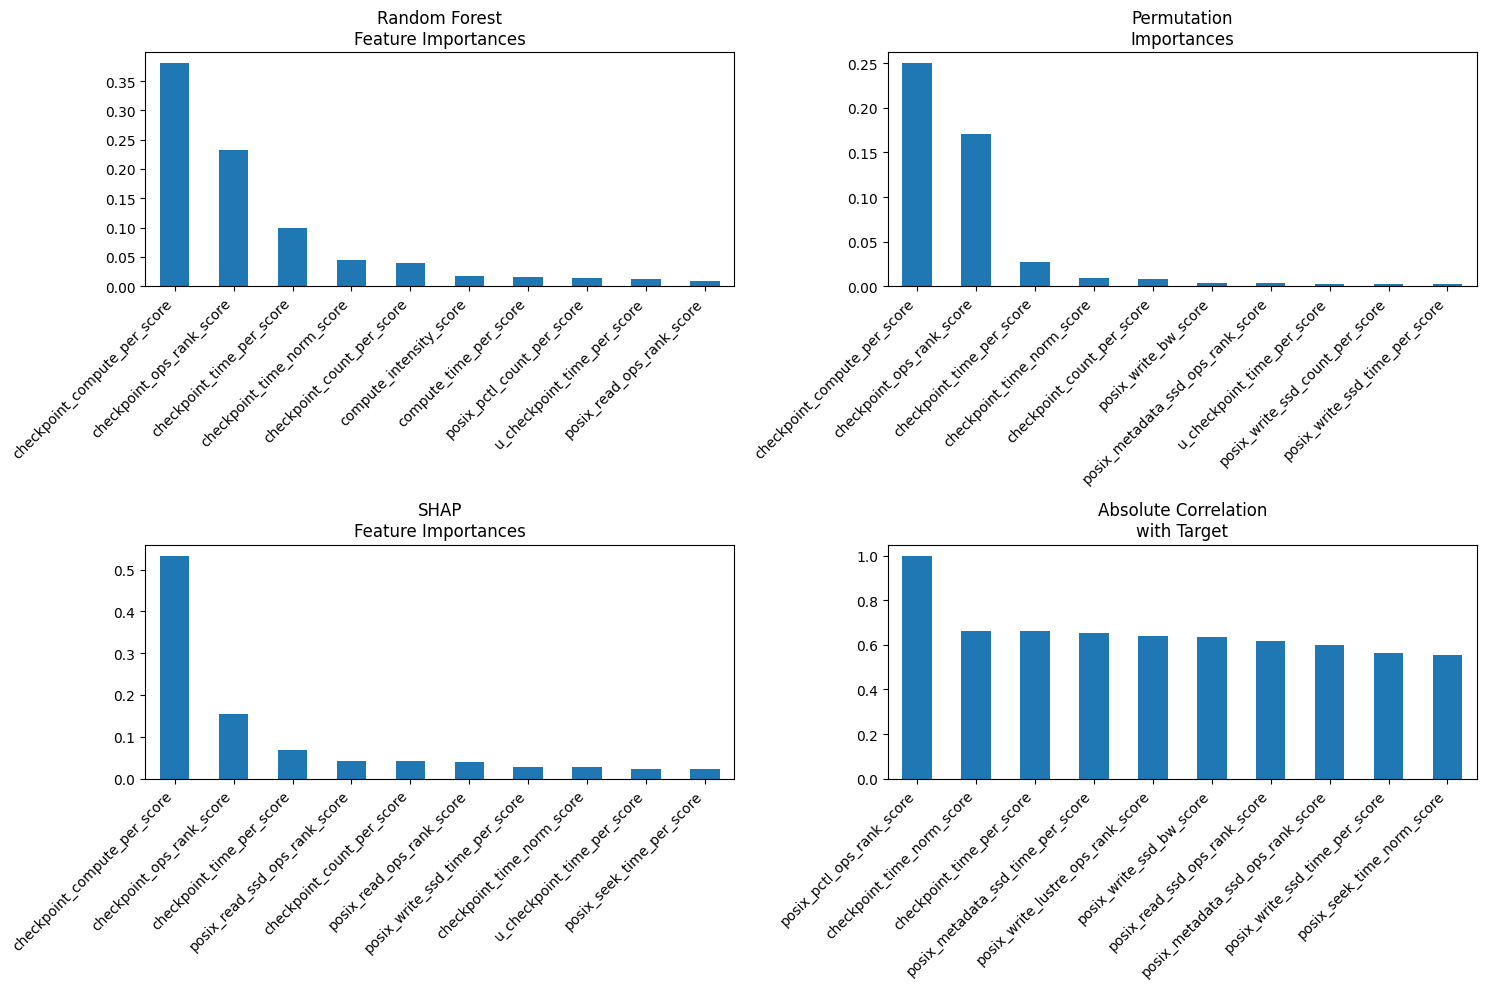

Top Features Across Different Methods:

Random Forest Importances:
 checkpoint_compute_per_score    0.380371
checkpoint_ops_rank_score       0.231882
checkpoint_time_per_score       0.099849
checkpoint_time_norm_score      0.045033
checkpoint_count_per_score      0.038825
compute_intensity_score         0.017942
compute_time_per_score          0.015737
posix_pctl_count_per_score      0.014104
u_checkpoint_time_per_score     0.012677
posix_read_ops_rank_score       0.008333
dtype: float64

Permutation Importances:
 checkpoint_compute_per_score         0.250108
checkpoint_ops_rank_score            0.170839
checkpoint_time_per_score            0.026508
checkpoint_time_norm_score           0.008855
checkpoint_count_per_score           0.007660
posix_write_bw_score                 0.003296
posix_metadata_ssd_ops_rank_score    0.003236
u_checkpoint_time_per_score          0.002430
posix_write_ssd_count_per_score      0.002265
posix_write_ssd_time_per_score       0.002098
dtype: float64

SHAP

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns

def multi_modal_feature_importance(df, target='dlio_compute_util_score'):
    # Prepare data
    score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col]
    score_cols = score_cols + [target]
    
    X = df[score_cols].drop(columns=[target])
    y = df[target].fillna(0)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Random Forest Feature Importance
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # 2. Permutation Importance
    perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)
    
    # 3. SHAP Values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=X.columns).sort_values(ascending=False)
    
    # 4. Correlation Analysis
    correlation_matrix = X.corrwith(y)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Random Forest Importances
    plt.subplot(2, 2, 1)
    rf_importances.head(10).plot(kind='bar')
    plt.title('Random Forest\nFeature Importances')
    plt.xticks(rotation=45, ha='right')
    
    # Permutation Importances
    plt.subplot(2, 2, 2)
    perm_importances.head(10).plot(kind='bar')
    plt.title('Permutation\nImportances')
    plt.xticks(rotation=45, ha='right')
    
    # SHAP Importances
    plt.subplot(2, 2, 3)
    shap_importance.head(10).plot(kind='bar')
    plt.title('SHAP\nFeature Importances')
    plt.xticks(rotation=45, ha='right')
    
    # Correlation Heatmap
    plt.subplot(2, 2, 4)
    correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
    correlation_with_target.head(10).plot(kind='bar')
    plt.title('Absolute Correlation\nwith Target')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print Top Features
    print("Top Features Across Different Methods:")
    print("\nRandom Forest Importances:\n", rf_importances.head(10))
    print("\nPermutation Importances:\n", perm_importances.head(10))
    print("\nSHAP Importances:\n", shap_importance.head(10))
    print("\nCorrelation with Target:\n", correlation_with_target.head(10))

# Usage
df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
multi_modal_feature_importance(df)

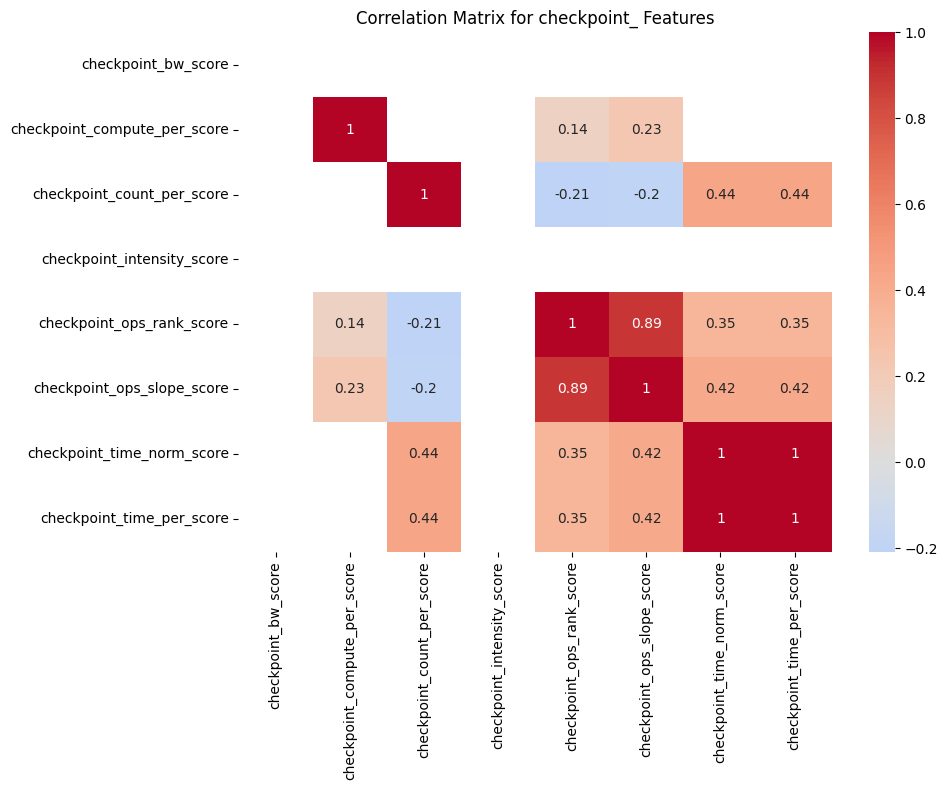


checkpoint_ Category:
Original features: ['checkpoint_bw_score', 'checkpoint_compute_per_score', 'checkpoint_count_per_score', 'checkpoint_intensity_score', 'checkpoint_ops_rank_score', 'checkpoint_ops_slope_score', 'checkpoint_time_norm_score', 'checkpoint_time_per_score']
Reduced features: ['checkpoint_bw_score', 'checkpoint_compute_per_score', 'checkpoint_count_per_score', 'checkpoint_intensity_score', 'checkpoint_ops_rank_score', 'checkpoint_time_per_score']
Dropped features: {'checkpoint_time_norm_score', 'checkpoint_ops_slope_score'}


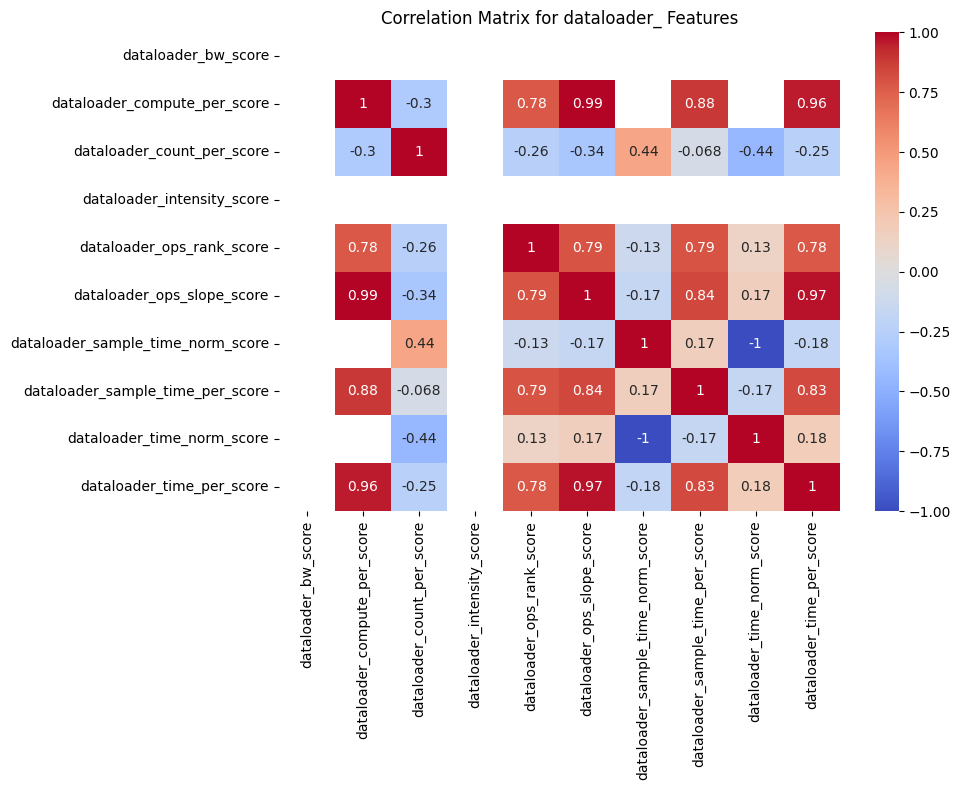


dataloader_ Category:
Original features: ['dataloader_bw_score', 'dataloader_compute_per_score', 'dataloader_count_per_score', 'dataloader_intensity_score', 'dataloader_ops_rank_score', 'dataloader_ops_slope_score', 'dataloader_sample_time_norm_score', 'dataloader_sample_time_per_score', 'dataloader_time_norm_score', 'dataloader_time_per_score']
Reduced features: ['dataloader_bw_score', 'dataloader_count_per_score', 'dataloader_intensity_score', 'dataloader_ops_rank_score', 'dataloader_ops_slope_score', 'dataloader_sample_time_norm_score', 'dataloader_sample_time_per_score']
Dropped features: {'dataloader_compute_per_score', 'dataloader_time_per_score', 'dataloader_time_norm_score'}


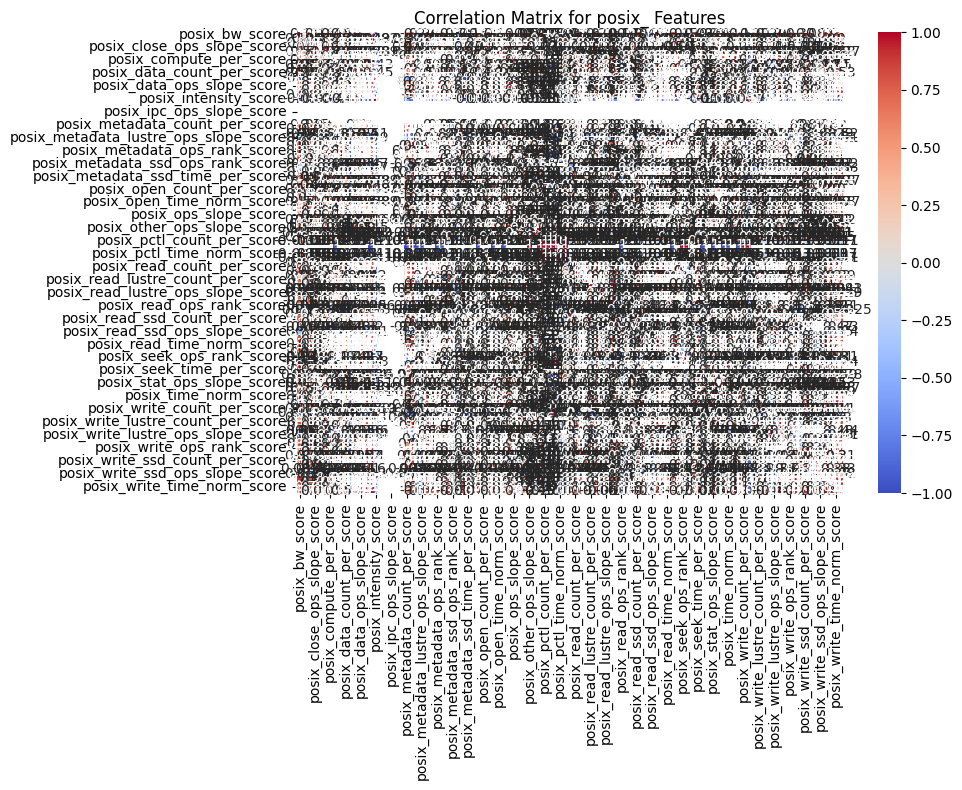


posix_ Category:
Original features: ['posix_bw_score', 'posix_close_count_per_score', 'posix_close_ops_rank_score', 'posix_close_ops_slope_score', 'posix_close_time_norm_score', 'posix_close_time_per_score', 'posix_compute_per_score', 'posix_count_per_score', 'posix_data_bw_score', 'posix_data_count_per_score', 'posix_data_intensity_score', 'posix_data_ops_rank_score', 'posix_data_ops_slope_score', 'posix_data_time_norm_score', 'posix_data_time_per_score', 'posix_intensity_score', 'posix_ipc_count_per_score', 'posix_ipc_ops_rank_score', 'posix_ipc_ops_slope_score', 'posix_ipc_time_norm_score', 'posix_ipc_time_per_score', 'posix_metadata_count_per_score', 'posix_metadata_lustre_count_per_score', 'posix_metadata_lustre_ops_rank_score', 'posix_metadata_lustre_ops_slope_score', 'posix_metadata_lustre_time_norm_score', 'posix_metadata_lustre_time_per_score', 'posix_metadata_ops_rank_score', 'posix_metadata_ops_slope_score', 'posix_metadata_ssd_count_per_score', 'posix_metadata_ssd_ops_rank

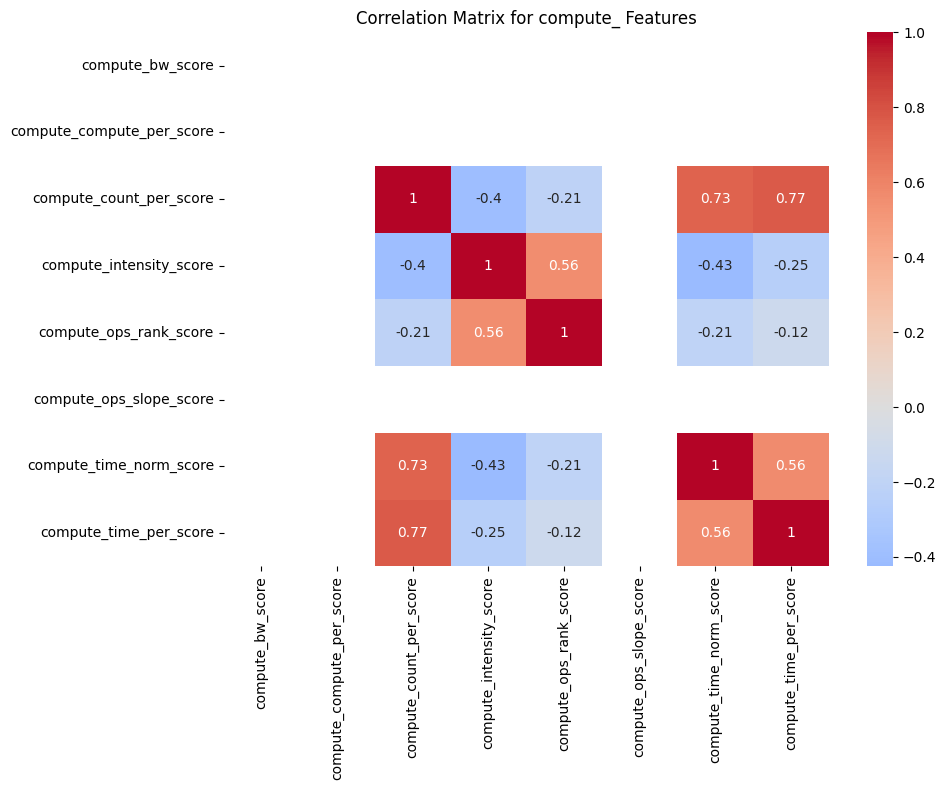


compute_ Category:
Original features: ['compute_bw_score', 'compute_compute_per_score', 'compute_count_per_score', 'compute_intensity_score', 'compute_ops_rank_score', 'compute_ops_slope_score', 'compute_time_norm_score', 'compute_time_per_score']
Reduced features: ['compute_bw_score', 'compute_compute_per_score', 'compute_count_per_score', 'compute_intensity_score', 'compute_ops_rank_score', 'compute_ops_slope_score', 'compute_time_norm_score', 'compute_time_per_score']
Dropped features: set()


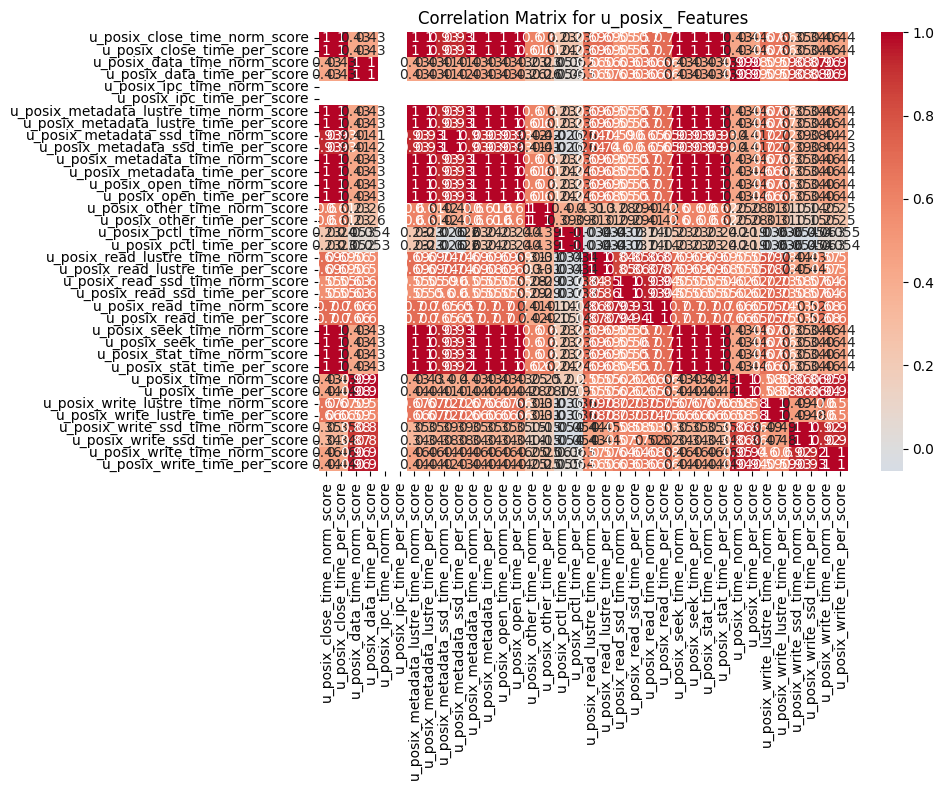


u_posix_ Category:
Original features: ['u_posix_close_time_norm_score', 'u_posix_close_time_per_score', 'u_posix_data_time_norm_score', 'u_posix_data_time_per_score', 'u_posix_ipc_time_norm_score', 'u_posix_ipc_time_per_score', 'u_posix_metadata_lustre_time_norm_score', 'u_posix_metadata_lustre_time_per_score', 'u_posix_metadata_ssd_time_norm_score', 'u_posix_metadata_ssd_time_per_score', 'u_posix_metadata_time_norm_score', 'u_posix_metadata_time_per_score', 'u_posix_open_time_norm_score', 'u_posix_open_time_per_score', 'u_posix_other_time_norm_score', 'u_posix_other_time_per_score', 'u_posix_pctl_time_norm_score', 'u_posix_pctl_time_per_score', 'u_posix_read_lustre_time_norm_score', 'u_posix_read_lustre_time_per_score', 'u_posix_read_ssd_time_norm_score', 'u_posix_read_ssd_time_per_score', 'u_posix_read_time_norm_score', 'u_posix_read_time_per_score', 'u_posix_seek_time_norm_score', 'u_posix_seek_time_per_score', 'u_posix_stat_time_norm_score', 'u_posix_stat_time_per_score', 'u_posix

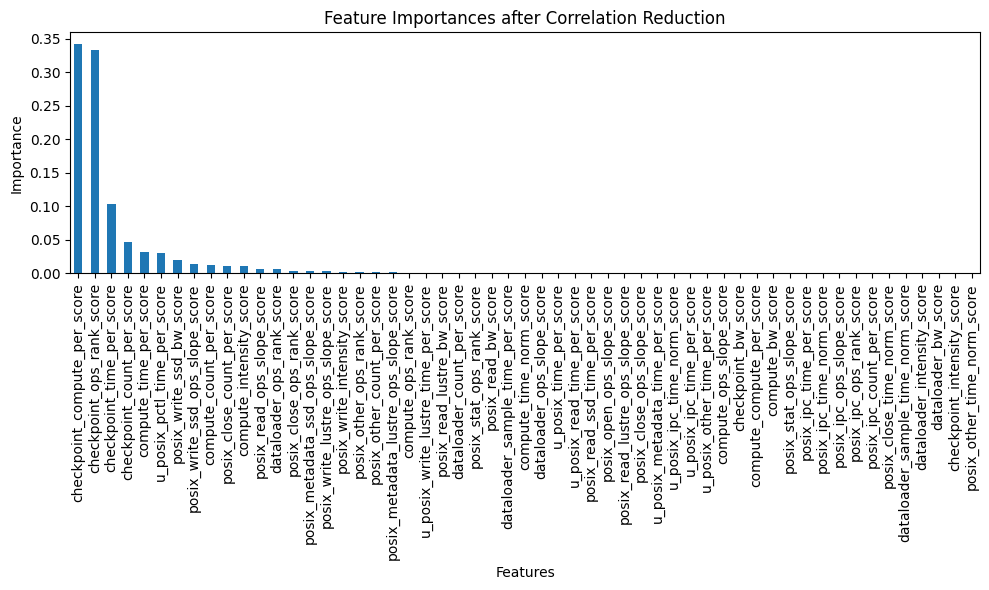

time: 16.6 s (started: 2024-12-12 17:22:50 -08:00)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr

def reduce_correlated_features(df, correlation_threshold=0.85, verbose=True):
    # Function to get features from a specific prefix
    def get_category_features(prefix):
        return [col for col in df.columns if col.startswith(prefix) and col.endswith('_score')]
    
    # Categories to process
    categories = ['checkpoint_', 'dataloader_', 'posix_', 'compute_', 'u_posix_']
    
    # Store reduced features
    reduced_features = []
    
    for category in categories:
        cat_features = get_category_features(category)
        
        if len(cat_features) <= 1:
            reduced_features.extend(cat_features)
            continue
        
        # Compute correlation matrix for category
        cat_corr_matrix = df[cat_features].corr(method='spearman')
        
        # Visualization of correlation matrix (optional)
        if verbose:
            plt.figure(figsize=(10, 8))
            sns.heatmap(cat_corr_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title(f'Correlation Matrix for {category} Features')
            plt.tight_layout()
            plt.show()
        
        # Find features to drop
        features_to_drop = set()
        for i in range(len(cat_features)):
            for j in range(i+1, len(cat_features)):
                if abs(cat_corr_matrix.iloc[i, j]) > correlation_threshold:
                    # Compare variance and keep higher variance feature
                    var_i = df[cat_features[i]].var()
                    var_j = df[cat_features[j]].var()
                    
                    if var_i >= var_j:
                        features_to_drop.add(cat_features[j])
                    else:
                        features_to_drop.add(cat_features[i])
        
        # Keep features not in drop list
        cat_reduced_features = [f for f in cat_features if f not in features_to_drop]
        reduced_features.extend(cat_reduced_features)
        
        if verbose:
            print(f"\n{category} Category:")
            print("Original features:", cat_features)
            print("Reduced features:", cat_reduced_features)
            print("Dropped features:", features_to_drop)
    
    return reduced_features

# Usage
df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'

# Get reduced feature set
reduced_score_cols = reduce_correlated_features(df)

# Prepare data for Random Forest
X = df[reduced_score_cols]
y = df[target].fillna(0)

# Proceed with Random Forest as before
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nReduced Feature Importances:")
print(feature_importances)

# Optional: Visualize reduced feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances after Correlation Reduction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Feature Importances (Random Forest):
checkpoint_compute_per_score      0.349654
checkpoint_ops_rank_score         0.298803
checkpoint_time_per_score         0.080520
checkpoint_time_norm_score        0.036783
checkpoint_count_per_score        0.034502
                                    ...   
posix_open_time_per_score         0.000000
posix_open_time_norm_score        0.000000
posix_metadata_time_per_score     0.000000
posix_metadata_time_norm_score    0.000000
u_reader_time_per_score           0.000000
Length: 145, dtype: float64


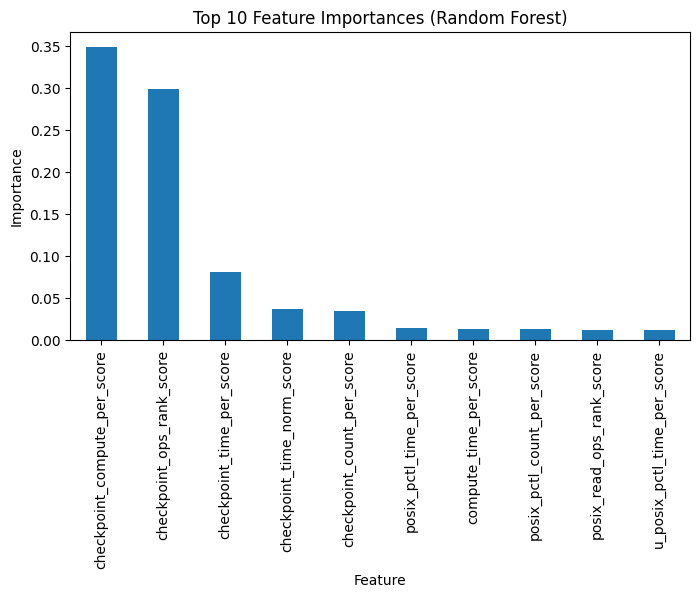

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data_' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


def _find_optimal_eps(scaled_behaviors: np.ndarray, min_samples: int = 5):
    if len(scaled_behaviors) <= min_samples:
        return 0
    # Calculate distances
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(scaled_behaviors)
    distances, _ = neigh.kneighbors(scaled_behaviors)
    distances = np.sort(distances[:, -1])
    if len(distances) <= 3:
        return np.mean(distances)
    # Calculate derivatives
    diffs = np.diff(distances)
    acceleration = np.diff(diffs)
    elbow_index = np.argmax(acceleration) + 1
    eps = distances[elbow_index]
    return eps


def _get_bottleneck_behavior_columns(bottlenecks: pd.DataFrame):
    return bottlenecks.columns[
        # Include only behavior columns
        bottlenecks.columns.str.contains("_min|_max|_count|_size|n_|b_")
        # Remove bottleneck scores
        & ~bottlenecks.columns.str.contains("u_|_norm|_ops|_per|_rank|_score|_slope|_time")
        # Remove bottleneck reasons
        & ~bottlenecks.columns.str.contains("|".join([f"_{r}" for r in range(0, 10)]))
    ]


def _set_bottleneck_behavior(bottlenecks: pd.DataFrame, min_samples: int = 5):
    behavior_cols = _get_bottleneck_behavior_columns(bottlenecks)
    behaviors = bottlenecks[behavior_cols].copy().fillna(0)
    num_behaviors = len(behaviors)
    if num_behaviors == 0:
        bottlenecks["behavior"] = -1
        return bottlenecks
    scaler = StandardScaler()
    scaled_behaviors = scaler.fit_transform(behaviors)
    min_samples = min(min_samples, num_behaviors - 1)
    if min_samples == 0:
        bottlenecks["behavior"] = -1
        return bottlenecks
    optimal_eps = _find_optimal_eps(scaled_behaviors, min_samples=min_samples)
    dbscan = DBSCAN(eps=max(optimal_eps, 1.0), min_samples=min_samples)
    bottlenecks["behavior"] = dbscan.fit_predict(scaled_behaviors)
    return bottlenecks

In [9]:
bottlenecks = df[df['checkpoint_compute_per_score'] > 0]
behavior_cols = _get_bottleneck_behavior_columns(bottlenecks)
bottlenecks_behaviors = _set_bottleneck_behavior(bottlenecks)
bottlenecks_behaviors[behavior_cols]

/var/tmp/izzet/ipykernel_2709608/3759822629.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bottlenecks["behavior"] = dbscan.fit_predict(scaled_behaviors)
/var/tmp/izzet/ipykernel_2709608/3759822629.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottlenecks["behavior"] = dbscan.fit_predict(scaled_behaviors)


checkpoint_count  checkpoint_size  checkpoint_size_max  \
time_range                                                           
8                      128.0              0.0                  0.0   
12                     128.0              0.0                  0.0   
17                     128.0              0.0                  0.0   
22                     128.0              0.0                  0.0   
27                     128.0              0.0                  0.0   
33                     128.0              0.0                  0.0   
37                     128.0              0.0                  0.0   
42                     128.0              0.0                  0.0   
47                     128.0              0.0                  0.0   
52                     128.0              0.0                  0.0   
57                     128.0              0.0                  0.0   
62                     128.0              0.0                  0.0   
67                     128.0              0.0                  0.0   
72                     128.0              0.0                  0.0   
77                     128.0              0.0                  0.0   
82                     128.0              0.0                  0.0   
87                     128.0              0.0                  0.0   
92                     128.0              0.0                  0.0   
97                     128.0              0.0                  0.0   
101                    128.0              0.0                  0.0   
106                    128.0              0.0                  0.0   
111                    128.0              0.0                  0.0   
115                    128.0              0.0                  0.0   
120                    128.0              0.0                  0.0   
125                    128.0              0.0                  0.0   
129                    128.0              0.0                  0.0   
134                    128.0              0.0                  0.0   
139                    128.0              0.0                  0.0   
143                    128.0              0.0                  0.0   
148                    128.0              0.0                  0.0   

            checkpoint_size_min  compute_count  compute_size  \
time_range                                                     
8                           0.0          512.0       50432.0   
12                          0.0         3328.0      291200.0   
17                          0.0         2688.0      241920.0   
22                          0.0         2432.0      221312.0   
27                          0.0         3072.0      271872.0   
33                          0.0          128.0       12800.0   
37                          0.0         2688.0      241920.0   
42                          0.0         2304.0      210816.0   
47                          0.0         2816.0      252032.0   
52                          0.0         1792.0      167552.0   
57                          0.0         1280.0      122240.0   
62                          0.0          768.0       74880.0   
67                          0.0          896.0       86912.0   
72                          0.0         1280.0      122240.0   
77                          0.0         1408.0      133760.0   
82                          0.0         1792.0      167552.0   
87                          0.0         2048.0      189440.0   
92                          0.0         2304.0      210816.0   
97                          0.0         1408.0      133760.0   
101                         0.0         3200.0      281600.0   
106                         0.0         1920.0      178560.0   
111                         0.0          896.0       63104.0   
115                         0.0         2432.0      221312.0   
120                         0.0          768.0       74880.0   
125                         0.0         1024.0       98816.0   
129                         0.0         294

In [77]:
behavior_cols

Index(['checkpoint_count', 'checkpoint_size', 'checkpoint_size_max',
       'checkpoint_size_min', 'compute_count', 'compute_size',
       'compute_size_max', 'compute_size_min', 'dataloader_count',
       'dataloader_size', 'dataloader_size_max', 'dataloader_size_min',
       'dlio_count', 'dlio_size', 'dlio_size_max', 'dlio_size_min',
       'image_count', 'image_size', 'image_size_max', 'image_size_min',
       'posix_close_count', 'posix_count', 'posix_data_count',
       'posix_data_size', 'posix_data_size_max', 'posix_data_size_min',
       'posix_ipc_count', 'posix_metadata_count', 'posix_open_count',
       'posix_other_count', 'posix_pctl_count', 'posix_read_count',
       'posix_read_size', 'posix_read_size_max', 'posix_read_size_min',
       'posix_seek_count', 'posix_size', 'posix_size_max', 'posix_size_min',
       'posix_stat_count', 'posix_write_count', 'posix_write_size',
       'posix_write_size_max', 'posix_write_size_min', 'reader_count',
       'reader_sample_size',

time: 2.7 ms (started: 2024-12-08 23:34:59 -08:00)


In [10]:
bottlenecks_behaviors[bottlenecks_behaviors['behavior'] == -1][behavior_cols]

checkpoint_count  checkpoint_size  checkpoint_size_max  \
time_range                                                           
111                    128.0              0.0                  0.0   

            checkpoint_size_min  compute_count  compute_size  \
time_range                                                     
111                         0.0          896.0       63104.0   

            compute_size_max  compute_size_min  dataloader_count  \
time_range                                                         
111                    100.0               1.0           14007.0   

            dataloader_size  ...  posix_write_size  posix_write_size_max  \
time_range                   ...                                           
111                     0.0  ...     1038212632423          267937059968   

            posix_write_size_min  reader_count  reader_sample_size  \
time_range                                                           
111                  26842268961       14007.0          28364175.0   

            reader_sample_size_max  reader_sample_size_min  reader_size  \
time_range                                                                
111                      1555200.0               1555200.0   28364175.0   

            reader_size_max  reader_size_min  
time_range                                    
111                  2025.0           2025.0  

[1 rows x 51 columns]

In [11]:
bottlenecks_behaviors[list(behavior_cols) + ['behavior']].to_csv('beh.csv')

In [12]:
bottlenecks_behaviors[list(behavior_cols) + ['behavior']]

checkpoint_count  checkpoint_size  checkpoint_size_max  \
time_range                                                           
8                      128.0              0.0                  0.0   
12                     128.0              0.0                  0.0   
17                     128.0              0.0                  0.0   
22                     128.0              0.0                  0.0   
27                     128.0              0.0                  0.0   
33                     128.0              0.0                  0.0   
37                     128.0              0.0                  0.0   
42                     128.0              0.0                  0.0   
47                     128.0              0.0                  0.0   
52                     128.0              0.0                  0.0   
57                     128.0              0.0                  0.0   
62                     128.0              0.0                  0.0   
67                     128.0              0.0                  0.0   
72                     128.0              0.0                  0.0   
77                     128.0              0.0                  0.0   
82                     128.0              0.0                  0.0   
87                     128.0              0.0                  0.0   
92                     128.0              0.0                  0.0   
97                     128.0              0.0                  0.0   
101                    128.0              0.0                  0.0   
106                    128.0              0.0                  0.0   
111                    128.0              0.0                  0.0   
115                    128.0              0.0                  0.0   
120                    128.0              0.0                  0.0   
125                    128.0              0.0                  0.0   
129                    128.0              0.0                  0.0   
134                    128.0              0.0                  0.0   
139                    128.0              0.0                  0.0   
143                    128.0              0.0                  0.0   
148                    128.0              0.0                  0.0   

            checkpoint_size_min  compute_count  compute_size  \
time_range                                                     
8                           0.0          512.0       50432.0   
12                          0.0         3328.0      291200.0   
17                          0.0         2688.0      241920.0   
22                          0.0         2432.0      221312.0   
27                          0.0         3072.0      271872.0   
33                          0.0          128.0       12800.0   
37                          0.0         2688.0      241920.0   
42                          0.0         2304.0      210816.0   
47                          0.0         2816.0      252032.0   
52                          0.0         1792.0      167552.0   
57                          0.0         1280.0      122240.0   
62                          0.0          768.0       74880.0   
67                          0.0          896.0       86912.0   
72                          0.0         1280.0      122240.0   
77                          0.0         1408.0      133760.0   
82                          0.0         1792.0      167552.0   
87                          0.0         2048.0      189440.0   
92                          0.0         2304.0      210816.0   
97                          0.0         1408.0      133760.0   
101                         0.0         3200.0      281600.0   
106                         0.0         1920.0      178560.0   
111                         0.0          896.0       63104.0   
115                         0.0         2432.0      221312.0   
120                         0.0          768.0       74880.0   
125                         0.0         1024.0       98816.0   
129                         0.0         294

Top correlations with 'dlio_compute_util_score':
dlio_compute_util_score               1.000000
reader_sample_bw_score                0.309152
reader_bw_score                       0.309152
d_compute_time_norm_score             0.249482
d_compute_time_per_score              0.249482
                                        ...   
u_reader_preprocess_time_per_score         NaN
u_reader_sample_time_norm_score            NaN
u_reader_sample_time_per_score             NaN
u_reader_time_norm_score                   NaN
u_reader_time_per_score                    NaN
Name: dlio_compute_util_score, Length: 69, dtype: float64


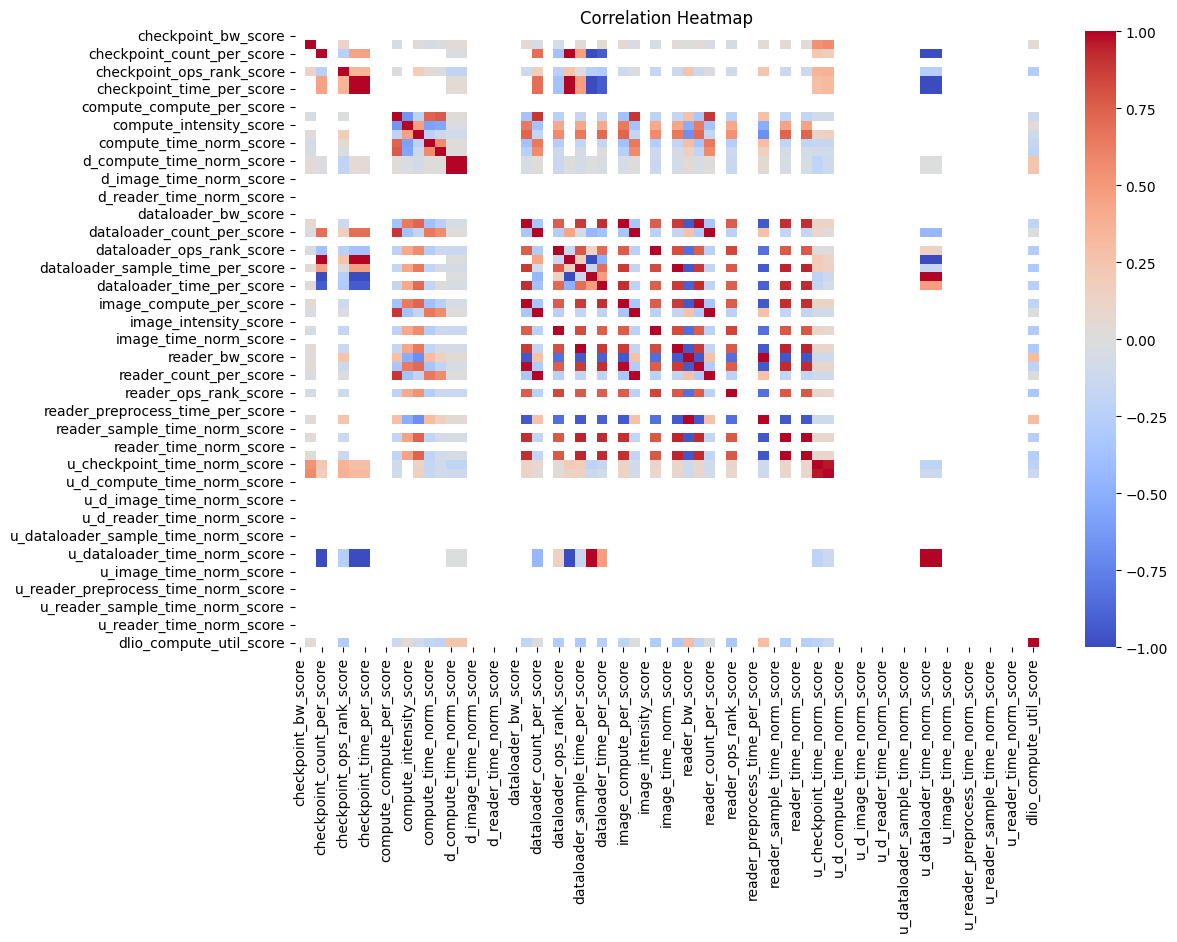

time: 873 ms (started: 2024-12-09 11:44:38 -08:00)


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


Feature Importances (Random Forest):
posix_read_count_per_score            0.080298
posix_time_per_score                  0.060107
u_posix_time_per_score                0.060000
u_dataloader_sample_time_per_score    0.060000
dataloader_count_per_score            0.050000
                                        ...   
posix_intensity_score                 0.000000
posix_close_time_per_score            0.000000
posix_close_time_norm_score           0.000000
posix_close_ops_rank_score            0.000000
u_reader_time_per_score               0.000000
Length: 145, dtype: float64


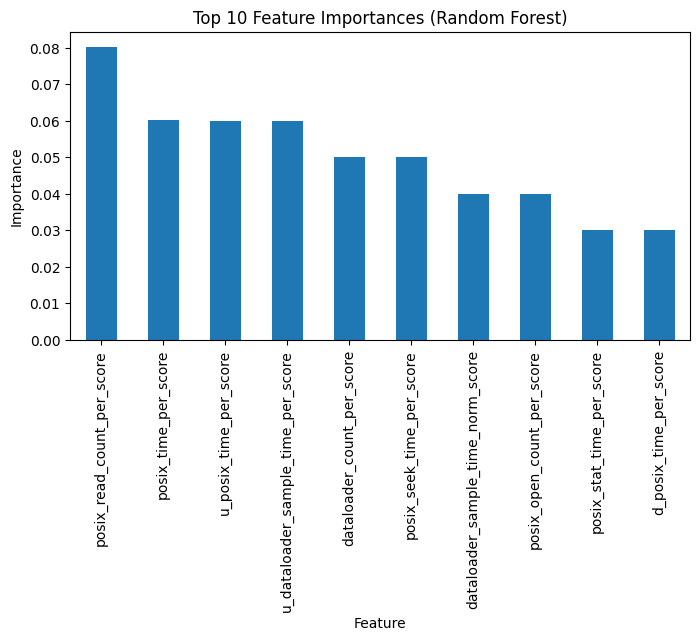

time: 2.63 s (started: 2024-12-08 23:06:22 -08:00)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('dlio_scr_step100_proc_name.csv').copy().set_index('proc_name')#.query('compute_time > 0')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
checkpoint_bw_score               NaN
checkpoint_compute_per_score      NaN
checkpoint_count_per_score        NaN
checkpoint_intensity_score        NaN
checkpoint_ops_rank_score         NaN
                                   ..
u_reader_sample_time_norm_score   NaN
u_reader_sample_time_per_score    NaN
u_reader_time_norm_score          NaN
u_reader_time_per_score           NaN
dlio_compute_util_score           NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


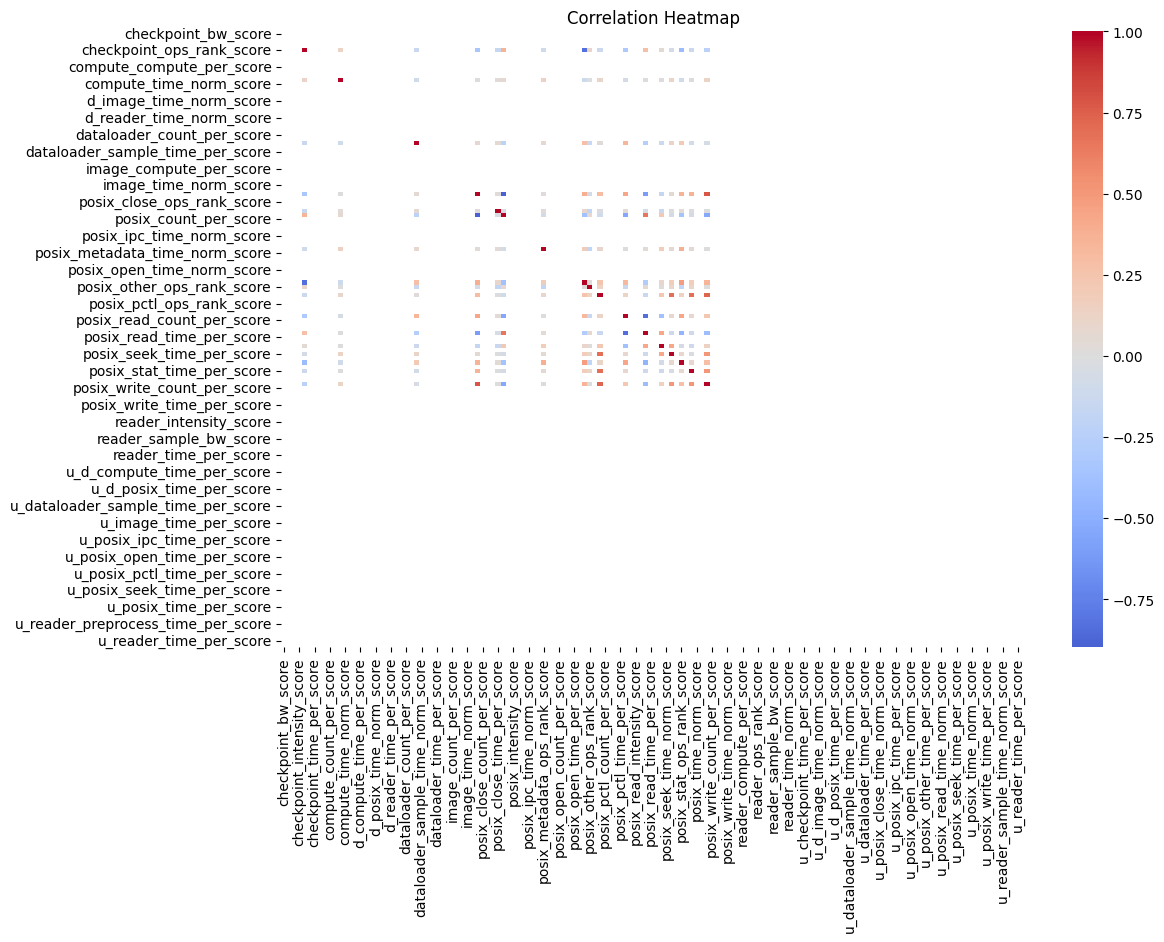

time: 2.35 s (started: 2024-12-08 22:15:38 -08:00)


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('dlio_scr_step100_proc_name.csv').copy().set_index('proc_name').query('compute_time > 0')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


In [53]:
proc_name_view = (
    pd.read_csv('dlio_scr_step100_proc_name.csv').copy().set_index('proc_name')
)
proc_name_view.query('compute_time > 0')[
    [
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'image_time',
        'reader_time',
        'posix_time',
        'checkpoint_time',
        'dlio_compute_util',
        'dlio_compute_util_score',
        'checkpoint_compute_per',
        'posix_compute_per',
    ]
]

dlio_compute_time  dlio_stall_time  \
proc_name                                                           
app#corona188#1522409#1522409        9411.916024        47.832910   
app#corona188#1522410#1522410        9412.509314        47.258608   
app#corona188#1522411#1522411        9412.170644        47.667106   
app#corona188#1522412#1522412        9412.799379        46.921506   
app#corona188#1522413#1522413        9412.765686        47.061565   
...                                          ...              ...   
app#corona213#1009618#1009618        9411.237669        48.771169   
app#corona213#1009619#1009619        9412.125263        47.985577   
app#corona213#1009620#1009620        9412.143826        47.989480   
app#corona213#1009621#1009621        9411.671149        47.320539   
app#corona213#1009622#1009622        9412.315775        47.884439   

                               dataloader_time  image_time  reader_time  \
proc_name                                                                 
app#corona188#1522409#1522409        15.780667         NaN          NaN   
app#corona188#1522410#1522410        15.762059         NaN          NaN   
app#corona188#1522411#1522411        15.696794         NaN          NaN   
app#corona188#1522412#1522412        15.809232         NaN          NaN   
app#corona188#1522413#1522413        15.706796         NaN          NaN   
...                                        ...         ...          ...   
app#corona213#1009618#1009618        15.520307         NaN          NaN   
app#corona213#1009619#1009619        15.405147         NaN          NaN   
app#corona213#1009620#1009620        15.365451         NaN          NaN   
app#corona213#1009621#1009621        15.377241         NaN          NaN   
app#corona213#1009622#1009622        15.329740         NaN          NaN   

                               posix_time  checkpoint_time  dlio_compute_util  \
proc_name                                                                       
app#corona188#1522409#1522409  528.322504      4209.586592           0.994944   
app#corona188#1522410#1522410  520.264110      4209.608240           0.995004   
app#corona188#1522411#1522411  524.686312      4209.997924           0.994961   
app#corona188#1522412#1522412  523.722482      4209.702220           0.995040   
app#corona188#1522413#1522413  514.522005      4209.654665           0.995025   
...                                   ...              ...                ...   
app#corona213#1009618#1009618  768.824312      4210.702529           0.994844   
app#corona213#1009619#1009619  760.218605      4209.849225           0.994928   
app#corona213#1009620#1009620  768.499120      4210.091162           0.994927   
app#corona213#1009621#1009621  769.628399      4210.080572           0.994997   
app#corona213#1009622#1009622  773.953141      4209.883753           0.994938   

                               dlio_compute_util_score  \
proc_name                                                
app#corona188#1522409#1522409                      0.0   
app#corona188#1522410#1522410                      0.0   
app#corona188#1522411#1522411                      0.0   
app#corona188#1522412#1522412                      0.0   
app#corona188#1522413#1522413                      0.0   
...                                                ...   
app#corona213#1009618#1009618                      0.0   
app#corona213#1009619#1009619                      0.0   
app#corona213#1009620#1009620                      0.0   
app#corona213#1009621#1009621                      0.0   
app#corona213#1009622#1009622                      0.0   

                               checkpoint_compute_per  posix_compute_per  
proc_name                                                                 
app#corona188#1522409#1522409                0.574419           0.072092  
app#corona188#1522410#1522410                0.574456           0.070997  
app#corona188#1522411#1522411                0.5

time: 1.54 s (started: 2024-12-08 22:17:19 -08:00)


In [4]:
len(pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range'))

151

In [3]:
import pandas as pd
pd.read_csv('dlio_scr_step100_time_range.csv').copy().set_index('time_range').sort_index().query('checkpoint_compute_per_score > 0')[['checkpoint_time', 'compute_time', 'checkpoint_compute_per', 'checkpoint_compute_per_score']]

checkpoint_time  compute_time  checkpoint_compute_per  \
time_range                                                          
8                 65.832706      9.769895                6.738323   
12                67.816865     63.504356                1.067909   
17                74.458544     51.291843                1.451664   
22                88.970288     46.407072                1.917171   
27                87.456172     58.619447                1.491931   
33                64.544275      2.442485               26.425659   
37                67.064311     51.291930                1.307502   
42                88.304576     43.964538                2.008541   
47                59.588784     53.747297                1.108684   
52                66.265669     34.194666                1.937895   
57                62.651112     24.424778                2.565064   
62                82.964194     14.654864                5.661205   
67                83.227338     17.097334                4.867855   
72                82.953127     24.424757                3.396272   
77                83.991424     26.867207                3.126169   
82                83.080530     34.194643                2.429636   
87                84.725667     39.079642                2.168026   
92                60.433983     43.964517                1.374608   
97                48.672129     26.867213                1.811581   
101               52.684978     61.061889                0.862813   
106               53.165161     36.637195                1.451125   
111               49.394399     17.308960                2.853690   
115               44.939224     46.406962                0.968372   
120               84.169429     14.654852                5.743451   
125               49.235531     19.539810                2.519755   
129               56.802757     56.176962                1.011140   
134               54.175338     36.637118                1.478701   
139               57.599216     12.212379                4.716462   
143               63.453511     56.176921                1.129530   
148               48.089183     41.522051                1.158160   

            checkpoint_compute_per_score  
time_range                                
8                                    8.0  
12                                   8.0  
17                                   8.0  
22                                   8.0  
27                                   8.0  
33                                   8.0  
37                                   8.0  
42                                   8.0  
47                                   8.0  
52                                   8.0  
57                                   8.0  
62                                   8.0  
67                                   8.0  
72                                   8.0  
77                                   8.0  
82                                   8.0  
87                                   8.0  
92                                   8.0  
97                                   8.0  
101                                  7.0  
106                                  8.0  
111                                  8.0  
115                                  8.0  
120                                  8.0  
125                                  8.0  
129                                  8.0  
134                                  8.0  
139                                  8.0  
143                                  8.0  
148                                  8.0

In [8]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap

data['Year'] = data['Year'].astype(str)
data = data.set_index('Year')
data.drop('Annual', axis=1, inplace=True)
data.columns.name = 'Month'

years = list(data.index)
months = list(reversed(data.columns))

# reshape to 1D array or rates with a month and year for each row.
df = pd.DataFrame(data.stack(), columns=['rate']).reset_index()

df

Year Month  rate
0    1948   Jan   4.0
1    1948   Feb   4.7
2    1948   Mar   4.5
3    1948   Apr   4.0
4    1948   May   3.4
..    ...   ...   ...
823  2016   Aug   5.0
824  2016   Sep   4.8
825  2016   Oct   4.7
826  2016   Nov   4.4
827  2016   Dec   4.5

[828 rows x 3 columns]

In [22]:
flat_views[('time_range',)].sort_index().to_csv('dlio_scr_step100_time_range.csv')

time: 88.8 ms (started: 2024-12-07 13:03:31 -08:00)


In [23]:
flat_views[('proc_name',)].sort_index().to_csv('dlio_scr_step100_proc_name.csv')

time: 9.98 s (started: 2024-12-07 13:03:32 -08:00)


In [24]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('dlio_scr_step100_proc_id.csv')

time: 59.3 ms (started: 2024-12-07 13:03:42 -08:00)


In [25]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('dlio_scr_step100_host_name.csv')

time: 36.4 ms (started: 2024-12-07 13:03:42 -08:00)


In [15]:
flat_views[('step',)].compute().sort_index().to_csv('dlio_scr_step100_step.csv')

time: 829 ms (started: 2024-12-01 12:07:11 -08:00)


In [28]:
persisted_traces['batch'] = persisted_traces.groupby(['func_name', 'epoch', 'step']).cumcount() + 1
persisted_traces

Dask DataFrame Structure:
                    cat             time            epoch           level func_name              pid             step               te              tid       time_range               ts            type        tinterval         image_id          io_cat            phase             size     compute_time  checkpoint_time        read_time             hash   value file_name host_name acc_pat  count proc_name  batch
npartitions=263                                                                                                                                                                                                                                                                                                                                                                                                              
                 string  double[pyarrow]  uint64[pyarrow]  uint8[pyarrow]    string  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  uint64[pyarrow]  string    string    string   int64  int64    object  int64
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...    ...
...                 ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...    ...
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...    ...
                    ...              ...              ...             ...       ...              ...              ...              ...              ...              ...              ...             ...              ...              ...             ...              ...              ...              ...              ...              ...              ...     ...       ...       ...     ...    ...       ...    ...
Dask Name: assign, 23 graph layers

time: 641 ms (started: 2024-12-01 10:40:52 -08:00)


In [30]:
batches = persisted_traces['batch'].value_counts().compute()
batches[batches > 3]

batch
1.0       15142
66.0      15142
97.0      15142
95.0      15142
94.0      15142
          ...  
1319.0     9011
1328.0     9011
1330.0     9011
1329.0     9011
2048.0     9010
Name: count, Length: 2048, dtype: int64

time: 24.6 s (started: 2024-12-01 10:41:24 -08:00)


In [18]:
step_time_ranges = (
    persisted_traces.groupby(['pid', 'epoch', 'step'])
    .agg({'ts': min, 'te': max})
    .compute()
)
step_time_ranges

ts          te
pid     epoch step                        
1466102 1     1      222716504  9649724694
        2     1      223373125  9652176781
        3     1      224179643  9654628578
        4     1      224958843  9657080292
        5     1      225691597  9659532215
...                        ...         ...
995356  1     497   9588424999  9600688274
              498   9603136637  9615398840
              499   9617847112  9630109523
              501   9647269453  9659532279
              3000  9661980139  9710024621

[67840 rows x 2 columns]

time: 1.03 s (started: 2024-12-01 11:23:00 -08:00)


In [25]:
step_time_ranges.query('pid == 1466102 and epoch == 1')

ts          te
pid     tid     epoch step                        
1466102 1466477 1     1      226038254   226060466
        1466792 1     1      222716504   226643300
        1467359 1     1      227290567   227305823
        1467921 1     1      228141766   228163950
        1468305 1     1      228911295   228914815
...                                ...         ...
        1467921 1     2998  9654625277  9654628604
        1468305 1     2999  9657076985  9657080319
        1468870 1     2999  9659528897  9659532242
        1466102 1     3000  9661980153  9710021016
                      2999  9661980132  9710024225

[3037 rows x 2 columns]

time: 35.5 ms (started: 2024-12-01 10:38:49 -08:00)


In [23]:
step_time_ranges.query('pid == 1466102 and epoch == 2')

ts          te
pid     epoch step                        
1466102 2     1      223373125   227305796
              3      290788681   290792028
              9      305505756   305511626
              15     320218561   320221890
              21     334932184   334935538
...                        ...         ...
              2973  9593329150  9593332383
              2979  9608040089  9608043310
              2985  9622750794  9622754045
              2991  9637461685  9637464910
              2997  9652173525  9652176781

[501 rows x 2 columns]

time: 26.9 ms (started: 2024-12-01 10:26:23 -08:00)


In [15]:
batches = persisted_traces['batch'].value_counts().compute()
batches #[batches > 2]

batch
1.0          6564
65.0         6564
95.0         6564
94.0         6564
93.0         6564
             ... 
2060285.0       2
2060284.0       2
2060283.0       2
2060282.0       2
6156288.0       2
Name: count, Length: 6156288, dtype: int64

time: 3.05 s (started: 2024-12-01 11:20:29 -08:00)


In [16]:
batches[batches > 2]

batch
1.0        6564
65.0       6564
95.0       6564
94.0       6564
93.0       6564
           ... 
4610.0      503
4632.0      503
4608.0      503
4607.0      503
12288.0     502
Name: count, Length: 12288, dtype: int64

time: 10.6 ms (started: 2024-12-01 11:20:42 -08:00)


In [13]:
persisted_traces['step'].value_counts().compute()

step
1       12326656
100        12800
200        12800
300        12800
400        12800
          ...   
2995         256
2996         256
2997         256
2998         256
2999         256
Name: count, Length: 3000, dtype: int64[pyarrow]

time: 224 ms (started: 2024-12-01 11:19:35 -08:00)


In [14]:
persisted_traces['epoch'].value_counts().compute()

epoch
1    8249087
2    2052352
3    2052352
4    2052352
5    2052352
Name: count, dtype: int64[pyarrow]

time: 207 ms (started: 2024-12-01 11:19:39 -08:00)


In [19]:
main_views['APP'].query('stall_time > 0.5').compute()

time  count  size_min  \
proc_name                     time_range                               
app#corona188#1522410#1522410 3            40.20233   3964       760   
app#corona188#1522414#1522414 3           40.513764   3964       760   
app#corona191#1210826#1210826 3           40.701707   3964       760   
app#corona191#1210830#1210830 3           40.103481   3964       760   
app#corona191#1210831#1210831 3            41.21475   3964       760   
...                                             ...    ...       ...   
app#corona213#1009618#1009618 58          43.324237   4405      5962   
app#corona213#1009619#1009619 58          44.416016   3964      5962   
                              135         45.545172  15829      7562   
app#corona213#1009620#1009620 3           40.013113   3964       760   
app#corona213#1009622#1009622 98            56.5333    327      1920   

                                          size_max        size  \
proc_name                     time_range                         
app#corona188#1522410#1522410 3              30371      105951   
app#corona188#1522414#1522414 3              30371      105951   
app#corona191#1210826#1210826 3              30371      105951   
app#corona191#1210830#1210830 3              30371      105951   
app#corona191#1210831#1210831 3              30371      105951   
...                                            ...         ...   
app#corona213#1009618#1009618 58           2098283  1624792368   
app#corona213#1009619#1009619 58           2098283  1457020214   
                              135          2099885  5975360934   
app#corona213#1009620#1009620 3              30371      105951   
app#corona213#1009622#1009622 98           2099097    15813566   

                                          checkpoint_time  compute_time  \
proc_name                     time_range                                  
app#corona188#1522410#1522410 3                       0.0      2.442484   
app#corona188#1522414#1522414 3                       0.0      2.442493   
app#corona191#1210826#1210826 3                       0.0      2.442488   
app#corona191#1210830#1210830 3                       0.0      2.442445   
app#corona191#1210831#1210831 3                       0.0      2.442471   
...                                                   ...           ...   
app#corona213#1009618#1009618 58                      0.0     36.635122   
app#corona213#1009619#1009619 58                      0.0     36.800917   
                              135                     0.0     39.075879   
app#corona213#1009620#1009620 3                       0.0      2.442487   
app#corona213#1009622#1009622 98                      0.0     53.731704   

                                          read_time  stall_time  
proc_name                     time_range                         
app#corona188#1522410#1522410 3                 0.0   32.314675  
app#corona188#1522414#1522414 3                 0.0   32.583027  
app#corona191#1210826#1210826 3                 0.0    32.44574  
app#corona191#1210830#1210830 3                 0.0   32.312137  
app#corona191#1210831#1210831 3                 0.0   32.902184  
...                                             ...         ...  
app#corona213#1009618#1009618 58                0.0    1.272987  
app#corona213#1009619#1009619 58                0.0    1.030265  
                              135               0.0    0.609754  
app#corona213#1009620#1009620 3                 0.0   31.979132  
app#corona213#1009622#1009622 98                0.0     0.56118  

[149 rows x 9 columns]

time: 91.4 ms (started: 2024-12-01 11:23:49 -08:00)


In [12]:
time_range_view = flat_views[('time_range',)].compute()
time_range_view

app_bw  app_checkpoint_time  app_checkpoint_time_per  \
time_range                                                                     
2                 44463.259016             1.402312                 0.000283   
6               3392332.175683                  0.0                      0.0   
7               3395044.592719                  0.0                      0.0   
9           29449137704.679577                  0.0                      0.0   
13          14839048894.825287            60.109789                 0.012137   
...                        ...                  ...                      ...   
1                     9.923224            77.091335                 0.015566   
23           8833823291.050272            71.554928                 0.014448   
150           1027167556.09695             0.196467                  0.00004   
0              42063267.134068           164.735118                 0.033262   
43            8064641424.42149            59.990348                 0.012113   

            app_compute_time  app_compute_time_per  app_compute_util  \
time_range                                                             
2                        0.0                   0.0               NaN   
6                   63.50443              0.008646          0.996418   
7                  65.946826              0.008978          0.996392   
9                  51.890154              0.007065          0.995592   
13                       0.0                   0.0               NaN   
...                      ...                   ...               ...   
1                        0.0                   0.0               NaN   
23                       0.0                   0.0               NaN   
150                      0.0                   0.0               NaN   
0                        0.0                   0.0               NaN   
43                       0.0                   0.0               NaN   

            app_count  app_count_per  app_intensity  app_intensity_rank  ...  \
time_range                                                               ...   
2               21159       0.000157   7.311023e-03            0.993377  ...   
6              372736       0.002768   1.723979e-03            0.973510  ...   
7              387072       0.002874   1.722573e-03            0.966887  ...   
9              359903       0.002672   2.348301e-07            0.026490  ...   
13            2319908       0.017226   1.528925e-06            0.437086  ...   
...               ...            ...            ...                 ...  ...   
1                1406       0.000010   1.837908e+00            1.000000  ...   
23            2307928       0.017137   2.625534e-06            0.463576  ...   
150             50828       0.000377   6.003172e-06            0.490066  ...   
0            14559324       0.108105   1.973240e-03            0.986755  ...   
43            2307839       0.017136   2.625824e-06            0.470199  ...   

            u_posix_ipc_time  u_posix_metadata_time  u_posix_open_time  \
time_range                                                               
2                        0.0               0.031218           0.011578   
6                        0.0               0.000000           0.000000   
7                        0.0               0.000000           0.000000   
9                        0.0               0.000000           0.000000   
13                       0.0               0.236416           0.225280   
...                      ...                    ...                ...   
1                        0.0               0.000000           0.000000   
23                       0.0               0.207748           0.115729   
150                      0.0               0.111693           0.065181   
0                        0.0              12.204428           6.847351   
43                       0.0               0.086347           0.074238   

            u_posix_other_time  u_posix_pc

time: 830 ms (started: 2024-12-01 10:13:24 -08:00)


In [13]:
time_range_view.to_csv('ds_scr_tr.csv')

time: 39.5 ms (started: 2024-11-30 16:36:46 -08:00)


In [15]:
hlm.compute()

func_id    cat  io_cat  acc_pat                    proc_name  \
0            open  POSIX       3        0  app#corona200#995356#998959   
1           write  POSIX       2        0  app#corona200#995356#998935   
2            read  POSIX       1        0  app#corona200#995356#998967   
3      __fxstat64  POSIX       3        0  app#corona200#995356#998465   
4      __fxstat64  POSIX       3        0  app#corona200#995356#998465   
...           ...    ...     ...      ...                          ...   
96007       close  POSIX       3        0  app#corona200#995356#998621   
96008       close  POSIX       3        0  app#corona200#995356#998863   
96009      fwrite  STDIO       6        0  app#corona200#995356#997494   
96010        open  POSIX       3        0  app#corona200#995356#997494   
96011      mmap64  POSIX       6        0  app#corona200#995356#997494   

       time_range  checkpoint_time  compute_time  count  read_time      time  \
0              24              0.0           0.0      2        0.0   0.02629   
1              24              0.0           0.0      1        0.0  0.000122   
2              24              0.0           0.0      3        0.0  0.778933   
3              24              0.0           0.0      8        0.0  0.000011   
4              25              0.0           0.0     10        0.0  0.000009   
...           ...              ...           ...    ...        ...       ...   
96007          19              0.0           0.0      4        0.0  0.000006   
96008          19              0.0           0.0      2        0.0  0.000315   
96009          21              0.0           0.0    192        0.0  0.000688   
96010          21              0.0           0.0      4        0.0   0.00006   
96011          21              0.0           0.0      4        0.0  0.000035   

       image_size  image_size_min  image_size_max  size_min  size_max  \
0               0            <NA>            <NA>      <NA>      <NA>   
1               0            <NA>            <NA>     31260     31260   
2               0            <NA>            <NA>  32021720  33554432   
3               0            <NA>            <NA>      <NA>      <NA>   
4               0            <NA>            <NA>      <NA>      <NA>   
...           ...             ...             ...       ...       ...   
96007           0            <NA>            <NA>      <NA>      <NA>   
96008           0            <NA>            <NA>      <NA>      <NA>   
96009           0            <NA>            <NA>      <NA>      <NA>   
96010           0            <NA>            <NA>      <NA>      <NA>   
96011           0            <NA>            <NA>      <NA>      <NA>   

           size  
0             0  
1         31260  
2      65576152  
3             0  
4             0  
...         ...  
96007         0  
96008         0  
96009         0  
96010         0  
96011         0  

[1536126 rows x 17 columns]

time: 939 ms (started: 2024-11-27 16:18:16 -08:00)


In [16]:
hlm.query('cat == "reader"').compute()

func_id     cat  io_cat  acc_pat  \
466    IndexedBinaryMMapReader.load_index  reader       6        0   
468    IndexedBinaryMMapReader.get_sample  reader       6        0   
469    IndexedBinaryMMapReader.read_index  reader       6        0   
471    IndexedBinaryMMapReader.read_index  reader       6        0   
475    IndexedBinaryMMapReader.read_index  reader       6        0   
...                                   ...     ...     ...      ...   
95936  IndexedBinaryMMapReader.read_index  reader       6        0   
95939  IndexedBinaryMMapReader.get_sample  reader       6        0   
95942  IndexedBinaryMMapReader.read_index  reader       6        0   
95948  IndexedBinaryMMapReader.read_index  reader       6        0   
95950  IndexedBinaryMMapReader.read_index  reader       6        0   

                           proc_name  time_range  checkpoint_time  \
466    app#corona198#1466102#1468305           3              0.0   
468    app#corona198#1466102#1466477          16              0.0   
469    app#corona198#1466102#1468870          22              0.0   
471    app#corona198#1466102#1467359          22              0.0   
475    app#corona198#1466102#1466477          24              0.0   
...                              ...         ...              ...   
95936    app#corona200#995356#997950         130              0.0   
95939    app#corona200#995356#996927         134              0.0   
95942    app#corona200#995356#998465         137              0.0   
95948    app#corona200#995356#996927         145              0.0   
95950    app#corona200#995356#997950         148              0.0   

       compute_time  count  read_time      time  image_size  image_size_min  \
466             0.0      1        0.0  3.951755           0            <NA>   
468             0.0     64        0.0  0.000747      129600            2025   
469             0.0     48        0.0  0.003825       97200            2025   
471             0.0     48        0.0  0.003861       97200            2025   
475             0.0     64        0.0  0.005221      129600            2025   
...             ...    ...        ...       ...         ...             ...   
95936           0.0     16        0.0  0.003533       32400            2025   
95939           0.0     32        0.0  0.000362       64800            2025   
95942           0.0     64        0.0  0.005169      129600            2025   
95948           0.0     64        0.0  0.009598      129600            2025   
95950           0.0     48        0.0  0.003827       97200            2025   

       image_size_max  size_min  size_max  size  
466              <NA>      <NA>      <NA>     0  
468              2025      <NA>      <NA>     0  
469              2025      <NA>      <NA>     0  
471              2025      <NA>      <NA>     0  
475              2025      <NA>      <NA>     0  
...               ...       ...       ...   ...  
95936            2025      <NA>      <NA>     0  
95939            2025      <NA>      <NA>     0  
95942            2025      <NA>      <NA>     0  
95948            2025      <NA>      <NA>     0  
95950            2025      <NA>      <NA>     0  

[214192 rows x 17 columns]

time: 217 ms (started: 2024-11-27 16:18:19 -08:00)


In [17]:
hlm.query('read_time > 0').compute()

func_id          cat  io_cat  acc_pat  \
470    TorchDataset.__getitem__  data_loader       6        0   
472    TorchDataset.__getitem__  data_loader       6        0   
476    TorchDataset.__getitem__  data_loader       6        0   
480    TorchDataset.__getitem__  data_loader       6        0   
482    TorchDataset.__getitem__  data_loader       6        0   
...                         ...          ...     ...      ...   
95935  TorchDataset.__getitem__  data_loader       6        0   
95937  TorchDataset.__getitem__  data_loader       6        0   
95943  TorchDataset.__getitem__  data_loader       6        0   
95949  TorchDataset.__getitem__  data_loader       6        0   
95951  TorchDataset.__getitem__  data_loader       6        0   

                           proc_name  time_range  checkpoint_time  \
470    app#corona198#1466102#1468870          22              0.0   
472    app#corona198#1466102#1467359          22              0.0   
476    app#corona198#1466102#1466477          24              0.0   
480    app#corona198#1466102#1466477          25              0.0   
482    app#corona198#1466102#1467359          26              0.0   
...                              ...         ...              ...   
95935    app#corona200#995356#997950         128              0.0   
95937    app#corona200#995356#997950         130              0.0   
95943    app#corona200#995356#998465         137              0.0   
95949    app#corona200#995356#996927         145              0.0   
95951    app#corona200#995356#997950         148              0.0   

       compute_time  count  read_time      time  image_size  image_size_min  \
470             0.0     48   0.007597  0.007597           0            <NA>   
472             0.0     48   0.007681  0.007681           0            <NA>   
476             0.0     64   0.010391  0.010391           0            <NA>   
480             0.0     64   0.010122  0.010122           0            <NA>   
482             0.0     64   0.013454  0.013454           0            <NA>   
...             ...    ...        ...       ...         ...             ...   
95935           0.0     64   0.010224  0.010224           0            <NA>   
95937           0.0     16   0.004829  0.004829           0            <NA>   
95943           0.0     64   0.010397  0.010397           0            <NA>   
95949           0.0     64   0.014752  0.014752           0            <NA>   
95951           0.0     48   0.007735  0.007735           0            <NA>   

       image_size_max  size_min  size_max  size  
470              <NA>      <NA>      <NA>     0  
472              <NA>      <NA>      <NA>     0  
476              <NA>      <NA>      <NA>     0  
480              <NA>      <NA>      <NA>     0  
482              <NA>      <NA>      <NA>     0  
...               ...       ...       ...   ...  
95935            <NA>      <NA>      <NA>     0  
95937            <NA>      <NA>      <NA>     0  
95943            <NA>      <NA>      <NA>     0  
95949            <NA>      <NA>      <NA>     0  
95951            <NA>      <NA>      <NA>     0  

[106328 rows x 17 columns]

time: 149 ms (started: 2024-11-27 16:18:21 -08:00)


In [18]:
hlm.query('cat == "POSIX"').groupby(['func_id'])['io_cat'].unique().compute()

func_id
__fxstat      [3]
__fxstat64    [3]
__lxstat      [3]
__lxstat64    [3]
__xstat       [3]
__xstat64     [3]
access        [3]
chmod         [6]
chown         [6]
close         [3]
dup2          [6]
fcntl         [3]
fork          [4]
fsync         [2]
ftruncate     [3]
link          [3]
lseek         [3]
lseek64       [3]
mkdir         [3]
mmap          [6]
mmap64        [6]
open          [3]
open64        [3]
opendir       [3]
read          [1]
readlink      [3]
rmdir         [3]
unlink        [3]
write         [2]
dup           [6]
Name: io_cat, dtype: object

time: 175 ms (started: 2024-11-27 16:18:23 -08:00)


In [25]:
app_hlm = (
    hlm.query('~cat.isin(["config", "dftracer"])')
    .groupby(['proc_name', 'time_range',]) #, 'cat', 'io_cat', 'acc_pat', 'func_id'])
    .agg(
        {
            'compute_time': ['sum'],
            'count': [sum],
            'image_size': [sum, min, max, 'mean'],
            'checkpoint_time': [sum],
            'read_time': [sum],
            'time': ['sum'],
        }
    )
)

app_hlm.compute()

compute_time count image_size      \
                                                  sum   sum        sum min   
proc_name                     time_range                                     
app#corona200#995356#998959   24                  0.0    11          0   0   
app#corona200#995356#998935   24                  0.0     9          0   0   
app#corona200#995356#998967   24                  0.0    11          0   0   
app#corona200#995356#998465   24                  0.0   408     259200   0   
                              25                  0.0   510     324000   0   
...                                               ...   ...        ...  ..   
app#corona191#1210833#1210996 3                   0.0     1          0   0   
app#corona198#1466100#1466260 3                   0.0     1          0   0   
app#corona188#1522414#1522588 3                   0.0     1          0   0   
app#corona200#995349#995524   3                   0.0     1          0   0   
app#corona200#995354#995521   3                   0.0     1          0   0   

                                                          checkpoint_time  \
                                             max     mean             sum   
proc_name                     time_range                                    
app#corona200#995356#998959   24               0      0.0             0.0   
app#corona200#995356#998935   24               0      0.0             0.0   
app#corona200#995356#998967   24               0      0.0             0.0   
app#corona200#995356#998465   24          129600  28800.0             0.0   
                              25          162000  36000.0             0.0   
...                                          ...      ...             ...   
app#corona191#1210833#1210996 3                0      0.0             0.0   
app#corona198#1466100#1466260 3                0      0.0             0.0   
app#corona188#1522414#1522588 3                0      0.0             0.0   
app#corona200#995349#995524   3                0      0.0             0.0   
app#corona200#995354#995521   3                0      0.0             0.0   

                                         read_time      time  
                                               sum       sum  
proc_name                     time_range                      
app#corona200#995356#998959   24               0.0  2.373423  
app#corona200#995356#998935   24               0.0  0.077522  
app#corona200#995356#998967   24               0.0  2.414295  
app#corona200#995356#998465   24          0.459386  1.363648  
                              25          0.012833  0.021154  
...                                            ...       ...  
app#corona191#1210833#1210996 3                0.0  0.134677  
app#corona198#1466100#1466260 3                0.0  0.122254  
app#corona188#1522414#1522588 3                0.0  0.158761  
app#corona200#995349#995524   3                0.0  0.125203  
app#corona200#995354#995521   3                0.0  0.157261  

[262773 rows x 9 columns]

time: 784 ms (started: 2024-11-27 16:34:32 -08:00)


In [34]:
posix_hlm = (
    hlm.query('cat.isin(["POSIX", "STDIO"])')
    .groupby(['proc_name', 'time_range', 'io_cat', 'acc_pat', 'func_id'])
    .agg(
        {
            'count': [sum],
            'size': [sum, min, max],
            'time': [sum],
        }
    )
    .reset_index()
)

posix_hlm.compute()

proc_name time_range io_cat acc_pat     func_id  \
                                                                             
0        app#corona200#995356#998959         24      3       0        open   
1        app#corona200#995356#998935         24      2       0       write   
2        app#corona200#995356#998967         24      1       0        read   
3        app#corona200#995356#998465         24      3       0  __fxstat64   
4        app#corona200#995356#998465         25      3       0  __fxstat64   
...                              ...        ...    ...     ...         ...   
1121758  app#corona200#995356#998621         19      3       0       close   
1121759  app#corona200#995356#998863         19      3       0       close   
1121760  app#corona200#995356#997494         21      6       0      fwrite   
1121761  app#corona200#995356#997494         21      3       0        open   
1121762  app#corona200#995356#997494         21      6       0      mmap64   

        count      size                          time  
          sum       sum       min       max       sum  
0           2         0         0         0   0.02629  
1           1     31260     31260     31260  0.000122  
2           3  65576152  65576152  65576152  0.778933  
3           8         0         0         0  0.000011  
4          10         0         0         0  0.000009  
...       ...       ...       ...       ...       ...  
1121758     4         0         0         0  0.000006  
1121759     2         0         0         0  0.000315  
1121760   192         0         0         0  0.000688  
1121761     4         0         0         0   0.00006  
1121762     4         0         0         0  0.000035  

[1121763 rows x 10 columns]

time: 1.53 s (started: 2024-11-27 16:43:43 -08:00)


In [35]:
from wisio.utils.dask_utils import flatten_column_names

posix_hlm = flatten_column_names(posix_hlm)
renamed_columns = {col: col.replace('_sum', '') for col in posix_hlm.columns}
posix_hlm = posix_hlm.rename(columns=renamed_columns)
posix_hlm.compute()

proc_name  time_range  io_cat  acc_pat     func_id  \
0        app#corona200#995356#998959          24       3        0        open   
1        app#corona200#995356#998935          24       2        0       write   
2        app#corona200#995356#998967          24       1        0        read   
3        app#corona200#995356#998465          24       3        0  __fxstat64   
4        app#corona200#995356#998465          25       3        0  __fxstat64   
...                              ...         ...     ...      ...         ...   
1121758  app#corona200#995356#998621          19       3        0       close   
1121759  app#corona200#995356#998863          19       3        0       close   
1121760  app#corona200#995356#997494          21       6        0      fwrite   
1121761  app#corona200#995356#997494          21       3        0        open   
1121762  app#corona200#995356#997494          21       6        0      mmap64   

         count      size  size_min  size_max      time  
0            2         0         0         0   0.02629  
1            1     31260     31260     31260  0.000122  
2            3  65576152  65576152  65576152  0.778933  
3            8         0         0         0  0.000011  
4           10         0         0         0  0.000009  
...        ...       ...       ...       ...       ...  
1121758      4         0         0         0  0.000006  
1121759      2         0         0         0  0.000315  
1121760    192         0         0         0  0.000688  
1121761      4         0         0         0   0.00006  
1121762      4         0         0         0  0.000035  

[1121763 rows x 10 columns]

time: 1.56 s (started: 2024-11-27 16:43:46 -08:00)


In [41]:
(posix_hlm['io_cat'] == 1).compute()

0          False
1          False
2           True
3          False
4          False
           ...  
1121758    False
1121759    False
1121760    False
1121761    False
1121762    False
Name: io_cat, Length: 1121763, dtype: bool[pyarrow]

time: 1.22 s (started: 2024-11-27 16:45:50 -08:00)


In [43]:
posix_hlm.eval('io_cat == 1').compute()

0          False
1          False
2           True
3          False
4          False
           ...  
1121758    False
1121759    False
1121760    False
1121761    False
1121762    False
Name: io_cat, Length: 1121763, dtype: bool[pyarrow]

time: 1.65 s (started: 2024-11-27 16:46:27 -08:00)


In [44]:
posix_hlm['read_time'] = 0.0
posix_hlm['read_time'] = posix_hlm['read_time'].mask(
    posix_hlm.eval('io_cat == 1'), posix_hlm['time']
)
posix_hlm.compute()

proc_name  time_range  io_cat  acc_pat     func_id  \
0        app#corona200#995356#998959          24       3        0        open   
1        app#corona200#995356#998935          24       2        0       write   
2        app#corona200#995356#998967          24       1        0        read   
3        app#corona200#995356#998465          24       3        0  __fxstat64   
4        app#corona200#995356#998465          25       3        0  __fxstat64   
...                              ...         ...     ...      ...         ...   
1121758  app#corona200#995356#998621          19       3        0       close   
1121759  app#corona200#995356#998863          19       3        0       close   
1121760  app#corona200#995356#997494          21       6        0      fwrite   
1121761  app#corona200#995356#997494          21       3        0        open   
1121762  app#corona200#995356#997494          21       6        0      mmap64   

         count      size  size_min  size_max      time  read_time  
0            2         0         0         0   0.02629   0.000000  
1            1     31260     31260     31260  0.000122   0.000000  
2            3  65576152  65576152  65576152  0.778933   0.778933  
3            8         0         0         0  0.000011   0.000000  
4           10         0         0         0  0.000009   0.000000  
...        ...       ...       ...       ...       ...        ...  
1121758      4         0         0         0  0.000006   0.000000  
1121759      2         0         0         0  0.000315   0.000000  
1121760    192         0         0         0  0.000688   0.000000  
1121761      4         0         0         0   0.00006   0.000000  
1121762      4         0         0         0  0.000035   0.000000  

[1121763 rows x 11 columns]

time: 1.73 s (started: 2024-11-27 16:46:39 -08:00)


In [9]:
from dask.distributed import wait

ddf = result.persist()
wait(ddf)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 96)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 60)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 113)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 165)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 199)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 203)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d91400d7', 75)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('drop_by_shallow_copy-a9e77da1eee61ba645dcd9c1d

time: 36.8 s (started: 2024-11-26 23:12:29 -08:00)


In [32]:
ddf['cat'].value_counts().compute()

cat
POSIX             94425930
STDIO             20200529
reader            12314112
data_loader        6157823
ai_framework        768768
dlio_benchmark      767743
checkpoint           41856
storage               1280
config                1024
dftracer               768
Name: count, dtype: int64[pyarrow]

time: 23.1 s (started: 2024-11-26 22:13:21 -08:00)


In [35]:
len(ddf[ddf['func_id'].str.contains('tfframework', case=False)])

0

time: 23 s (started: 2024-11-26 22:20:21 -08:00)


In [38]:
import dask

dask.compute(
    ddf['func_id'].str.contains('tfframework', case=False).any(),
    ddf['func_id'].str.contains('torch', case=False).any(),
    ddf['func_id'].str.contains('dali', case=False).any(),
)

(False, True, False)

time: 24.3 s (started: 2024-11-26 22:27:12 -08:00)


In [10]:
ddf.columns

Index(['id', 'parent_id', 'cat', 'time', 'image_id', 'level', 'func_id', 'pid',
       'step', 'te', 'tid', 'time_range', 'ts', 'type', 'tinterval', 'phase',
       'size', 'compute_time', 'io_checkpoint_time', 'io_read_time', 'io_time',
       'total_time', 'hash', 'value', 'acc_pat', 'count', 'proc_name',
       'io_cat'],
      dtype='object')

time: 2.91 ms (started: 2024-11-26 21:32:57 -08:00)


In [53]:
image_sizes = ddf[ddf['cat'] == 'reader'].groupby(['pid', 'tid', 'parent_id'])['size'].first().to_frame()
image_sizes

Dask DataFrame Structure:
                          size
npartitions=1                 
               uint64[pyarrow]
                           ...
Dask Name: to_frame, 8 graph layers

time: 18.3 ms (started: 2024-11-26 20:16:03 -08:00)


In [11]:
data_loaders = ddf.query('cat == "data_loader"')[['id', 'pid', 'tid', 'parent_id', 'size']].compute()
data_loaders

id      pid      tid  parent_id  size
7525     39  1466102  1466102         38  <NA>
7526     40  1466102  1466102         38  <NA>
7531     45  1466102  1466102         44  <NA>
7532     44  1466102  1466102         37  <NA>
7534     48  1466102  1466102         46  <NA>
...     ...      ...      ...        ...   ...
343   24090   995356   998465         50  <NA>
346   24093   995356   998465         50  <NA>
349   24096   995356   998465         50  <NA>
352   24099   995356   998465         50  <NA>
368   12438   995356   995356      12424  <NA>

[6157823 rows x 5 columns]

time: 1.76 s (started: 2024-11-26 21:33:15 -08:00)


In [22]:
readers = ddf.query('func_id.str.contains("read_index")').groupby(['pid', 'tid', 'parent_id'])[['id', 'pid', 'tid', 'parent_id', 'size']].count().compute()
readers

id  pid  tid  parent_id  size
pid     tid     parent_id                               
1466102 1466477 54          1    1    1          1     0
                57          1    1    1          1     0
                60          1    1    1          1     0
                63          1    1    1          1     0
                66          1    1    1          1     0
...                        ..  ...  ...        ...   ...
995356  998465  24087       1    1    1          1     0
                24090       1    1    1          1     0
                24093       1    1    1          1     0
                24096       1    1    1          1     0
                24099       1    1    1          1     0

[6156288 rows x 5 columns]

time: 6.44 s (started: 2024-11-26 21:39:12 -08:00)


In [58]:
image_sizes2 = image_sizes.rename(columns={'size': 'image_size'}).compute()
image_sizes2

image_size
pid     tid     parent_id            
1466102 1466477 51                  0
                52                  0
                54                  0
                55                  0
                57                  0
...                               ...
995356  998465  24094               0
                24096               0
                24097               0
                24099               0
                24100               0

[12314112 rows x 1 columns]

time: 6.79 s (started: 2024-11-26 20:23:28 -08:00)


In [ ]:
data_loaders.loc[data_loaders]

In [ ]:
data_loaders.merge(image_sizes2, how="left", left_on=['pid', 'tid', 'id'], right_index=True).query('image_size > 0')

In [85]:
# ddf3 = ddf.sort_values('ts')
ddf3 = ddf.copy()
image_funcs = ddf['func_id'].isin(["TorchDataset.__getitem__", "IndexedBinaryMMapReader.read_index"])
ddf3[image_funcs][['size']].compute()

size
7539     0
7540     0
7542     0
7543     0
7545     0
...    ...
346      0
348      0
349      0
351      0
352      0

[12312575 rows x 1 columns]

time: 1.16 s (started: 2024-11-26 20:50:06 -08:00)


In [88]:
ddf3[image_funcs].query('ts > 462447596')[['id', 'parent_id', 'pid', 'tid', 'ts', 'func_id', 'size']].compute()

id  parent_id      pid      tid          ts  \
11608    700        699  1466102  1466477   462450365   
11609    699         50  1466102  1466477   462450312   
11611    703        702  1466102  1466477   462450574   
11612    702         50  1466102  1466477   462450524   
11614    706        705  1466102  1466477   462450785   
...      ...        ...      ...      ...         ...   
346    24093         50   995356   998465  9659531713   
348    24097      24096   995356   998465  9659531969   
349    24096         50   995356   998465  9659531921   
351    24100      24099   995356   998465  9659532177   
352    24099         50   995356   998465  9659532129   

                                  func_id  size  
11608  IndexedBinaryMMapReader.read_index  2025  
11609            TorchDataset.__getitem__     0  
11611  IndexedBinaryMMapReader.read_index  2025  
11612            TorchDataset.__getitem__     0  
11614  IndexedBinaryMMapReader.read_index  2025  
...                                   ...   ...  
346              TorchDataset.__getitem__     0  
348    IndexedBinaryMMapReader.read_index     0  
349              TorchDataset.__getitem__     0  
351    IndexedBinaryMMapReader.read_index     0  
352              TorchDataset.__getitem__     0  

[11991345 rows x 7 columns]

time: 4.62 s (started: 2024-11-26 20:51:37 -08:00)


In [27]:
ddf['pid_tid_id'] = ddf['pid'].astype(str) + '_' + ddf['tid'].astype(str) + '_' + ddf['id'].astype(str)
ddf.head()

id  parent_id    cat      time  image_id  level func_id     pid  step  \
0  205692       <NA>  POSIX  0.000001      <NA>      1   lseek  995356     0   
1  205693       <NA>  POSIX  0.001164      <NA>      1    read  995356     0   
2  205694       <NA>  POSIX  0.000001      <NA>      1   lseek  995356     0   
3  205695       <NA>  POSIX  0.000002      <NA>      1   lseek  995356     0   
4  205696       <NA>  POSIX  0.001826      <NA>      1    read  995356     0   

           te  ...  io_read_time   io_time  total_time  hash  value  acc_pat  \
0  1540455119  ...           0.0  0.000001           1  <NA>   <NA>        0   
1  1540456291  ...           0.0  0.001164        1164  <NA>   <NA>        0   
2  1540456302  ...           0.0  0.000001           1  <NA>   <NA>        0   
3  1540478479  ...           0.0  0.000002           2  <NA>   <NA>        0   
4  1540480316  ...           0.0  0.001826        1826  <NA>   <NA>        0   

   count                    proc_name  io_cat            pid_tid_id  
0      1  app#corona200#995356#995356       3  995356_995356_205692  
1      1  app#corona200#995356#995356       1  995356_995356_205693  
2      1  app#corona200#995356#995356       3  995356_995356_205694  
3      1  app#corona200#995356#995356       3  995356_995356_205695  
4      1  app#corona200#995356#995356       1  995356_995356_205696  

[5 rows x 29 columns]

time: 1.15 s (started: 2024-11-26 21:43:36 -08:00)


In [14]:
ddf2 = ddf.groupby(['pid', 'tid', 'id']).first()
ddf2

Dask DataFrame Structure:
                     parent_id     cat             time         image_id           level func_id             step               te       time_range               ts            type        tinterval            phase             size     compute_time io_checkpoint_time io_read_time          io_time       total_time             hash   value acc_pat  count proc_name io_cat
npartitions=1                                                                                                                                                                                                                                                                                                                                                                      
               uint64[pyarrow]  string  double[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  string  uint64[pyarrow]  uint64[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  uint8[pyarrow]  uint64[pyarrow]  uint16[pyarrow]  uint64[pyarrow]  double[pyarrow]            float64      float64  double[pyarrow]  uint64[pyarrow]  uint64[pyarrow]  string   int64  int64    object  int64
                           ...     ...              ...              ...             ...     ...              ...              ...              ...              ...             ...              ...              ...              ...              ...                ...          ...              ...              ...              ...     ...     ...    ...       ...    ...
Dask Name: dataframe-groupby-first-agg, 3 graph layers

time: 36.7 ms (started: 2024-11-26 23:25:48 -08:00)


In [17]:
def set_image_size(df):
    image_funcs = df['func_id'].isin(
        ["TorchDataset.__getitem__", "IndexedBinaryMMapReader.read_index"]
    )
    df.loc[image_funcs, 'size'] = df[image_funcs]['size'].shift(-1)
    return df


corrected_image_sizes = ddf.map_partitions(set_image_size)[
    ddf['func_id'].isin(
        ["TorchDataset.__getitem__", "IndexedBinaryMMapReader.read_index"]
    )
][['ts', 'func_id', 'size']].compute()

corrected_image_sizes

ts                             func_id  size
7539   226038354  IndexedBinaryMMapReader.read_index  <NA>
7540   226038254            TorchDataset.__getitem__  2025
7542   226057302  IndexedBinaryMMapReader.read_index  <NA>
7543   226057218            TorchDataset.__getitem__  2025
7545   226057539  IndexedBinaryMMapReader.read_index  <NA>
...          ...                                 ...   ...
346   9659531713            TorchDataset.__getitem__  2025
348   9659531969  IndexedBinaryMMapReader.read_index  <NA>
349   9659531921            TorchDataset.__getitem__  <NA>
351   9659532177  IndexedBinaryMMapReader.read_index  <NA>
352   9659532129            TorchDataset.__getitem__  <NA>

[12312575 rows x 3 columns]

time: 4.57 s (started: 2024-11-26 23:42:56 -08:00)


In [16]:
corrected_image_sizes.groupby('func_id')['size'].sum()

func_id
IndexedBinaryMMapReader.read_index           2025
TorchDataset.__getitem__              12466151100
Name: size, dtype: uint64[pyarrow]

time: 626 ms (started: 2024-11-26 23:32:53 -08:00)


In [13]:
analyzer.all_events.columns

Index(['name', 'cat', 'type', 'pid', 'tid', 'ts', 'te', 'dur', 'tinterval',
       'trange', 'level', 'step', 'compute_time', 'io_time', 'app_io_time',
       'total_time', 'fhash', 'hhash', 'phase', 'size', 'hash', 'value'],
      dtype='object')

time: 2.67 ms (started: 2024-11-26 14:20:32 -08:00)


In [15]:
analyzer.all_events.query('name.str.contains("read_index")').compute()

name     cat  type      pid      tid  \
7539  IndexedBinaryMMapReader.read_index  reader     0  1466102  1466477   
7542  IndexedBinaryMMapReader.read_index  reader     0  1466102  1466477   
7545  IndexedBinaryMMapReader.read_index  reader     0  1466102  1466477   
7548  IndexedBinaryMMapReader.read_index  reader     0  1466102  1466477   
7551  IndexedBinaryMMapReader.read_index  reader     0  1466102  1466477   
...                                  ...     ...   ...      ...      ...   
339   IndexedBinaryMMapReader.read_index  reader     0   995356   998465   
342   IndexedBinaryMMapReader.read_index  reader     0   995356   998465   
345   IndexedBinaryMMapReader.read_index  reader     0   995356   998465   
348   IndexedBinaryMMapReader.read_index  reader     0   995356   998465   
351   IndexedBinaryMMapReader.read_index  reader     0   995356   998465   

                    ts                te    dur  tinterval    trange  ...  \
7539  1728696388839000  1728696388857741  18741       <NA>  13297664  ...   
7542  1728696388857948  1728696388858034     86       <NA>  13297664  ...   
7545  1728696388858185  1728696388858267     82       <NA>  13297664  ...   
7548  1728696388858400  1728696388858483     83       <NA>  13297664  ...   
7551  1728696388858623  1728696388858703     80       <NA>  13297664  ...   
...                ...               ...    ...        ...       ...  ...   
339   1728705822331982  1728705822332058     76       <NA>  13297737  ...   
342   1728705822332204  1728705822332281     77       <NA>  13297737  ...   
345   1728705822332407  1728705822332481     74       <NA>  13297737  ...   
348   1728705822332615  1728705822332691     76       <NA>  13297737  ...   
351   1728705822332823  1728705822332899     76       <NA>  13297737  ...   

      compute_time  io_time  app_io_time  total_time  fhash  \
7539          <NA>     <NA>        18741       18741   <NA>   
7542          <NA>     <NA>           86          86   <NA>   
7545          <NA>     <NA>           82          82   <NA>   
7548          <NA>     <NA>           83          83   <NA>   
7551          <NA>     <NA>           80          80   <NA>   
...            ...      ...          ...         ...    ...   
339           <NA>     <NA>           76          76   <NA>   
342           <NA>     <NA>           77          77   <NA>   
345           <NA>     <NA>           74          74   <NA>   
348           <NA>     <NA>           76          76   <NA>   
351           <NA>     <NA>           76          76   <NA>   

                    hhash  phase  size  hash  value  
7539  6875378042338841042      3  2025  <NA>   <NA>  
7542  6875378042338841042      3  2025  <NA>   <NA>  
7545  6875378042338841042      3  2025  <NA>   <NA>  
7548  6875378042338841042      3  2025  <NA>   <NA>  
7551  6875378042338841042      3  2025  <NA>   <NA>  
...                   ...    ...   ...   ...    ...  
339   1847589366426109456      3  2025  <NA>   <NA>  
342   1847589366426109456      3  2025  <NA>   <NA>  
345   1847589366426109456      3  2025  <NA>   <NA>  
348   1847589366426109456      3  2025  <NA>   <NA>  
351   1847589366426109456      3  2025  <NA>   <NA>  

[6156288 rows x 22 columns]

time: 10min 23s (started: 2024-11-26 14:21:35 -08:00)


In [12]:
analyzer.all_events['name'].value_counts().compute()

name
lseek                                 43701460
read                                  24729700
fwrite                                20054143
__lxstat64                             7203712
IndexedBinaryMMapReader.get_sample     6156288
                                        ...   
995481                                       1
995482                                       1
995483                                       1
995484                                       1
995485                                       1
Name: count, Length: 484492, dtype: int64[pyarrow]

time: 9min 51s (started: 2024-11-26 14:01:08 -08:00)


In [12]:
app_proc_name_view = result.views['APP'][('proc_name',)]
app_proc_name_view = app_proc_name_view.rename(columns=lambda x: 'app_' + x)
app_proc_name_view = app_proc_name_view.compute()
app_proc_name_view

app_app_io_time  app_checkpoint_io_time  \
proc_name                                                                
app#corona188#1522409#1522409      3625.373671             3625.373671   
app#corona188#1522409#1522919         7.191257                0.000000   
app#corona188#1522409#1523549         7.713886                0.000000   
app#corona188#1522409#1524053         6.080547                0.000000   
app#corona188#1522409#1524557         8.580186                0.000000   
...                                        ...                     ...   
app#corona193#2798863#2799025              0.0                0.000000   
app#corona196#3343085#3344797              0.0                0.000000   
app#corona196#3343091#3343248              0.0                0.000000   
app#corona204#2393987#2394168              0.0                0.000000   
app#corona204#2393994#2394152              0.0                0.000000   

                               app_compute_time  app_io_time  \
proc_name                                                      
app#corona188#1522409#1522409       7328.422839   528.322504   
app#corona188#1522409#1522919               0.0      0.39313   
app#corona188#1522409#1523549               0.0     1.204703   
app#corona188#1522409#1524053               0.0     1.068701   
app#corona188#1522409#1524557               0.0     1.248898   
...                                         ...          ...   
app#corona193#2798863#2799025               0.0     0.128327   
app#corona196#3343085#3344797               0.0     0.200255   
app#corona196#3343091#3343248               0.0     0.120167   
app#corona204#2393987#2394168               0.0     0.161353   
app#corona204#2393994#2394152               0.0     0.158225   

                               app_read_io_time      app_time  app_count  \
proc_name                                                                  
app#corona188#1522409#1522409          0.000000  21557.671562     698132   
app#corona188#1522409#1522919          3.920243     43.174241      51589   
app#corona188#1522409#1523549          4.197591     44.405834      51589   
app#corona188#1522409#1524053          3.367220     41.943899      51589   
app#corona188#1522409#1524557          4.624437     45.352103      51589   
...                                         ...           ...        ...   
app#corona193#2798863#2799025          0.000000      0.128327          1   
app#corona196#3343085#3344797          0.000000      0.200255          1   
app#corona196#3343091#3343248          0.000000      0.120167          1   
app#corona204#2393987#2394168          0.000000      0.161353          1   
app#corona204#2393994#2394152          0.000000      0.158225          1   

                               app_size_min  app_size_max      app_size  ...  \
proc_name                                                                ...   
app#corona188#1522409#1522409             0    1876174876  386994809272  ...   
app#corona188#1522409#1522919             0         65537      32631665  ...   
app#corona188#1522409#1523549             0         65537      32631665  ...   
app#corona188#1522409#1524053             0         65537      32631665  ...   
app#corona188#1522409#1524557             0         65537      32631665  ...   
...                                     ...           ...           ...  ...   
app#corona193#2798863#2799025             0             0             0  ...   
app#corona196#3343085#3344797             0             0             0  ...   
app#corona196#3343091#3343248             0             0             0  ...   
app#corona204#2393987#2394168             0             0             0  ...   
app#corona204#2393994#2394152             0             0             0  ...   

                               app_intensity  app_intensity_rank  \
proc_name                                                          
app#corona188#1522409#1522409       0.000002            0.827160   
a

time: 769 ms (started: 2024-11-26 13:22:06 -08:00)


In [14]:
dataloader_proc_name_view = result.views['DATALOADER'][('proc_name',)]
dataloader_proc_name_view = dataloader_proc_name_view.rename(columns=lambda x: 'dataloader_' + x)
dataloader_proc_name_view = dataloader_proc_name_view.compute()
dataloader_proc_name_view

dataloader_step  dataloader_app_io_time  \
proc_name                                                                
app#corona188#1522409#1522409             3000                     0.0   
app#corona188#1522409#1522919           125751                3.920243   
app#corona188#1522409#1523549           125751                4.197591   
app#corona188#1522409#1524053           125751                 3.36722   
app#corona188#1522409#1524557           125751                4.624437   
...                                        ...                     ...   
app#corona196#3343091#3343248                0                     0.0   
app#corona200#995352#995526                  0                     0.0   
app#corona204#2393987#2394168                0                     0.0   
app#corona207#1099595#1099758                0                     0.0   
app#corona213#1009618#1009792                0                     0.0   

                               dataloader_checkpoint_io_time  \
proc_name                                                      
app#corona188#1522409#1522409                            0.0   
app#corona188#1522409#1522919                            0.0   
app#corona188#1522409#1523549                            0.0   
app#corona188#1522409#1524053                            0.0   
app#corona188#1522409#1524557                            0.0   
...                                                      ...   
app#corona196#3343091#3343248                            0.0   
app#corona200#995352#995526                              0.0   
app#corona204#2393987#2394168                            0.0   
app#corona207#1099595#1099758                            0.0   
app#corona213#1009618#1009792                            0.0   

                               dataloader_compute_time  dataloader_io_time  \
proc_name                                                                    
app#corona188#1522409#1522409                      0.0          528.322504   
app#corona188#1522409#1522919                      0.0             0.39313   
app#corona188#1522409#1523549                      0.0            1.204703   
app#corona188#1522409#1524053                      0.0            1.068701   
app#corona188#1522409#1524557                      0.0            1.248898   
...                                                ...                 ...   
app#corona196#3343091#3343248                      0.0            0.120167   
app#corona200#995352#995526                        0.0            0.121484   
app#corona204#2393987#2394168                      0.0            0.161353   
app#corona207#1099595#1099758                      0.0            0.161049   
app#corona213#1009618#1009792                      0.0            0.122349   

                               dataloader_read_io_time  dataloader_time  \
proc_name                                                                 
app#corona188#1522409#1522409                 0.000000       559.825664   
app#corona188#1522409#1522919                 3.920243        29.130907   
app#corona188#1522409#1523549                 4.197591        30.075212   
app#corona188#1522409#1524053                 3.367220        29.102221   
app#corona188#1522409#1524557                 4.624437        30.145385   
...                                                ...              ...   
app#corona196#3343091#3343248                 0.000000         0.120167   
app#corona200#995352#995526                   0.000000         0.121484   
app#corona204#2393987#2394168                 0.000000         0.161353   
app#corona207#1099595#1099758                 0.000000         0.161049   
app#corona213#1009618#1009792                 0.000000         0.122349   

                               dataloader_count  dataloader_size_min  \
proc_name                                                              
app#corona188#1522409#1522409            685776                    0   
app#corona188#1522409#152291

time: 708 ms (started: 2024-11-26 13:23:50 -08:00)


In [13]:
posix_proc_name_view = result.views['POSIX'][('proc_name',)]
posix_proc_name_view = posix_proc_name_view.rename(columns=lambda x: 'posix_' + x)
posix_proc_name_view = posix_proc_name_view.compute()
posix_proc_name_view

posix_step  posix_app_io_time  \
proc_name                                                      
app#corona188#1522409#1522409           0                0.0   
app#corona188#1522409#1522919           0                0.0   
app#corona188#1522409#1523549           0                0.0   
app#corona188#1522409#1524053           0                0.0   
app#corona188#1522409#1524557           0                0.0   
...                                   ...                ...   
app#corona196#3343091#3343248           0                0.0   
app#corona200#995352#995526             0                0.0   
app#corona204#2393987#2394168           0                0.0   
app#corona207#1099595#1099758           0                0.0   
app#corona213#1009618#1009792           0                0.0   

                               posix_checkpoint_io_time  posix_compute_time  \
proc_name                                                                     
app#corona188#1522409#1522409                       0.0                 0.0   
app#corona188#1522409#1522919                       0.0                 0.0   
app#corona188#1522409#1523549                       0.0                 0.0   
app#corona188#1522409#1524053                       0.0                 0.0   
app#corona188#1522409#1524557                       0.0                 0.0   
...                                                 ...                 ...   
app#corona196#3343091#3343248                       0.0                 0.0   
app#corona200#995352#995526                         0.0                 0.0   
app#corona204#2393987#2394168                       0.0                 0.0   
app#corona207#1099595#1099758                       0.0                 0.0   
app#corona213#1009618#1009792                       0.0                 0.0   

                               posix_io_time  posix_read_io_time  posix_time  \
proc_name                                                                      
app#corona188#1522409#1522409     528.322504                 0.0  528.322504   
app#corona188#1522409#1522919        0.39313                 0.0     0.39313   
app#corona188#1522409#1523549       1.204703                 0.0    1.204703   
app#corona188#1522409#1524053       1.068701                 0.0    1.068701   
app#corona188#1522409#1524557       1.248898                 0.0    1.248898   
...                                      ...                 ...         ...   
app#corona196#3343091#3343248       0.120167                 0.0    0.120167   
app#corona200#995352#995526         0.121484                 0.0    0.121484   
app#corona204#2393987#2394168       0.161353                 0.0    0.161353   
app#corona207#1099595#1099758       0.161049                 0.0    0.161049   
app#corona213#1009618#1009792       0.122349                 0.0    0.122349   

                               posix_count  posix_size_min  posix_size_max  \
proc_name                                                                    
app#corona188#1522409#1522409       685770               0      1876171776   
app#corona188#1522409#1522919        27538               1           65537   
app#corona188#1522409#1523549        27538               1           65537   
app#corona188#1522409#1524053        27538               1           65537   
app#corona188#1522409#1524557        27538               1           65537   
...                                    ...             ...             ...   
app#corona196#3343091#3343248            1               0               0   
app#corona200#995352#995526              1               0               0   
app#corona204#2393987#2394168            1               0               0   
app#corona207#1099595#1099758            1               0               0   
app#corona213#1009618#1009792            1               0               0   

                               ...  posix_u_stat_time  \
proc_name                      ...                      


time: 643 ms (started: 2024-11-26 13:22:50 -08:00)


In [21]:
app_proc_name_view.join(dataloader_proc_name_view).join(posix_proc_name_view).columns.to_frame().to_csv('columns.csv')

time: 548 ms (started: 2024-11-26 13:29:29 -08:00)


In [9]:
import dask 

dask.compute(result.metric_boundaries)

({<Layer.APP: 'APP'>: {'proc_name': {'intensity': None,
    'io_compute_per': None,
    'io_bw': 170854.508289,
    'io_time_norm': 132465.367617,
    'io_time_per': 132465.367617,
    'ops': 170854.508289,
    'time_norm': 170854.508289,
    'time_per': 170854.508289,
    'u_io_time_per': 132465.36761700007},
   'time_range': {'intensity': None,
    'io_compute_per': None,
    'io_bw': 12314.793956000001,
    'io_time_norm': 2218.7316969999997,
    'io_time_per': 2218.7316969999997,
    'ops': 12314.793956000001,
    'time_norm': 12314.793956000001,
    'time_per': 12314.793956000001,
    'u_io_time_per': 2218.731697},
   'step': {'intensity': None,
    'io_compute_per': None,
    'io_bw': 11243.718918999999,
    'io_time_norm': 64.34961200000001,
    'io_time_per': 64.34961200000001,
    'ops': 11243.718918999999,
    'time_norm': 11243.718918999999,
    'time_per': 11243.718918999999,
    'u_io_time_per': 64.34961200000001}},
  <Layer.DATALOADER: 'DATALOADER'>: {'proc_name': {'inten

time: 5.36 ms (started: 2024-11-26 13:16:48 -08:00)


In [10]:
for layer in result.bottlenecks:
    for view_key in result.bottlenecks[layer]:
        if len(view_key) == 1 and view_key[0] == 'proc_name':
            for metric in result.bottlenecks[layer][view_key]:
                bottlenecks = result.bottlenecks[layer][view_key][metric]
                print(layer, view_key, metric, len(bottlenecks))

APP ('proc_name',) intensity 1536
APP ('proc_name',) io_compute_per 0
APP ('proc_name',) io_bw 30464
APP ('proc_name',) io_time_norm 0
APP ('proc_name',) io_time_per 0
APP ('proc_name',) ops 3111
APP ('proc_name',) time_norm 0
APP ('proc_name',) time_per 0
APP ('proc_name',) u_io_time_per 30208
DATALOADER ('proc_name',) intensity 1536
DATALOADER ('proc_name',) io_bw 30464
DATALOADER ('proc_name',) io_time_norm 0
DATALOADER ('proc_name',) io_time_per 0
DATALOADER ('proc_name',) ops 3111
DATALOADER ('proc_name',) time_norm 0
DATALOADER ('proc_name',) time_per 0
POSIX ('proc_name',) intensity 1536
POSIX ('proc_name',) io_bw 30464
POSIX ('proc_name',) io_time_norm 0
POSIX ('proc_name',) io_time_per 0
POSIX ('proc_name',) ops 3111
POSIX ('proc_name',) time_norm 0
POSIX ('proc_name',) time_per 0
time: 1.09 s (started: 2024-11-25 21:38:26 -08:00)


In [12]:
result.main_views['APP'].reset_index()['time_range'].nunique().compute()

151

time: 356 ms (started: 2024-11-25 17:27:17 -08:00)


In [11]:
result.main_views['APP'].reset_index()['proc_name'].nunique().compute()

31104

time: 734 ms (started: 2024-11-25 11:06:20 -08:00)


In [15]:
result.views['APP'][('proc_name',)].head()

app_io_time  checkpoint_io_time  compute_time  \
proc_name                                                                      
app#corona188#1522409#1522409  3625.373671         3625.373671   7328.422839   
app#corona188#1522409#1522919     7.191257            0.000000           0.0   
app#corona188#1522409#1523549     7.713886            0.000000           0.0   
app#corona188#1522409#1524053     6.080547            0.000000           0.0   
app#corona188#1522409#1524557     8.580186            0.000000           0.0   

                                  io_time  read_io_time          time   count  \
proc_name                                                                       
app#corona188#1522409#1522409  528.322504      0.000000  21557.671562  698132   
app#corona188#1522409#1522919     0.39313      3.920243     43.174241   51589   
app#corona188#1522409#1523549    1.204703      4.197591     44.405834   51589   
app#corona188#1522409#1524053    1.068701      3.367220     41.943899   51589   
app#corona188#1522409#1524557    1.248898      4.624437     45.352103   51589   

                               size_min    size_max          size  ...  \
proc_name                                                          ...   
app#corona188#1522409#1522409         0  1876174876  386994809272  ...   
app#corona188#1522409#1522919         0       65537      32631665  ...   
app#corona188#1522409#1523549         0       65537      32631665  ...   
app#corona188#1522409#1524053         0       65537      32631665  ...   
app#corona188#1522409#1524557         0       65537      32631665  ...   

                               intensity  intensity_rank  io_compute_per  \
proc_name                                                                  
app#corona188#1522409#1522409   0.000002        0.827160        0.072092   
app#corona188#1522409#1522919   0.001581        0.987703        0.000000   
app#corona188#1522409#1523549   0.001581        0.987703        0.000000   
app#corona188#1522409#1524053   0.001581        0.987703        0.000000   
app#corona188#1522409#1524557   0.001581        0.987703        0.000000   

                                    data_bw  io_time_norm  io_time_per  \
proc_name                                                                
app#corona188#1522409#1522409  8.796013e+08      0.003988     0.002407   
app#corona188#1522409#1522919  4.958841e+07      0.000003     0.000002   
app#corona188#1522409#1523549  4.876242e+07      0.000009     0.000005   
app#corona188#1522409#1524053  4.871971e+07      0.000008     0.000005   
app#corona188#1522409#1524557  4.970658e+07      0.000009     0.000006   

                               ops_rank  time_norm  time_per  u_io_time_per  
proc_name                                                                    
app#corona188#1522409#1522409  0.175894   0.126176  0.007324       0.000000  
app#corona188#1522409#1522919  0.044271   0.000253  0.000015       0.009106  
app#corona188#1522409#1523549  0.047036    0.00026  0.000015       0.027129  
app#corona188#1522409#1524053  0.040381   0.000245  0.000014       0.025479  
app#corona188#1522409#1524557  0.048129   0.000265  0.000015       0.027538  

[5 rows x 86 columns]

time: 826 ms (started: 2024-11-25 17:28:48 -08:00)


In [16]:
result.bottlenecks['APP'][('proc_name',)]['ops']['behavior'].value_counts().compute()

behavior
 0    21091
 3      512
 1      138
 2       23
 4        5
-1        4
Name: count, dtype: int64

time: 48 ms (started: 2024-11-25 17:28:52 -08:00)


In [44]:
result.views['APP'][('proc_name',)].head()

app_io_time  checkpoint_io_time  compute_time  \
proc_name                                                                      
app#corona188#1522409#1522409  3625.373671         3625.373671   7328.422839   
app#corona188#1522409#1522919     7.191257            0.000000           0.0   
app#corona188#1522409#1523549     7.713886            0.000000           0.0   
app#corona188#1522409#1524053     6.080547            0.000000           0.0   
app#corona188#1522409#1524557     8.580186            0.000000           0.0   

                                  io_time  read_io_time          time   count  \
proc_name                                                                       
app#corona188#1522409#1522409  528.322504      0.000000  21557.671562  698132   
app#corona188#1522409#1522919     0.39313      3.920243     43.174241   51589   
app#corona188#1522409#1523549    1.204703      4.197591     44.405834   51589   
app#corona188#1522409#1524053    1.068701      3.367220     41.943899   51589   
app#corona188#1522409#1524557    1.248898      4.624437     45.352103   51589   

                               size_min    size_max          size  ...  \
proc_name                                                          ...   
app#corona188#1522409#1522409         0  1876174876  386994809272  ...   
app#corona188#1522409#1522919         0       65537      32631665  ...   
app#corona188#1522409#1523549         0       65537      32631665  ...   
app#corona188#1522409#1524053         0       65537      32631665  ...   
app#corona188#1522409#1524557         0       65537      32631665  ...   

                               intensity  intensity_rank  io_compute_per  \
proc_name                                                                  
app#corona188#1522409#1522409   0.000002        0.827160        0.072092   
app#corona188#1522409#1522919   0.001581        0.987703        0.000000   
app#corona188#1522409#1523549   0.001581        0.987703        0.000000   
app#corona188#1522409#1524053   0.001581        0.987703        0.000000   
app#corona188#1522409#1524557   0.001581        0.987703        0.000000   

                                    data_bw  io_time_norm  io_time_per  \
proc_name                                                                
app#corona188#1522409#1522409  8.796013e+08      0.003988     0.002407   
app#corona188#1522409#1522919  4.958841e+07      0.000003     0.000002   
app#corona188#1522409#1523549  4.876242e+07      0.000009     0.000005   
app#corona188#1522409#1524053  4.871971e+07      0.000008     0.000005   
app#corona188#1522409#1524557  4.970658e+07      0.000009     0.000006   

                               ops_rank  time_norm  time_per  u_io_time_per  
proc_name                                                                    
app#corona188#1522409#1522409  0.175894   0.126176  0.007324       0.000000  
app#corona188#1522409#1522919  0.044271   0.000253  0.000015       0.009106  
app#corona188#1522409#1523549  0.047036    0.00026  0.000015       0.027129  
app#corona188#1522409#1524053  0.040381   0.000245  0.000014       0.025479  
app#corona188#1522409#1524557  0.048129   0.000265  0.000015       0.027538  

[5 rows x 86 columns]

time: 693 ms (started: 2024-11-25 17:42:14 -08:00)


In [43]:
result.bottlenecks['APP'][('proc_name',)]['ops'].select_dtypes(['number']).groupby('behavior').mean().compute()

app_io_time  checkpoint_io_time  compute_time    io_time  \
behavior                                                             
-1                0.0                 0.0           0.0  30.176842   
 0                0.0                 0.0           0.0   2.164573   
 1                0.0                 0.0           0.0  32.195534   
 2                0.0                 0.0           0.0  33.795507   
 3                0.0                 0.0           0.0   0.138325   
 4                0.0                 0.0           0.0   0.847471   

          read_io_time       time  count    size_min    size_max  \
behavior                                                           
-1                 0.0  30.176842  343.0  43563592.0  67108864.0   
 0                 0.0   2.164573   11.0  64043440.0  67108864.0   
 1                 0.0  32.195534  343.0  43563592.0  67108864.0   
 2                 0.0  33.795507  343.0  43563592.0  67108864.0   
 3                 0.0   0.138325    1.0         0.0         0.0   
 4                 0.0   0.847471    9.0     62520.0     62520.0   

                   size  ...  io_compute_per_score  io_time_norm_score  \
behavior                 ...                                             
-1        11250743880.0  ...                   0.0                 0.0   
 0          131152304.0  ...                   0.0                 0.0   
 1        11250743880.0  ...                   0.0                 0.0   
 2        11250743880.0  ...                   0.0                 0.0   
 3                  0.0  ...                   0.0                 0.0   
 4              62520.0  ...                   0.0                 0.0   

          io_time_per_score  ops_rank_score  time_norm_score  time_per_score  \
behavior                                                                       
-1                      0.0        0.571429              0.0             0.0   
 0                      0.0        0.750306              0.0             0.0   
 1                      0.0        0.571429              0.0             0.0   
 2                      0.0        0.571429              0.0             0.0   
 3                      0.0        0.579799              0.0             0.0   
 4                      0.0        0.571429              0.0             0.0   

          u_io_time_per_score  n_proc_name  n_time_range  n_step  
behavior                                                          
-1                        1.0          1.0           1.0     1.0  
 0                        1.0          1.0           1.0     1.0  
 1                        1.0          1.0           1.0     1.0  
 2                        1.0          1.0           2.0     1.0  
 3                        1.0          1.0           1.0     1.0  
 4                        1.0          1.0           1.0     1.0  

[6 rows x 97 columns]

time: 215 ms (started: 2024-11-25 17:41:37 -08:00)


In [84]:
posix_proc_name_ops = result.bottlenecks['POSIX'][('proc_name',)]['ops']
posix_proc_name_ops_grouped = posix_proc_name_ops[posix_proc_name_ops['behavior'] != -1].compute()
posix_proc_name_ops_outliers = posix_proc_name_ops[posix_proc_name_ops['behavior'] == -1].set_index('behavior').compute()
posix_proc_name_ops_outliers['behavior_count'] = 1
posix_proc_name_ops_outliers.head()

step  app_io_time  checkpoint_io_time  compute_time    io_time  \
behavior                                                                   
-1           0          0.0                 0.0           0.0  30.166003   
-1           0          0.0                 0.0           0.0  29.981119   
-1           0          0.0                 0.0           0.0  30.065833   
-1           0          0.0                 0.0           0.0  30.494413   

          read_io_time       time  count  size_min  size_max  ...  \
behavior                                                      ...   
-1                 0.0  30.166003    343  43563592  67108864  ...   
-1                 0.0  29.981119    343  43563592  67108864  ...   
-1                 0.0  30.065833    343  43563592  67108864  ...   
-1                 0.0  30.494413    343  43563592  67108864  ...   

          b_size_imbalance  b_size_imbalance_0  b_size_imbalance_1  \
behavior                                                             
-1                   False               False               False   
-1                   False               False               False   
-1                   False               False               False   
-1                   False               False               False   

          b_small_reads  b_small_reads_0  b_small_reads_1  b_small_writes  \
behavior                                                                    
-1                False            False            False           False   
-1                False            False            False           False   
-1                False            False            False           False   
-1                False            False            False           False   

          b_small_writes_0  b_small_writes_1  behavior_count  
behavior                                                      
-1                    True             False               1  
-1                    True             False               1  
-1                    True             False               1  
-1                    True             False               1  

[4 rows x 113 columns]

time: 280 ms (started: 2024-11-25 17:53:29 -08:00)


In [85]:
posix_proc_name_ops_beh_count = posix_proc_name_ops_grouped['behavior'].value_counts()
posix_proc_name_ops_beh_count.name = 'behavior_count'
posix_proc_name_ops_beh_count

behavior
0    21091
3      512
2      138
1       23
4        5
Name: behavior_count, dtype: int64

time: 3.88 ms (started: 2024-11-25 17:53:30 -08:00)


In [98]:
import pandas as pd

pd.concat(
    [
        posix_proc_name_ops_grouped.select_dtypes(['number'])
        .groupby('behavior')
        .mean()
        .merge(posix_proc_name_ops_beh_count, left_index=True, right_index=True),
        posix_proc_name_ops_outliers.select_dtypes(['number']),
    ]
).sort_values('behavior_count', ascending=False)

step  app_io_time  checkpoint_io_time  compute_time    io_time  \
behavior                                                                   
 0         0.0          0.0                 0.0           0.0   2.164573   
 3         0.0          0.0                 0.0           0.0   0.138325   
 2         0.0          0.0                 0.0           0.0  32.195534   
 1         0.0          0.0                 0.0           0.0  33.795507   
 4         0.0          0.0                 0.0           0.0   0.847471   
-1         0.0          0.0                 0.0           0.0  30.166003   
-1         0.0          0.0                 0.0           0.0  29.981119   
-1         0.0          0.0                 0.0           0.0  30.065833   
-1         0.0          0.0                 0.0           0.0  30.494413   

          read_io_time       time  count    size_min    size_max  ...  \
behavior                                                          ...   
 0                 0.0   2.164573   11.0  64043440.0  67108864.0  ...   
 3                 0.0   0.138325    1.0         0.0         0.0  ...   
 2                 0.0  32.195534  343.0  43563592.0  67108864.0  ...   
 1                 0.0  33.795507  343.0  43563592.0  67108864.0  ...   
 4                 0.0   0.847471    9.0     62520.0     62520.0  ...   
-1                 0.0  30.166003  343.0  43563592.0  67108864.0  ...   
-1                 0.0  29.981119  343.0  43563592.0  67108864.0  ...   
-1                 0.0  30.065833  343.0  43563592.0  67108864.0  ...   
-1                 0.0  30.494413  343.0  43563592.0  67108864.0  ...   

          time_per  intensity_rank_score  io_time_norm_score  \
behavior                                                       
 0         0.00001              0.571429                 0.0   
 3        0.000001              0.285714                 0.0   
 2        0.000147              0.285714                 0.0   
 1        0.000154              0.285714                 0.0   
 4        0.000004              0.857143                 0.0   
-1        0.000137              0.285714                 0.0   
-1        0.000137              0.285714                 0.0   
-1        0.000137              0.285714                 0.0   
-1        0.000139              0.285714                 0.0   

          io_time_per_score  ops_rank_score  time_norm_score  time_per_score  \
behavior                                                                       
 0                      0.0        0.750306              0.0             0.0   
 3                      0.0        0.579799              0.0             0.0   
 2                      0.0        0.571429              0.0             0.0   
 1                      0.0        0.571429              0.0             0.0   
 4                      0.0        0.571429              0.0             0.0   
-1                      0.0        0.571429              0.0             0.0   
-1                      0.0        0.571429              0.0             0.0   
-1                      0.0        0.571429              0.0             0.0   
-1                      0.0        0.571429              0.0             0.0   

          n_proc_name  n_time_range  behavior_count  
behavior                                             
 0                1.0           1.0           21091  
 3                1.0           1.0             512  
 2                1.0           1.0             138  
 1                1.0           2.0              23  
 4                1.0           1.0               5  
-1                1.0           1.0               1  
-1                1.0           1.0               1  
-1                1.0           1.0               1  
-1                1.0           1.0               1  

[9 rows x 94 columns]

time: 50.6 ms (started: 2024-11-25 18:14:50 -08:00)


In [18]:
result.bottlenecks['APP'][('proc_name',)]['u_io_time_per']['behavior'].value_counts().compute()

behavior
 1    21120
 3     3840
 2     2511
 4     1325
 0      768
 6      512
 5      128
-1        4
Name: count, dtype: int64

time: 46.2 ms (started: 2024-11-25 17:29:17 -08:00)


In [19]:
result.bottlenecks['APP'][('proc_name',)]['u_io_time_per'].select_dtypes(['number']).groupby('behavior').mean().compute()

app_io_time  checkpoint_io_time  compute_time    io_time  \
behavior                                                             
-1                0.0                 0.0           0.0   25.22427   
 0                0.0                 0.0           0.0   1.709225   
 1                0.0                 0.0           0.0   2.162864   
 2                0.0                 0.0           0.0  23.532933   
 3                0.0                 0.0           0.0   0.090931   
 4                0.0                 0.0           0.0  23.159187   
 5                0.0                 0.0           0.0   0.008841   
 6                0.0                 0.0           0.0   0.138325   

          read_io_time       time   count    size_min    size_max  \
behavior                                                            
-1                 0.0   25.22427   343.0  10890898.0  67108864.0   
 0                 0.0   1.709225  6707.0         0.0    283831.0   
 1                 0.0   2.162864    11.0  64043440.0  67108864.0   
 2                 0.0  23.532933   343.0  43563592.0  67108864.0   
 3                 0.0   0.090931     9.0     62520.0     62520.0   
 4                 0.0  23.159187   343.0  43563592.0  67108864.0   
 5                 0.0   0.008841     3.0         0.0         0.0   
 6                 0.0   0.138325     1.0         0.0         0.0   

                   size  ...  io_compute_per_score  io_time_norm_score  \
behavior                 ...                                             
-1        11250743880.0  ...                   0.0                 0.0   
 0           10129743.0  ...                   0.0                 0.0   
 1          131152304.0  ...                   0.0                 0.0   
 2        11250743880.0  ...                   0.0                 0.0   
 3              62520.0  ...                   0.0                 0.0   
 4        11250743880.0  ...                   0.0                 0.0   
 5                  0.0  ...                   0.0                 0.0   
 6                  0.0  ...                   0.0                 0.0   

          io_time_per_score  ops_rank_score  time_norm_score  time_per_score  \
behavior                                                                       
-1                      0.0        0.571429              0.0             0.0   
 0                      0.0        0.222098              0.0             0.0   
 1                      0.0        0.750061              0.0             0.0   
 2                      0.0        0.495932              0.0             0.0   
 3                      0.0        0.375298              0.0             0.0   
 4                      0.0        0.481833              0.0             0.0   
 5                      0.0        0.285714              0.0             0.0   
 6                      0.0        0.579799              0.0             0.0   

          u_io_time_per_score  n_proc_name  n_time_range  n_step  
behavior                                                          
-1                        1.0          1.0      2.000000     1.0  
 0                        1.0          1.0    138.442708     1.0  
 1                        1.0          1.0      1.000000     1.0  
 2                        1.0          1.0      1.000000     1.0  
 3                        1.0          1.0      1.000000     1.0  
 4                        1.0          1.0      2.000000     1.0  
 5                        1.0          1.0      1.000000     1.0  
 6                        1.0          1.0      1.000000     1.0  

[8 rows x 97 columns]

time: 226 ms (started: 2024-11-25 17:29:20 -08:00)


In [20]:
result.bottlenecks['APP'][('proc_name',)]['u_io_time_per']['behavior'].value_counts().compute()

behavior
 1    21120
 3     3840
 2     2511
 4     1325
 0      768
 6      512
 5      128
-1        4
Name: count, dtype: int64

time: 33.6 ms (started: 2024-11-25 17:29:50 -08:00)


In [12]:
result.bottlenecks['APP'][('proc_name',)]['ops'].to_csv(f"{run_dir}/bot_app_proc_name_ops.csv")

['/g/g91/izzet/projects/wisio/notebooks/.wisio/dftracer/deepspeed-dlio-scr-step100-node-16/bot_app_proc_name_ops.csv/0.part']

time: 1.54 s (started: 2024-11-25 11:48:45 -08:00)


In [21]:
result.bottlenecks['APP'][('time_range',)]['u_io_time_per']['behavior'].value_counts().compute()

behavior
 0    7
-1    1
Name: count, dtype: int64

time: 45 ms (started: 2024-11-25 17:30:00 -08:00)


In [22]:
result.bottlenecks['APP'][('time_range',)]['u_io_time_per'].compute()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
150                 0.0            0.000000           0.0   8.242917   
149                 0.0            0.000000           0.0  41.397566   
18            62.003996           62.003996      4.885419  41.738577   
88            49.849793           49.849793      7.388934  41.722664   
23            71.554928           71.554928           0.0  42.091043   
28            79.762355           79.762355           0.0  64.349612   
13            58.968286           58.968286           0.0  58.118105   
43            56.320027           56.320027           0.0  49.325809   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
150             0.000000    8.242917    50828        69    67108864   
149             0.000000   41.397566  2208035         0    67108864   
18              0.528016  101.756172  2365978         0  1876172080   
88              0.797077  109.958346  2377078         0    67108864   
23              0.000000   99.507535  2307928         0    53477376   
28              0.000000  119.194222  2319077         0  1876171776   
13              0.000000  102.253561  2319908         0  1876171776   
43              0.000000  108.982012  2307839         0    53477376   

                     size  ...  b_size_imbalance_1  b_small_reads  \
time_range                 ...                                      
150            8466856006  ...                True          False   
149         2343269401721  ...               False          False   
18          1253424785740  ...               False          False   
88          1315434680580  ...               False          False   
23           879031980267  ...               False          False   
28          1197545545270  ...               False          False   
13          1517345590517  ...               False          False   
43           878900848444  ...               False          False   

            b_small_reads_0  b_small_reads_1  b_small_writes  \
time_range                                                     
150                   False             True            True   
149                   False             True            True   
18                    False             True           False   
88                    False             True           False   
23                    False             True           False   
28                    False             True           False   
13                    False             True           False   
43                    False             True           False   

            b_small_writes_0  b_small_writes_1  b_unoverlapped_io  \
time_range                                                          
150                     True              True               True   
149                     True              True               True   
18                     False              True              False   
88                     False              True              False   
23                     False              True              False   
28                     False              True               True   
13                     False              True               True   
43                     False              True              False   

            b_unoverlapped_io_0  behavior  
time_range                                 
150                        True        -1  
149                        True         0  
18                        False         0  
88                        False         0  
23                        False         0  
28                         True         0  
13                         True         0  
43                        False         0  

[8 rows x 119 columns]

time: 39.6 ms (started: 2024-11-25 17:30:02 -08:00)


In [23]:
result.bottlenecks['APP'][('time_range',)]['u_io_time_per'].select_dtypes(['number']).groupby('behavior').mean().compute()

app_io_time  checkpoint_io_time  compute_time    io_time  \
behavior                                                             
-1                0.0            0.000000           0.0   8.242917   
 0          54.065626           54.065626      1.753479  48.391911   

          read_io_time       time         count  size_min          size_max  \
behavior                                                                      
-1            0.000000   8.242917  5.082800e+04      69.0        67108864.0   
 0            0.189299  97.578488  2.315120e+06       0.0  838526873.142857   

                          size  ...  io_compute_per_score  io_time_norm_score  \
behavior                        ...                                             
-1                8466856006.0  ...              0.000000            0.142857   
 0        1340707547505.571533  ...              0.285714            0.285714   

          io_time_per_score  ops_rank_score  time_norm_score  time_per_score  \
behavior                                                                       
-1                 0.142857        0.428571         0.000000        0.000000   
 0                 0.285714        0.326531         0.142857        0.142857   

          u_io_time_per_score  n_proc_name  n_time_range    n_step  
behavior                                                            
-1                   1.000000   132.000000           1.0  1.000000  
 0                   0.673469   717.142857           1.0  3.285714  

[2 rows x 97 columns]

time: 183 ms (started: 2024-11-25 17:30:09 -08:00)


<Axes: xlabel='time_range'>

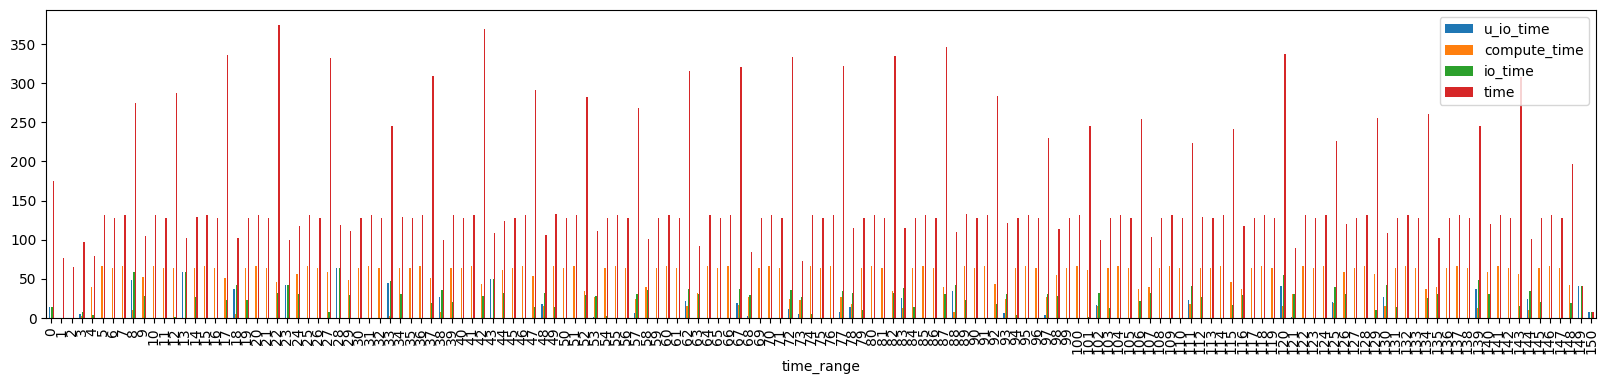

time: 5.09 s (started: 2024-11-25 17:40:21 -08:00)


In [41]:
result.views['APP'][('time_range',)].compute()[['u_io_time', 'compute_time', 'io_time', 'time']].sort_index().plot(kind='bar',figsize=(20, 4))

<Axes: xlabel='time_range'>

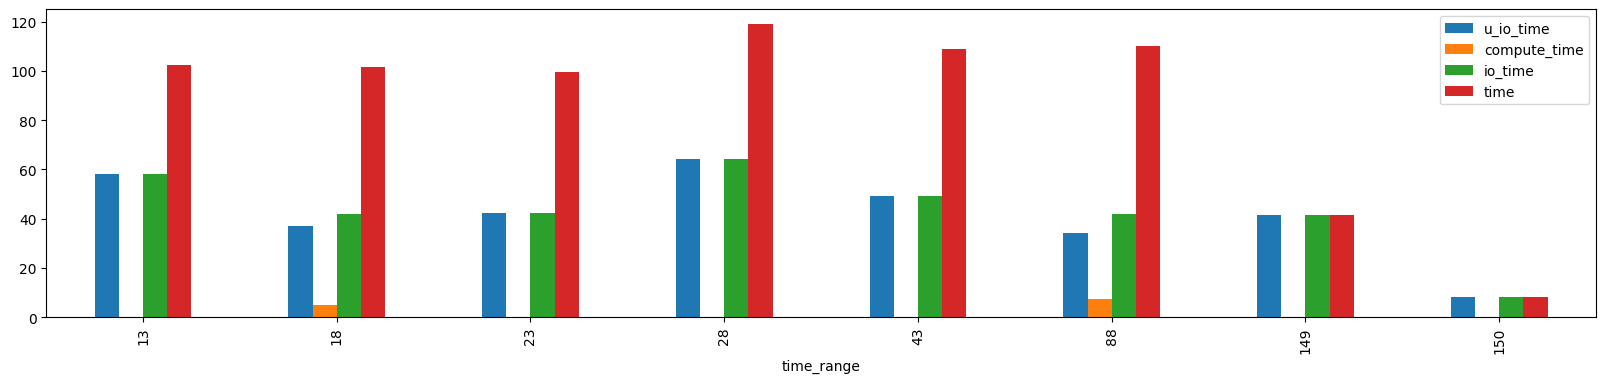

time: 241 ms (started: 2024-11-25 17:39:59 -08:00)


In [40]:
result.bottlenecks['APP'][('time_range',)]['u_io_time_per'].compute()[['u_io_time', 'compute_time', 'io_time', 'time']].sort_index().plot(kind='bar', figsize=(20, 4))

In [8]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 4.97 s (started: 2024-11-25 11:05:35 -08:00)


In [9]:
bottlenecks = analyzer.read_bottlenecks()
bottlenecks.compute()

subject  app_io_time  checkpoint_io_time  \
0      app#corona188#1522409#1522409  3625.373671         3625.373671   
1      app#corona188#1522409#1522919     7.191257            0.000000   
2      app#corona188#1522409#1523549     7.713886            0.000000   
3      app#corona188#1522409#1524053     6.080547            0.000000   
4      app#corona188#1522409#1524557     8.580186            0.000000   
...                              ...          ...                 ...   
21768  app#corona196#3343091#3343248          0.0            0.000000   
21769    app#corona200#995352#995526          0.0            0.000000   
21770  app#corona204#2393987#2394168          0.0            0.000000   
21771  app#corona207#1099595#1099758          0.0            0.000000   
21772  app#corona213#1009618#1009792          0.0            0.000000   

       compute_time     io_time  read_io_time          time   count  size_min  \
0       7328.422839  528.322504      0.000000  21557.671562  698132         0   
1               0.0     0.39313      3.920243     43.174241   51589         0   
2               0.0    1.204703      4.197591     44.405834   51589         0   
3               0.0    1.068701      3.367220     41.943899   51589         0   
4               0.0    1.248898      4.624437     45.352103   51589         0   
...             ...         ...           ...           ...     ...       ...   
21768           0.0    0.120167      0.000000      0.120167       1         0   
21769           0.0    0.121484      0.000000      0.121484       1         0   
21770           0.0    0.161353      0.000000      0.161353       1         0   
21771           0.0    0.161049      0.000000      0.161049       1         0   
21772           0.0    0.122349      0.000000      0.122349       1         0   

         size_max  ...  b_small_writes_0  b_small_writes_1  b_unoverlapped_io  \
0      1876174876  ...             False              True              False   
1           65537  ...             False              True              False   
2           65537  ...             False              True              False   
3           65537  ...             False              True              False   
4           65537  ...             False              True              False   
...           ...  ...               ...               ...                ...   
21768           0  ...             False              True               <NA>   
21769           0  ...             False              True               <NA>   
21770           0  ...             False              True               <NA>   
21771           0  ...             False              True               <NA>   
21772           0  ...             False              True               <NA>   

       b_unoverlapped_io_0  behavior  layer     metric  view_depth  \
0                    False        -1    APP  intensity           1   
1                    False         0    APP  intensity           1   
2                    False         0    APP  intensity           1   
3                    False         0    APP  intensity           1   
4                    False         0    APP  intensity           1   
...                    ...       ...    ...        ...         ...   
21768                 <NA>         4  POSIX        ops           2   
21769                 <NA>         4  POSIX        ops           2   
21770                 <NA>         4  POSIX        ops           2   
21771                 <NA>         4  POSIX        ops           2   
21772                 <NA>         4  POSIX        ops           2   

                  view_name  step  
0                 proc_name  <NA>  
1                 proc_name  <NA>  
2                 proc_name  <NA>  
3                 proc_name  <NA>  
4                 proc_name  <NA>  
...                     ...   ...  
21768  time_range.proc_name     0  
21769  time_range.proc_name     0  
21770  time_range.proc_name     0  
21771

time: 6.89 s (started: 2024-11-25 11:05:42 -08:00)


In [13]:
from wisio.plots import plot_layer_bottlenecks, get_bottleneck_columns, plot_bottlenecks

bot_cols = get_bottleneck_columns(bottlenecks)
df = bottlenecks.query('view_depth == 1').groupby(['layer', 'view_name'])[bot_cols].sum().compute().reset_index()
df['layer_view_name'] = '(' + df['layer'] + ', ' + df['view_name'] + ')'
df

layer   view_name  b_excessive_metadata_access  b_operation_imbalance  \
0         APP   proc_name                         8945                   4741   
1         APP  time_range                            0                     62   
2  DATALOADER   proc_name                         2107                     37   
3  DATALOADER  time_range                           24                     38   
4       POSIX   proc_name                         2107                     37   
5       POSIX  time_range                           26                     39   

   b_random_operations  b_size_imbalance  b_small_reads  b_small_writes  \
0                    0               768              0               0   
1                    0                77              0               2   
2                    0                 0              0              16   
3                    0                69              4              30   
4                    0                 0              0              29   
5                    0                69              4              30   

   b_unoverlapped_io           layer_view_name  
0              51981          (APP, proc_name)  
1                  6         (APP, time_range)  
2                  0   (DATALOADER, proc_name)  
3                  0  (DATALOADER, time_range)  
4                  0        (POSIX, proc_name)  
5                  0       (POSIX, time_range)

time: 892 ms (started: 2024-11-10 16:41:31 -08:00)


In [14]:
df['layer_view_name']

0            (APP, proc_name)
1           (APP, time_range)
2     (DATALOADER, proc_name)
3    (DATALOADER, time_range)
4          (POSIX, proc_name)
5         (POSIX, time_range)
Name: layer_view_name, dtype: object

time: 3.05 ms (started: 2024-11-10 16:41:33 -08:00)


In [15]:
bot_cols

['b_excessive_metadata_access',
 'b_operation_imbalance',
 'b_random_operations',
 'b_size_imbalance',
 'b_small_reads',
 'b_small_writes',
 'b_unoverlapped_io']

time: 2.12 ms (started: 2024-11-10 16:41:34 -08:00)


In [41]:
import dask.dataframe as dd

def plot_bottlenecks(bottlenecks: dd.DataFrame, groupby: tuple, view_depth=1):
    bot_cols = get_bottleneck_columns(bottlenecks)
    df = bottlenecks.query(f"view_depth == {view_depth}")
    group_df = df.groupby(list(groupby))[bot_cols].sum().compute()
    group_df = group_df.reset_index()
    group_df['group_id'] = list(map(str, zip(*(group_df[col] for col in groupby))))
    # return group_df
    x_range = list(group_df['group_id'])
    colors = [
        "#" + ''.join([random.choice('0123456789abcdef') for _ in range(6)])
        for _ in bot_cols
    ]
    p = figure(x_range=x_range, tools="hover", tooltips="$name: @$name")
    p.vbar_stack(
        bot_cols,
        x='group_id',
        width=0.8,
        fill_color=colors,
        line_color='black',
        source=ColumnDataSource(group_df),
        legend_label=bot_cols,
    )
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = math.pi / 2
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    return p

time: 1.91 ms (started: 2024-11-10 16:46:11 -08:00)


In [42]:
list(map(str, zip(*(df[col] for col in ('view_name', 'layer')))))

["('proc_name', 'APP')",
 "('time_range', 'APP')",
 "('proc_name', 'DATALOADER')",
 "('time_range', 'DATALOADER')",
 "('proc_name', 'POSIX')",
 "('time_range', 'POSIX')"]

time: 2.56 ms (started: 2024-11-10 16:46:11 -08:00)


In [50]:
from wisio.plots import plot_bottleneck_summary

show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name')))

ImportError: cannot import name 'plot_bottleneck_summary' from 'wisio.plots' (/g/g91/izzet/projects/wisio/wisio/plots.py)

time: 20.1 ms (started: 2024-11-10 16:53:11 -08:00)


In [48]:
show(plot_bottlenecks(bottlenecks, groupby=('view_name', 'metric')))

time: 472 ms (started: 2024-11-10 16:48:13 -08:00)


In [37]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ["2015", "2016", "2017"]
colors = ["#c9d9d3", "#718dbf", "#e84d60"]

data = {'fruits' : fruits,
        '2015'   : [2, 1, 4, 3, 2, 4],
        '2016'   : [5, 3, 4, 2, 4, 6],
        '2017'   : [3, 2, 4, 4, 5, 3]}

p = figure(x_range=fruits, height=250, title="Fruit Counts by Year",
           toolbar_location=None, tools="hover", tooltips="$name @fruits: @$name")

p.vbar_stack(years, x='fruits', width=0.9, color=colors, source=data,
             legend_label=years)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

Loading BokehJS ...

time: 157 ms (started: 2024-11-10 16:04:14 -08:00)


In [18]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
import dask.dataframe as dd
import pandas as pd

output_notebook()  # For displaying Bokeh plots inline in Jupyter notebooks

def plot_layer_bottlenecks_bokeh(bottlenecks: dd.DataFrame):
    bot_cols = get_bottleneck_columns(bottlenecks)
    
    # Summing up bottleneck columns grouped by 'layer' and 'view_name'
    df = bottlenecks.groupby(['layer', 'view_name'])[bot_cols].sum().compute()
    df = df.reset_index()  # Reset index to make 'layer' and 'view_name' columns

    # Pivot the DataFrame to make each bottleneck column a separate series
    # This fills missing values with 0 to ensure consistency across all 'layer' and 'view_name' pairs
    df_pivoted = df.pivot_table(index='layer', columns='view_name', values=bot_cols, fill_value=0)
    
    # Flatten the columns
    df_pivoted.columns = ['_'.join(map(str, col)) for col in df_pivoted.columns]
    df_pivoted = df_pivoted.reset_index()
    
    # Convert data to a format suitable for Bokeh
    source = ColumnDataSource(df_pivoted)
    
    # Prepare x_range with unique layers
    p = figure(x_range=df_pivoted['layer'].astype(str).unique(),  # Unique layers as x-axis categories
               height=400, 
               title="Stacked Bottlenecks per Layer and View",
               toolbar_location=None, 
               tools="")

    # Stack the bottleneck columns
    colors = ["#c9d9d3", "#718dbf", "#e84d60", "#ddb7b1"][:len(bot_cols)]  # Adjust colors as needed for each bot_col

    # Plot each bottleneck column in stacked form
    p.vbar_stack(bot_cols, x='layer', width=0.9, color=colors, source=source, legend_label=bot_cols)

    # Customize the plot
    p.y_range.start = 0
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.title = "Bottlenecks"
    p.legend.label_text_font_size = "10pt"
    p.xaxis.axis_label = "Layer"
    p.yaxis.axis_label = "Total Bottleneck Value"

    show(p)

plot_layer_bottlenecks_bokeh(bottlenecks)

Loading BokehJS ...

ValueError: Keyword argument sequences for broadcasting must all be the same lengths. Got lengths: [4, 7]

time: 225 ms (started: 2024-11-10 15:54:56 -08:00)


In [11]:
bottleneck_rules = list(result.bottleneck_rules.keys())
bottleneck_cols = [f"b_{rule}" for rule in bottleneck_rules]
bottleneck_cols

['b_excessive_metadata_access',
 'b_operation_imbalance',
 'b_random_operations',
 'b_size_imbalance',
 'b_small_reads',
 'b_small_writes',
 'b_unoverlapped_io']

time: 3.11 ms (started: 2024-11-10 15:44:52 -08:00)


In [7]:
"b_excessive_metadata_access_0"[-1].isnumeric()

True

In [15]:
plot_df = result.flat_bottlenecks.groupby(['layer', 'view_name'])[bottleneck_cols].sum().compute()
plot_df

b_excessive_metadata_access  \
layer      view_name                                           
APP        proc_name                                    8945   
           time_range                                      0   
           proc_name.time_range                            0   
           time_range.proc_name                         1160   
DATALOADER proc_name                                    2107   
           time_range                                     24   
           proc_name.time_range                           16   
           time_range.proc_name                         2107   
POSIX      proc_name                                    2107   
           time_range                                     26   
           proc_name.time_range                           17   
           time_range.proc_name                         2107   

                                 b_operation_imbalance  b_random_operations  \
layer      view_name                                                          
APP        proc_name                              4741                    0   
           time_range                               62                    0   
           proc_name.time_range                      4                    0   
           time_range.proc_name                   1004                    0   
DATALOADER proc_name                                37                    0   
           time_range                               38                    0   
           proc_name.time_range                     22                    0   
           time_range.proc_name                      5                    0   
POSIX      proc_name                                37                    0   
           time_range                               39                    0   
           proc_name.time_range                     22                    0   
           time_range.proc_name                      5                    0   

                                 b_size_imbalance  b_small_reads  \
layer      view_name                                               
APP        proc_name                          768              0   
           time_range                          77              0   
           proc_name.time_range                 3              0   
           time_range.proc_name               620              0   
DATALOADER proc_name                            0              0   
           time_range                          69              4   
           proc_name.time_range                17              3   
           time_range.proc_name                 0              0   
POSIX      proc_name                            0              0   
           time_range                          69              4   
           proc_name.time_range                17              3   
           time_range.proc_name                 0              0   

                                 b_small_writes  b_unoverlapped_io  
layer      view_name                                                
APP        proc_name                          0              51981  
           time_range                         2                  6  
           proc_name.time_range               2                  2  
           time_range.proc_name               0               6343  
DATALOADER proc_name                         16                  0  
           time_range                        30                  0  
           proc_name.time_range              16                  0  
           time_range.proc_name               0                  0  
POSIX      proc_name                         29                  0  
           time_range                        30                  0  
           proc_name.time_range              16                  0  
           time_range.proc_name               0                  0

time: 577 ms (started: 2024-11-10 09:44:57 -08:00)


In [1]:
plot_df.plot.bar(stacked=True)

NameError: name 'plot_df' is not defined

In [54]:
merged_bottlenecks.memory_usage(deep=True).sum().compute() / 1024**2

117.34580039978027

time: 713 ms (started: 2024-11-07 19:10:34 -08:00)


In [ ]:
from wisio.types import humanized_view_name

layer = 'APP'
view_names = [
    humanized_view_name(view_key, '>')
    for view_key in result.bottlenecks[layer]
    if len(view_key) == 1
]
view_names

['Process', 'Time Period']

time: 4.28 ms (started: 2024-11-07 15:31:18 -08:00)


<Axes: >

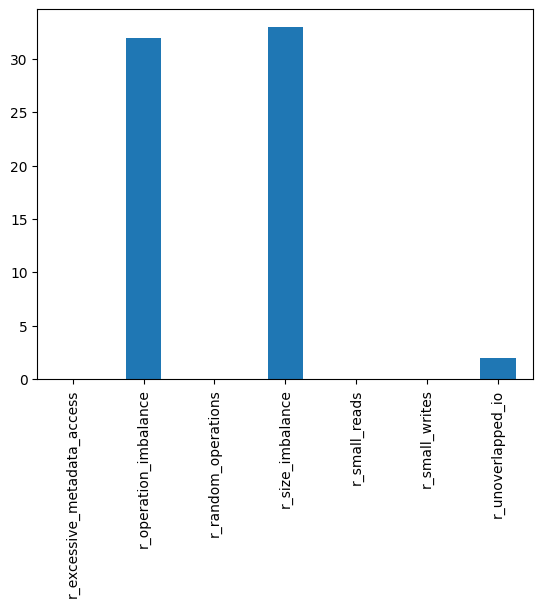

time: 261 ms (started: 2024-11-07 15:17:04 -08:00)


In [ ]:
import matplotlib.pyplot as plt
from wisio.types import humanized_view_name

fig, ax = plt.subplots()

layer = 'APP'
metric = 'io_compute_ratio'
view_names = [humanized_view_name(view_key) for view_key in result.bottlenecks[layer]]
for view_key in result.bottlenecks[layer]:
    view_name = humanized_view_name(view_key, '>')
    if view_name in view_names:
         result.bottlenecks[layer][view_key][metric][bottleneck_cols].sum().sum().compute()
        _ = ax.bar(bottleneck_cols, )

result.bottlenecks['APP'][('time_range',)]['io_compute_ratio'][bottleneck_cols].sum().compute().plot.bar()

<Axes: >

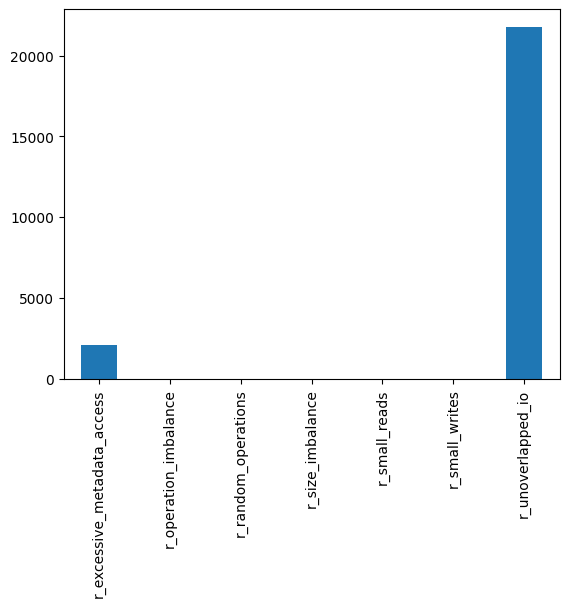

time: 256 ms (started: 2024-11-07 15:16:32 -08:00)


In [29]:
result.bottlenecks['POSIX'][('proc_name',)]['iops'][bottleneck_cols].sum().compute().plot.bar()

In [25]:
len(result.bottlenecks['APP'][('proc_name',)]['ops'][bottleneck_cols].query('r_excessive_metadata_access == True'))

2107

time: 63.2 ms (started: 2024-11-07 15:15:30 -08:00)


In [ ]:
main_index = result.main_views['APP'].index.to_frame().reset_index(drop=True)
main_index

proc_name  time_range
0  app#corona188#1522409#1522409           9
1  app#corona188#1522409#1522409          13
2  app#corona188#1522409#1522409          18
3  app#corona188#1522409#1522409          33
4  app#corona188#1522409#1522409          44

time: 48.4 ms (started: 2024-11-07 15:14:44 -08:00)


In [15]:
result.bottlenecks['APP'][('time_range',)]['io_compute_ratio'].head()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
9              0.816714            0.000000     51.890154  28.451443   
18            62.003996           62.003996      4.885419  41.738577   
33           121.708939          121.708939      2.442485  46.942319   
44             0.676508            0.000000     61.262515  31.955866   
52           125.272967          125.272967     34.194666  28.846449   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
9               0.816714  105.134253   359903         0    67108864   
18              0.528016  101.756172  2365978         0  1876172080   
33              0.005204  245.301125  2337620         0  1876172476   
44              0.676508  123.776138   420130         0    67108864   
52              0.015365  282.883495   216237         0  1875124300   

                     size  ...  b_size_imbalance_0  b_size_imbalance_1  \
time_range                 ...                                           
9           1532610290234  ...                True               False   
18          1253424785740  ...                True               False   
33          1642505823773  ...               False                True   
44          1532645824579  ...                True               False   
52           763713662262  ...               False                True   

            b_small_reads  b_small_reads_0  b_small_reads_1  b_small_writes  \
time_range                                                                    
9                   False            False            False           False   
18                  False            False             True           False   
33                  False            False             True           False   
44                  False            False            False           False   
52                  False            False             True           False   

            b_small_writes_0  b_small_writes_1  b_unoverlapped_io  \
time_range                                                          
9                      False             False              False   
18                     False              True               True   
33                     False              True              False   
44                     False             False              False   
52                     False             False              False   

            b_unoverlapped_io_0  
time_range                       
9                         False  
18                         True  
33                        False  
44                        False  
52                        False  

[5 rows x 92 columns]

time: 70 ms (started: 2024-11-07 13:27:15 -08:00)


In [16]:
for layer in result.bottlenecks:
    for view_key in result.bottlenecks[layer]:
        for metric in result.bottlenecks[layer][view_key]:
            print(layer, view_key, metric, len(result.bottlenecks[layer][view_key][metric]))

APP ('proc_name',) io_compute_ratio 0
APP ('proc_name',) io_time 128
APP ('proc_name',) ops 21773
APP ('proc_name',) u_checkpoint_io_time 0
APP ('proc_name',) u_io_time 30208
APP ('proc_name',) u_read_io_time 0
APP ('time_range',) io_compute_ratio 58
APP ('time_range',) io_time 0
APP ('time_range',) ops 106
APP ('time_range',) u_checkpoint_io_time 27
APP ('time_range',) u_io_time 8
APP ('time_range',) u_read_io_time 0
APP ('proc_name', 'time_range') io_compute_ratio 0
APP ('proc_name', 'time_range') io_time 0
APP ('proc_name', 'time_range') ops 11
APP ('proc_name', 'time_range') u_checkpoint_io_time 0
APP ('proc_name', 'time_range') u_io_time 4
APP ('proc_name', 'time_range') u_read_io_time 0
APP ('time_range', 'proc_name') io_compute_ratio 0
APP ('time_range', 'proc_name') io_time 0
APP ('time_range', 'proc_name') ops 2843
APP ('time_range', 'proc_name') u_checkpoint_io_time 0
APP ('time_range', 'proc_name') u_io_time 3500
APP ('time_range', 'proc_name') u_read_io_time 0
POSIX ('proc_

In [10]:
len(main_index)

262773

time: 258 ms (started: 2024-11-07 13:08:23 -08:00)


In [11]:
result.view_types

['proc_name', 'time_range']

time: 3.76 ms (started: 2024-11-07 13:08:24 -08:00)


In [ ]:
import dask.dataframe as dd
import pandas as pd
from wisio.types import BottleneckRules


def _set_bottleneck_reasons(bottlenecks: pd.DataFrame, rules: BottleneckRules):
    # print('_set_bottleneck_reasons', rules)
    for rule_key, rule_def in rules.items():
        rule_result = bottlenecks.eval(rule_def.condition)
        rule_result.name = f"b_{rule_key}"
        bottlenecks = bottlenecks.join(rule_result)
        for i, reason in enumerate(rule_def.reasons):
            reason_result = bottlenecks.eval(reason.condition)
            reason_result.name = f"b_{rule_key}_{i}"
            bottlenecks = bottlenecks.join(reason_result)
    return bottlenecks


view_types = result.view_types
bottlenecks = result.bottlenecks
reasoned_bottlenecks = {}
for layer in bottlenecks:
    reasoned_bottlenecks[layer] = {}
    for view_key in bottlenecks[layer]:
        reasoned_bottlenecks[layer][view_key] = {}
        for metric in bottlenecks[layer][view_key]:
            view = bottlenecks[layer][view_key][metric] #.copy()
            view_index = main_index #.copy()
            for view_type in view_key:
                view_index = view_index.query(
                    f"{view_type} in @index",
                    local_dict={
                        "index": bottlenecks[layer][(view_type,)][metric].index
                    },
                )
            view_type = view_key[-1]
            for detail_view_type in view_types:
                detail_view = view_index.groupby(view_type)[detail_view_type].nunique()
                detail_view.name = f"n_{detail_view_type}"
                view = view.merge(detail_view.to_frame())
            print(layer, view_key, metric, view_type, list(view.columns))
            reasoned_bottlenecks[layer][view_key][metric] = view.map_partitions(
                _set_bottleneck_reasons,
                rules=cfg.bottleneck_rules,
            )

reasoned_bottlenecks

In [22]:
dask.visualize(reasoned_bottlenecks['APP'][('time_range',)])

time: 6.13 s (started: 2024-11-07 13:14:03 -08:00)


In [14]:
import dask

(reasoned_bottlenecks_c,) = dask.compute(reasoned_bottlenecks)

time: 19.6 s (started: 2024-11-07 13:10:14 -08:00)


In [26]:
reasoned_bottlenecks_c['APP'][('time_range',)]['io_compute_ratio'].columns

Index(['app_io_time', 'checkpoint_io_time', 'compute_time', 'io_time',
       'read_io_time', 'time', 'count', 'size_min', 'size_max', 'size',
       'read_time', 'write_time', 'metadata_time', 'read_size', 'write_size',
       'metadata_size', 'read_count', 'write_count', 'metadata_count',
       'read_min', 'read_max', 'write_min', 'write_max', 'metadata_min',
       'metadata_max', 'data_count', 'data_size', 'data_time',
       'sequential_time', 'random_time', 'sequential_size', 'random_size',
       'sequential_count', 'random_count', 'close_time', 'open_time',
       'seek_time', 'stat_time', 'close_count', 'open_count', 'seek_count',
       'stat_count', 'u_app_io_time', 'u_checkpoint_io_time', 'u_compute_time',
       'u_io_time', 'u_read_io_time', 'u_read_time', 'u_write_time',
       'u_metadata_time', 'u_data_time', 'u_sequential_time', 'u_random_time',
       'u_close_time', 'u_open_time', 'u_seek_time', 'u_stat_time',
       'u_app_compute_time', 'io_compute_ratio', 'time_

time: 5.06 ms (started: 2024-11-07 13:16:54 -08:00)


In [27]:
reasoned_bottlenecks_c['APP'][('time_range',)]['io_compute_ratio'][['compute_time', 'io_time', 'io_compute_ratio_score', 'n_proc_name', 'n_time_range', 'b_unoverlapped_io']]

compute_time    io_time io_compute_ratio_score  n_proc_name  \
time_range                                                                
9              51.890154  28.451443                   high         2624   
18              4.885419  41.738577               critical         1600   
33              2.442485  46.942319               critical          384   
44             61.262515  31.955866                   high         2624   
52             34.194666  28.846449              very high         1664   
57             24.424778  31.189504               critical         1664   
78             17.301767  31.637252               critical         2624   
87             39.079642  30.965895              very high         1664   
88              7.388934  41.722664               critical         1820   
97             26.867213  30.769354               critical         1664   
106            36.637195  21.970701                   high         1664   
111             17.30896  40.750744               critical         2624   
121            30.068684  30.887515               critical         2624   
134            36.637118  25.247924                   high         1664   
135            39.442745  30.608076              very high         2624   
140            58.855166  30.166003                   high         2624   
39             63.696239  20.859253                 medium         1792   
82             34.194643  31.815049               critical         1664   
102            14.893572   32.07716               critical         2624   
22             46.407072  31.265364                   high         1664   
62             14.654864  36.946255               critical         1664   
19             63.515972  22.862828                 medium         1792   
68             27.188653   29.26163               critical         2624   
89              66.05211  22.339656                 medium         1792   
107            39.346156   31.56939              very high         2624   
3               2.442508   7.163027               critical         2152   
34             63.611079   30.32777                 medium         2624   
53             27.229352  28.688179               critical         2624   
67             17.097334  36.673759               critical         1664   
120            14.654852  55.020017               critical         1664   
130            15.158051   42.01464               critical         2624   
139            12.212379  48.631567               critical         1408   
144             9.947342  34.572162               critical         2112   
145             63.62705  19.762102                 medium         1792   
98             54.311163  28.019539                   high         2624   
63             31.898648  30.602552               critical         2624   
17             51.291843  22.511973                 medium         1664   
126            59.181154  30.767305                   high         2624   
37              51.29193   19.24826                 medium         1664   
38              8.203183  35.538773               critical         1856   
42             43.964538  28.555801                   high         1664   
58              39.14998  35.117467              very high         2624   
125             19.53981  39.935348               critical         1664   
73             22.414016  27.002252               critical         2624   
83             12.692217  37.896763               critical         2368   
116            36.948448  29.742155              very high         2624   
14             63.740796  26.467682                 medium         2624   
8               9.769895  58.160959               critical         1152   
92             43.964517  18.016493                 medium         1664   
93             24.426854  30.945433               critical         2624   
112            64.011671  26.583692                 medium         1792   
115            46.406962  16.480899  

time: 21.7 ms (started: 2024-11-07 13:17:12 -08:00)


In [13]:
result.views['APP'][('proc_name',)].head()

app_io_time  checkpoint_io_time  compute_time  \
proc_name                                                                      
app#corona188#1522409#1522409  3625.373671         3625.373671   7328.422839   
app#corona188#1522409#1522919     3.920243            0.000000           0.0   
app#corona188#1522409#1523549     4.197591            0.000000           0.0   
app#corona188#1522409#1524053      3.36722            0.000000           0.0   
app#corona188#1522409#1524557     4.624437            0.000000           0.0   

                                  io_time  read_io_time          time   count  \
proc_name                                                                       
app#corona188#1522409#1522409  528.322504      0.000000  21557.671562  698132   
app#corona188#1522409#1522919     0.39313      3.920243     43.174241   51589   
app#corona188#1522409#1523549    1.204703      4.197591     44.405834   51589   
app#corona188#1522409#1524053    1.068701      3.367220     41.943899   51589   
app#corona188#1522409#1524557    1.248898      4.624437     45.352103   51589   

                               size_min    size_max          size  ...  \
proc_name                                                          ...   
app#corona188#1522409#1522409         0  1876174876  386994809272  ...   
app#corona188#1522409#1522919      4051       69587      32631665  ...   
app#corona188#1522409#1523549      4051       69587      32631665  ...   
app#corona188#1522409#1524053      4051       69587      32631665  ...   
app#corona188#1522409#1524557      4051       69587      32631665  ...   

                               u_open_time  u_seek_time  u_stat_time  \
proc_name                                                              
app#corona188#1522409#1522409     0.000000     0.000000     0.000000   
app#corona188#1522409#1522919     0.077179     0.000208     0.080677   
app#corona188#1522409#1523549     0.088814     0.000221     0.028542   
app#corona188#1522409#1524053     0.072823     0.000212     0.030657   
app#corona188#1522409#1524557     0.126714     0.000198     0.005634   

                               u_app_compute_time  io_compute_ratio  \
proc_name                                                             
app#corona188#1522409#1522409         3703.049168          0.072092   
app#corona188#1522409#1522919            0.000000          0.000000   
app#corona188#1522409#1523549            0.000000          0.000000   
app#corona188#1522409#1524053            0.000000          0.000000   
app#corona188#1522409#1524557            0.000000          0.000000   

                               time_normalized  ops_percentile  \
proc_name                                                        
app#corona188#1522409#1522409         9.716214        0.175894   
app#corona188#1522409#1522919         0.019459        0.044271   
app#corona188#1522409#1523549         0.020014        0.047036   
app#corona188#1522409#1524053         0.018904        0.040381   
app#corona188#1522409#1524557         0.020441        0.048129   

                               u_checkpoint_io_time_per  u_io_time_per  \
proc_name                                                                
app#corona188#1522409#1522409                       0.0            0.0   
app#corona188#1522409#1522919                       0.0       0.009106   
app#corona188#1522409#1523549                       0.0       0.027129   
app#corona188#1522409#1524053                       0.0       0.025479   
app#corona188#1522409#1524557                       0.0       0.027538   

                               u_read_io_time_per  
proc_name                                          
app#corona188#1522409#1522409            0.000000  
app#corona188#1522409#1522919            0.090801  
app#corona188#1522409#1523549            0.094528  
app#corona188#1522409#1524053            0.080279  
app#corona188#1522409#1524557            0.101967  

[5 rows x 64 columns]

time: 721 ms (started: 2024-11-06 22:44:30 -08:00)


In [10]:
result.bottlenecks[Layer.APP][('proc_name','time_range')]['u_io_time'].head()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
13            58.968286           58.968286           0.0  58.118105   
18            62.003996           62.003996      4.885419  41.738577   
88            49.849793           49.849793      7.388934  41.722664   
149                 0.0            0.000000           0.0  41.397566   
150                 0.0            0.000000           0.0   8.242917   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
13              0.000000  102.253561  2319908        67  1876171776   
18              0.528016  101.756172  2365978         0  1876172080   
88              0.797077  109.958346  2377078         0    67108864   
149             0.000000   41.397566  2208035       164    67108864   
150             0.000000    8.242917    50828        69    67108864   

                     size  ...  b_size_imbalance_0  b_size_imbalance_1  \
time_range                 ...                                           
13          1517345590517  ...                True               False   
18          1253424785740  ...                True               False   
88          1315434680580  ...                True               False   
149         2343269401721  ...                True               False   
150            8466856006  ...               False                True   

            b_small_reads  b_small_reads_0  b_small_reads_1  b_small_writes  \
time_range                                                                    
13                  False            False             True           False   
18                  False            False             True           False   
88                  False            False             True           False   
149                 False            False             True            True   
150                 False            False             True            True   

            b_small_writes_0  b_small_writes_1  b_unoverlapped_io  \
time_range                                                          
13                     False              True               True   
18                     False              True               True   
88                     False              True               True   
149                     True              True               True   
150                     True              True               True   

            b_unoverlapped_io_0  
time_range                       
13                         True  
18                         True  
88                         True  
149                        True  
150                        True  

[5 rows x 91 columns]

time: 803 ms (started: 2024-11-06 22:30:11 -08:00)


In [23]:
bottlenecks['APP'][('time_range',)].keys()

dict_keys(['io_compute_ratio', 'io_time', 'ops', 'u_checkpoint_io_time', 'u_io_time', 'u_read_io_time'])

time: 2.48 ms (started: 2024-11-06 11:43:00 -08:00)


In [24]:
bottlenecks['APP'][('time_range',)]['io_compute_ratio'].head()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
9              0.816714            0.000000     51.890154  28.451443   
18            62.003996           62.003996      4.885419  41.738577   
33           121.708939          121.708939      2.442485  46.942319   
44             0.676508            0.000000     61.262515  31.955866   
52           125.272967          125.272967     34.194666  28.846449   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
9               0.816714  105.134253   359903         0    67108864   
18              0.528016  101.756172  2365978         0  1876172080   
33              0.005204  245.301125  2337620         0  1876172476   
44              0.676508  123.776138   420130         0    67108864   
52              0.015365  282.883495   216237         0  1875124300   

                     size  ...  ops_percentile  u_checkpoint_io_time_per  \
time_range                 ...                                             
9           1532610290234  ...        0.271523                  0.000000   
18          1253424785740  ...         0.05298                  0.561328   
33          1642505823773  ...         0.18543                  0.486204   
44          1532645824579  ...        0.284768                  0.000000   
52           763713662262  ...        0.960265                  0.321964   

            u_io_time_per  u_read_io_time_per  io_compute_ratio_score  \
time_range                                                              
9                     0.0                 0.0                    high   
18               0.362171                 0.0                critical   
33               0.181409                 0.0                critical   
44                    0.0                 0.0                    high   
52                    0.0                 0.0               very high   

            time_score  ops_score  u_checkpoint_io_time_score  \
time_range                                                      
9             very low     medium                        none   
18            very low   very low                        high   
33                 low        low                      medium   
44            very low     medium                        none   
52                 low   critical                      medium   

            u_io_time_score  u_read_io_time_score  
time_range                                         
9                      none                  none  
18                   medium                  none  
33                      low                  none  
44                     none                  none  
52                     none                  none  

[5 rows x 70 columns]

time: 43.2 ms (started: 2024-11-06 11:43:02 -08:00)


In [19]:
main_view_ids = result.main_views['APP'].index.to_frame().reset_index(drop=True)
main_view_ids.head()

proc_name  time_range
0  app#corona188#1522409#1522409           9
1  app#corona188#1522409#1522409          13
2  app#corona188#1522409#1522409          18
3  app#corona188#1522409#1522409          33
4  app#corona188#1522409#1522409          44

time: 222 ms (started: 2024-11-06 11:42:56 -08:00)


In [20]:
len(result.main_views['APP'].reset_index()['proc_name'].unique())

31104

time: 293 ms (started: 2024-11-06 11:42:56 -08:00)


In [21]:
len(result.evaluated_views['APP'][('proc_name',)].index)

31104

time: 528 ms (started: 2024-11-06 11:42:56 -08:00)


In [22]:
view_ids = {}
for layer in bottlenecks:
    view_ids[layer] = {}
    for view_key in bottlenecks[layer]:
        view_ids[layer][view_key] = {}
        for metric in bottlenecks[layer][view_key]:
            view_ids[layer][view_key][metric] = None
            view = bottlenecks[layer][view_key][metric]
            print("V", layer, metric, view_key, parent_view_key, len(bottlenecks[layer][view_key][metric].index))
            # print(view_key)
            # print(len(view.index))
            parent_view_key = view_key[:-1]
            while parent_view_key:
                print("P", layer, metric, view_key, parent_view_key, len(bottlenecks[layer][parent_view_key][metric].index))
                # print(bottlenecks[layer][parent_view_key][metric].index.head())
                parent_view_key = parent_view_key[:-1]
            break

NameError: name 'parent_view_key' is not defined

time: 212 ms (started: 2024-11-06 11:42:57 -08:00)


In [ ]:
bot_tr_icr = bottlenecks['APP'][('time_range',)]['io_compute_ratio']
bot_tr_icr.head()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
9              0.816714            0.000000     51.890154  28.451443   
18            62.003996           62.003996      4.885419  41.738577   
33           121.708939          121.708939      2.442485  46.942319   
44             0.676508            0.000000     61.262515  31.955866   
52           125.272967          125.272967     34.194666  28.846449   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
9               0.816714  105.134253   359903         0    67108864   
18              0.528016  101.756172  2365978         0  1876172080   
33              0.005204  245.301125  2337620         0  1876172476   
44              0.676508  123.776138   420130         0    67108864   
52              0.015365  282.883495   216237         0  1875124300   

                     size  ...  ops_percentile  u_checkpoint_io_time_per  \
time_range                 ...                                             
9           1532610290234  ...        0.271523                  0.000000   
18          1253424785740  ...         0.05298                  0.561328   
33          1642505823773  ...         0.18543                  0.486204   
44          1532645824579  ...        0.284768                  0.000000   
52           763713662262  ...        0.960265                  0.321964   

            u_io_time_per  u_read_io_time_per  io_compute_ratio_score  \
time_range                                                              
9                     0.0                 0.0                    high   
18               0.362171                 0.0                critical   
33               0.181409                 0.0                critical   
44                    0.0                 0.0                    high   
52                    0.0                 0.0               very high   

            time_score  ops_score  u_checkpoint_io_time_score  \
time_range                                                      
9             very low     medium                        none   
18            very low   very low                        high   
33                 low        low                      medium   
44            very low     medium                        none   
52                 low   critical                      medium   

            u_io_time_score  u_read_io_time_score  
time_range                                         
9                      none                  none  
18                   medium                  none  
33                      low                  none  
44                     none                  none  
52                     none                  none  

[5 rows x 70 columns]

time: 1.97 s (started: 2024-11-06 11:28:57 -08:00)


In [ ]:
tr_ids = bottlenecks['APP'][('time_range',)]['io_compute_ratio'].index.compute()
tr_ids

Index([  9,  18,  33,  44,  52,  57,  78,  87,  88,  97, 106, 111, 121, 134,
       135, 140,  39,  82, 102,  22,  62,  19,  68,  89, 107,   3,  34,  53,
        67, 120, 130, 139, 144, 145,  98,  63,  17, 126,  37,  38,  42,  58,
       125,  73,  83, 116,  14,   8,  92,  93, 112, 115,  72,  29,  24,  48,
        77, 148],
      dtype='uint16', name='time_range')

time: 1.78 s (started: 2024-11-06 09:02:34 -08:00)


In [ ]:
tr_pn_id= main_view_ids.query('time_range in @tr_ids', local_dict={"tr_ids": tr_ids}).groupby('time_range')['proc_name'].nunique()
tr_pn_id.head()

time_range
3     2152
8     1152
9     2624
14    2624
17    1664
Name: proc_name, dtype: int64

time: 249 ms (started: 2024-11-06 11:29:37 -08:00)


In [ ]:
tr_pn_id.name

'num_proc_name'

time: 2.04 ms (started: 2024-11-06 11:31:56 -08:00)


In [ ]:
tr_pn_id.name = 'num_proc_name'
tr_pn_id.head()

time_range
3     2152
8     1152
9     2624
14    2624
17    1664
Name: num_proc_name, dtype: int64

time: 240 ms (started: 2024-11-06 11:30:28 -08:00)


In [ ]:
tr_pn_id.to_frame().head()

num_proc_name
time_range               
3                    2152
8                    1152
9                    2624
14                   2624
17                   1664

time: 363 ms (started: 2024-11-06 11:31:11 -08:00)


In [ ]:
bot_tr_icr.merge(tr_pn_id.to_frame()).head()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
9              0.816714            0.000000     51.890154  28.451443   
18            62.003996           62.003996      4.885419  41.738577   
33           121.708939          121.708939      2.442485  46.942319   
44             0.676508            0.000000     61.262515  31.955866   
52           125.272967          125.272967     34.194666  28.846449   

            read_io_time        time    count  size_min    size_max  \
time_range                                                            
9               0.816714  105.134253   359903         0    67108864   
18              0.528016  101.756172  2365978         0  1876172080   
33              0.005204  245.301125  2337620         0  1876172476   
44              0.676508  123.776138   420130         0    67108864   
52              0.015365  282.883495   216237         0  1875124300   

                     size  ...  u_checkpoint_io_time_per  u_io_time_per  \
time_range                 ...                                            
9           1532610290234  ...                  0.000000            0.0   
18          1253424785740  ...                  0.561328       0.362171   
33          1642505823773  ...                  0.486204       0.181409   
44          1532645824579  ...                  0.000000            0.0   
52           763713662262  ...                  0.321964            0.0   

            u_read_io_time_per  io_compute_ratio_score  time_score  ops_score  \
time_range                                                                      
9                          0.0                    high    very low     medium   
18                         0.0                critical    very low   very low   
33                         0.0                critical         low        low   
44                         0.0                    high    very low     medium   
52                         0.0               very high         low   critical   

            u_checkpoint_io_time_score  u_io_time_score  u_read_io_time_score  \
time_range                                                                      
9                                 none             none                  none   
18                                high           medium                  none   
33                              medium              low                  none   
44                                none             none                  none   
52                              medium             none                  none   

            num_proc_name  
time_range                 
9                    2624  
18                   1600  
33                    384  
44                   2624  
52                   1664  

[5 rows x 71 columns]

time: 2.16 s (started: 2024-11-06 11:31:25 -08:00)


In [ ]:
result.main_views['APP'].reset_index()['time_range'].nunique().compute()

151

time: 195 ms (started: 2024-11-06 09:00:25 -08:00)


In [ ]:
result.main_views['APP'].groupby()

app_io_time  checkpoint_io_time  \
proc_name                     time_range                                    
app#corona188#1522409#1522409 9                   0.0            0.000000   
                              13            53.989218           53.989218   
                              18            61.481355           61.481355   
                              33           115.347277          115.347277   
                              44                  0.0            0.000000   

                                          compute_time    io_time  \
proc_name                     time_range                            
app#corona188#1522409#1522409 9              51.289857   0.035287   
                              13                   0.0   14.53083   
                              18              4.884948   7.377895   
                              33              2.442458  20.575547   
                              44             61.093925   0.314422   

                                          read_io_time        time  count  \
proc_name                     time_range                                    
app#corona188#1522409#1522409 9                    0.0  104.554369    289   
                              13                   0.0   69.839653  18249   
                              18                   0.0   79.126254  18382   
                              33                   0.0  219.000549  18278   
                              44                   0.0  123.722653    386   

                                          size_min    size_max         size  \
proc_name                     time_range                                      
app#corona188#1522409#1522409 9                154       30734        54693   
                              13               684  1876171776  11888304762   
                              18               366    53477680   7009948333   
                              33              1384  1876172476  12897597823   
                              44               866       31439       113676   

                                          ...  u_metadata_time  u_data_time  \
proc_name                     time_range  ...                                 
app#corona188#1522409#1522409 9           ...         0.028735     0.003624   
                              13          ...         2.377248    12.153518   
                              18          ...         1.336218     6.040693   
                              33          ...         1.720884    18.854134   
                              44          ...         0.304969     0.004872   

                                          u_sequential_time  u_random_time  \
proc_name                     time_range                                     
app#corona188#1522409#1522409 9                    0.003624            0.0   
                              13                  12.153518            0.0   
                              18                   6.040693            0.0   
                              33                  18.854134            0.0   
                              44                   0.004872            0.0   

                                          u_close_time  u_open_time  \
proc_name                     time_range                              
app#corona188#1522409#1522409 9               0.000959     0.008610   
                              13              0.000277     0.002406   
                              18              0.004867     0.041305   
                              33              0.000201     0.002963   
                              44              0.003528     0.034016   

                                          u_seek_time  u_stat_time  \
proc_name                     time_range                             
app#corona188#1522409#1522409 9              0.000005     0.010842   
                              13             0.010499     1.319896   
                              18             

time: 238 ms (started: 2024-11-05 21:35:27 -08:00)


In [ ]:
import dask
import dask.dataframe as dd
import pandas as pd
from wisio.constants import Layer
from wisio.rules import KNOWN_RULES, BottleneckRule
from wisio.types import BottleneckResults, Metric, ViewKey
from typing import Dict, List


def _assign_reasons(
    bottlenecks: pd.DataFrame,
    metric: Metric,
    rules: Dict[str, BottleneckRule],
    view_key: ViewKey,
    view_ids: pd.Index,
):
    print(view_ids)
    for rule, impl in rules.items():
        rule_result = bottlenecks.eval(impl.rule.condition)
        rule_result.name = f"b_{rule}"
        bottlenecks = bottlenecks.join(rule_result)

        for i, reason in enumerate(impl.rule.reasons):
            reason_result = bottlenecks.eval(reason.condition)
            reason_result.name = f"b_{rule}_r{i}"
            bottlenecks = bottlenecks.join(reason_result)
        # print(rule, rule_result)
    return bottlenecks


def reason_bottlenecks(
    bottlenecks: Dict[Layer, BottleneckResults],
    main_view_ids: dd.DataFrame,
    exclude_bottlenecks: List[str] = [],
):
    rule_dict = {
        rule: BottleneckRule(rule_key=rule, rule=KNOWN_RULES[rule], verbose=True)
        for rule in KNOWN_RULES
        if rule not in exclude_bottlenecks
    }

    view_ids = {}
    for layer in bottlenecks:
        view_ids[layer] = {}
        for view_key in bottlenecks[layer]:
            view = bottlenecks[layer][view_key]
            parent_view_key = view_key[:-1]
            while parent_view_key:
                print(layer, view_key, parent_view_key)
                parent_view_key = parent_view_key[:-1]

            # view_ids[layer][view_key] =

    reasoned_bottlenecks = []
    for layer in bottlenecks:
        for view_key in bottlenecks[layer]:
            for metric in bottlenecks[layer][view_key]:
                reasoned_bottlenecks.append(
                    bottlenecks[layer][view_key][metric].map_partitions(
                        _assign_reasons,
                        metric=metric,
                        rules=rule_dict,
                        view_key=view_key,
                    )
                )
                break

    return reasoned_bottlenecks


(bottlenecks2, main_view_ids2) = dask.persist(bottlenecks, main_view_ids)
reasoned_bottlenecks = reason_bottlenecks(bottlenecks2, main_view_ids2)
len(reasoned_bottlenecks)

APP ('proc_name', 'time_range') ('proc_name',)
APP ('time_range', 'proc_name') ('time_range',)
POSIX ('proc_name', 'time_range') ('proc_name',)
POSIX ('time_range', 'proc_name') ('time_range',)


ValueError: Metadata inference failed in `_assign_reasons`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError("_assign_reasons() missing 1 required positional argument: 'view_ids'")

Traceback:
---------
  File "/g/g91/izzet/projects/wisio/venv-corona/lib/python3.9/site-packages/dask/dataframe/utils.py", line 193, in raise_on_meta_error
    yield
  File "/g/g91/izzet/projects/wisio/venv-corona/lib/python3.9/site-packages/dask/dataframe/core.py", line 6876, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


time: 3.23 s (started: 2024-11-05 20:20:53 -08:00)


In [ ]:
dask.visualize(reasoned_bottlenecks)

NameError: name 'reasoned_bottlenecks' is not defined

time: 30 ms (started: 2024-11-05 20:21:00 -08:00)


In [ ]:
dask.compute(reasoned_bottlenecks)

NameError: name 'reasoned_bottlenecks' is not defined

time: 31.7 ms (started: 2024-11-05 20:21:00 -08:00)


In [ ]:
result.head()

func_id  acc_pat  time_range  io_cat                    proc_name  \
0       close        0          23       3  app#corona200#995356#995356   
1    __lxstat        0          24       3  app#corona200#995356#995356   
2  __fxstat64        0          26       3  app#corona200#995356#997950   
3       close        0          26       3  app#corona200#995356#998658   
4  __fxstat64        0          27       3  app#corona200#995356#998465   

     cat  app_io_time  checkpoint_io_time  compute_time   io_time  \
0  POSIX          0.0                 0.0           0.0  0.000131   
1  POSIX          0.0                 0.0           0.0  0.079996   
2  POSIX          0.0                 0.0           0.0  0.000007   
3  POSIX          0.0                 0.0           0.0  0.000004   
4  POSIX          0.0                 0.0           0.0  0.000007   

   read_io_time      time  count  size_min  size_max  size  
0           0.0  0.000131     14      <NA>      <NA>     0  
1           0.0  0.079996     16      <NA>      <NA>     0  
2           0.0  0.000007      8      <NA>      <NA>     0  
3           0.0  0.000004      4      <NA>      <NA>     0  
4           0.0  0.000007      8      <NA>      <NA>     0

time: 759 ms (started: 2024-11-05 12:11:01 -08:00)


In [ ]:
result.groupby(['proc_name', 'time_range'])['io_time'].sum().max().compute()

64.349612

time: 1.03 s (started: 2024-11-05 12:11:07 -08:00)


In [ ]:
result.main_views['APP']['io_time'].groupby('time_range').max().max().compute()

64.349612

time: 106 ms (started: 2024-11-05 12:12:33 -08:00)


In [ ]:
import dask 

dask.compute(result.metric_boundaries)

({<Layer.APP: 'APP'>: {'io_compute_ratio': None,
   'io_time': 2218.7316969999997,
   'ops': 23268.771674999996,
   'u_checkpoint_io_time': 4405.640492,
   'u_io_time': 2218.731697,
   'u_read_io_time': 29.646156000000005},
  <Layer.POSIX: 'POSIX'>: {'time': 2218.7316969999997,
   'iops': 2218.7316969999997}},)

time: 3.88 ms (started: 2024-11-04 14:40:01 -08:00)


In [ ]:
result.head()

app_io_time  checkpoint_io_time  \
time_range proc_name                                                        
9          app#corona188#1522409#1522409          0.0            0.000000   
13         app#corona188#1522409#1522409    53.989218           53.989218   
18         app#corona188#1522409#1522409    61.481355           61.481355   
33         app#corona188#1522409#1522409   115.347277          115.347277   
44         app#corona188#1522409#1522409          0.0            0.000000   

                                          compute_time    io_time  \
time_range proc_name                                                
9          app#corona188#1522409#1522409     51.289857   0.035287   
13         app#corona188#1522409#1522409           0.0   14.53083   
18         app#corona188#1522409#1522409      4.884948   7.377895   
33         app#corona188#1522409#1522409      2.442458  20.575547   
44         app#corona188#1522409#1522409     61.093925   0.314422   

                                          read_io_time        time  count  \
time_range proc_name                                                        
9          app#corona188#1522409#1522409           0.0  104.554369    289   
13         app#corona188#1522409#1522409           0.0   69.839653  18249   
18         app#corona188#1522409#1522409           0.0   79.126254  18382   
33         app#corona188#1522409#1522409           0.0  219.000549  18278   
44         app#corona188#1522409#1522409           0.0  123.722653    386   

                                          size_min    size_max         size  \
time_range proc_name                                                          
9          app#corona188#1522409#1522409       154       30734        54693   
13         app#corona188#1522409#1522409       684  1876171776  11888304762   
18         app#corona188#1522409#1522409       366    53477680   7009948333   
33         app#corona188#1522409#1522409      1384  1876172476  12897597823   
44         app#corona188#1522409#1522409       866       31439       113676   

                                          ...  u_metadata_time  u_data_time  \
time_range proc_name                      ...                                 
9          app#corona188#1522409#1522409  ...         0.028735     0.003624   
13         app#corona188#1522409#1522409  ...         2.377248    12.153518   
18         app#corona188#1522409#1522409  ...         1.336218     6.040693   
33         app#corona188#1522409#1522409  ...         1.720884    18.854134   
44         app#corona188#1522409#1522409  ...         0.304969     0.004872   

                                          u_sequential_time  u_random_time  \
time_range proc_name                                                         
9          app#corona188#1522409#1522409           0.003624            0.0   
13         app#corona188#1522409#1522409          12.153518            0.0   
18         app#corona188#1522409#1522409           6.040693            0.0   
33         app#corona188#1522409#1522409          18.854134            0.0   
44         app#corona188#1522409#1522409           0.004872            0.0   

                                          u_close_time  u_open_time  \
time_range proc_name                                                  
9          app#corona188#1522409#1522409      0.000959     0.008610   
13         app#corona188#1522409#1522409      0.000277     0.002406   
18         app#corona188#1522409#1522409      0.004867     0.041305   
33         app#corona188#1522409#1522409      0.000201     0.002963   
44         app#corona188#1522409#1522409      0.003528     0.034016   

                                          u_seek_time  u_stat_time  \
time_range proc_name                                                 
9          app#corona188#1522409#1522409     0.000005     0.010842   
13         app#corona188#1522409#1522409     0.010499     1.319896   
18         app#corona188#1522409#1522409     

time: 1.29 s (started: 2024-11-04 10:05:29 -08:00)


In [ ]:
time_cols = [col for col in result.columns if 'time' in col]
time_cols

['app_io_time',
 'checkpoint_io_time',
 'compute_time',
 'io_time',
 'read_io_time',
 'time',
 'read_time',
 'write_time',
 'metadata_time',
 'data_time',
 'sequential_time',
 'random_time',
 'close_time',
 'open_time',
 'seek_time',
 'stat_time',
 'u_app_io_time',
 'u_checkpoint_io_time',
 'u_compute_time',
 'u_io_time',
 'u_read_io_time',
 'u_read_time',
 'u_write_time',
 'u_metadata_time',
 'u_data_time',
 'u_sequential_time',
 'u_random_time',
 'u_close_time',
 'u_open_time',
 'u_seek_time',
 'u_stat_time',
 'u_app_compute_time']

time: 3.09 ms (started: 2024-11-04 10:07:13 -08:00)


In [ ]:
result[time_cols].groupby('time_range').max().sum().compute()

app_io_time              4424.415587
checkpoint_io_time       4405.640492
compute_time             7345.043799
io_time                  2218.731697
read_io_time               29.646156
time                    23268.771675
read_time                 612.493786
write_time               1409.168796
metadata_time             773.327375
data_time                1839.735794
sequential_time          1839.735794
random_time                      0.0
close_time                  3.658383
open_time                  21.338133
seek_time                   0.669941
stat_time                 818.427461
u_app_io_time            4424.415587
u_checkpoint_io_time     4405.640492
u_compute_time           7345.043799
u_io_time                2218.731697
u_read_io_time             29.646156
u_read_time               612.493786
u_write_time             1409.168796
u_metadata_time           773.327375
u_data_time              1839.735794
u_sequential_time        1839.735794
u_random_time                    0.0
u

time: 721 ms (started: 2024-11-04 10:08:58 -08:00)


In [ ]:
import dask

dask.compute(result.characteristics)

({<Layer.APP: 'APP'>: {'app_time': RuleResult(description='App Time', compact_desc=None, detail_list=['Application I/O Time: 4424.42 seconds (45.27%)', 'Checkpoint I/O Time: 4405.64 seconds (45.08%)', 'Compute Time: 7345.04 seconds (75.15%)', 'I/O Time: 2218.73 seconds (22.70%)', 'Read I/O Time: 29.65 seconds (0.30%)', 'Time: 23268.77 seconds (238.08%)', 'Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)', 'Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)', 'Unoverlapped Compute Time: 5934.06 seconds (60.72%)', 'Unoverlapped I/O Time: 807.75 seconds (8.26%)', 'Unoverlapped Read I/O Time: 0.00 seconds (0.00%)', 'Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)'], extra_data={'app_io_time': 4424.415587, 'checkpoint_io_time': 4405.640492, 'compute_time': 7345.043799, 'io_time': 2218.731697, 'read_io_time': 29.646155999999994, 'time': 23268.771675000004, 'read_time': 612.493786, 'write_time': 1409.168796, 'metadata_time': 773.3273750000001, 'data_time': 1

time: 4.17 s (started: 2024-11-04 00:47:39 -08:00)


In [ ]:
result.main_views['APP'].index.to_frame().reset_index(drop=True).compute()

time_range                      proc_name
0               9  app#corona188#1522409#1522409
1              13  app#corona188#1522409#1522409
2              18  app#corona188#1522409#1522409
3              33  app#corona188#1522409#1522409
4              44  app#corona188#1522409#1522409
...           ...                            ...
87335           7  app#corona213#1009622#1012924
87336          35  app#corona213#1009622#1012924
87337          59  app#corona213#1009622#1012924
87338          67  app#corona213#1009622#1012924
87339         145  app#corona213#1009622#1012924

[262773 rows x 2 columns]

time: 953 ms (started: 2024-11-04 00:53:51 -08:00)


In [ ]:
from wisio.rule_engine import RuleEngine

rule_engine = RuleEngine(rules=[], raw_stats=result.raw_stats, verbose=True)

bottlenecks, bottleneck_rules = rule_engine.process_bottlenecks(
    evaluated_views=result.evaluated_views['APP'],
    exclude_bottlenecks=[],
    group_behavior=False,
    metric_boundaries=result.metric_boundaries['APP'],
)

bottlenecks

AttributeError: 'Series' object has no attribute 'scored_view'

time: 829 ms (started: 2024-11-04 00:48:51 -08:00)


In [ ]:
hlm = result
hlm['unovlp_io_time'] = hlm['io_time'] - hlm['compute_time']
hlm.head()

func_id  io_cat  time_range                    proc_name  step  acc_pat  \
0  __fxstat64       3          24  app#corona200#995356#998652     0        0   
1       close       3          24  app#corona200#995356#998629     0        0   
2  __fxstat64       3          25  app#corona200#995356#998652     0        0   
3       close       3          25  app#corona200#995356#998629     0        0   
4        open       3          26  app#corona200#995356#996927     0        0   

     cat  app_io_count  app_io_time  checkpoint_io_time  ...  compute_time  \
0  POSIX             0          0.0                 0.0  ...           0.0   
1  POSIX             0          0.0                 0.0  ...           0.0   
2  POSIX             0          0.0                 0.0  ...           0.0   
3  POSIX             0          0.0                 0.0  ...           0.0   
4  POSIX             0          0.0                 0.0  ...           0.0   

   io_count   io_time  read_io_time      time  count  size_min  size_max  \
0         4  0.000006           0.0  0.000006      4      <NA>      <NA>   
1         4  0.000005           0.0  0.000005      4      <NA>      <NA>   
2         5  0.000008           0.0  0.000008      5      <NA>      <NA>   
3         4  0.000006           0.0  0.000006      4      <NA>      <NA>   
4         4  0.000073           0.0  0.000073      4      <NA>      <NA>   

   size  unovlp_io_time  
0     0        0.000006  
1     0        0.000005  
2     0        0.000008  
3     0        0.000006  
4     0        0.000073  

[5 rows x 21 columns]

time: 314 ms (started: 2024-11-03 20:40:26 -08:00)


In [ ]:
hlm['cat'].unique().compute()

0             POSIX
1             STDIO
2          dftracer
3            config
4            reader
5       data_loader
6    dlio_benchmark
7        checkpoint
8      ai_framework
9           storage
Name: cat, dtype: string

time: 1.06 s (started: 2024-11-03 20:11:09 -08:00)


In [ ]:
len(hlm)

2546110

time: 361 ms (started: 2024-11-03 20:41:14 -08:00)


In [ ]:
len(hlm[hlm['cat'].isin(['POSIX', 'STDIO'])])

1121763

time: 560 ms (started: 2024-11-03 20:42:17 -08:00)


In [ ]:
len(hlm.query('unovlp_io_time > 0'))

1121633

time: 437 ms (started: 2024-11-03 20:40:42 -08:00)


In [ ]:
hlm[hlm['cat'].isin(['POSIX', 'STDIO'])]['size'].sum().compute() / 1024**3

88720.91632865556

time: 600 ms (started: 2024-11-03 20:43:54 -08:00)


In [ ]:
hlm.query('unovlp_io_time > 0')['size'].sum().compute() / 1024**3

88720.91632865556

time: 424 ms (started: 2024-11-03 20:44:06 -08:00)


In [ ]:
hlm[hlm['cat'].isin(['POSIX', 'STDIO'])][['count', 'io_count', 'compute_count']].sum().compute()

count            114626459.0
io_count         114626459.0
compute_count            0.0
dtype: double[pyarrow]

time: 579 ms (started: 2024-11-03 20:45:09 -08:00)


In [ ]:
hlm.query('unovlp_io_time > 0')[['count', 'io_count', 'compute_count']].sum().compute()

count            114626277.0
io_count         114626277.0
compute_count            0.0
dtype: double[pyarrow]

time: 437 ms (started: 2024-11-03 20:45:25 -08:00)


In [ ]:
hlm.query('unovlp_io_time > 0')['cat'].value_counts().compute()

cat
POSIX    994053
STDIO    127580
Name: count, dtype: Int64

time: 470 ms (started: 2024-11-03 20:41:44 -08:00)


In [ ]:
app_main_view = result.main_views['APP']
app_main_view.head()

app_io_time  checkpoint_io_time  \
time_range proc_name                                                        
9          app#corona188#1522409#1522409          0.0            0.000000   
13         app#corona188#1522409#1522409    53.989218           53.989218   
18         app#corona188#1522409#1522409    61.481355           61.481355   
33         app#corona188#1522409#1522409   115.347277          115.347277   
44         app#corona188#1522409#1522409          0.0            0.000000   

                                          compute_time    io_time  \
time_range proc_name                                                
9          app#corona188#1522409#1522409     51.289857   0.035287   
13         app#corona188#1522409#1522409           0.0   14.53083   
18         app#corona188#1522409#1522409      4.884948   7.377895   
33         app#corona188#1522409#1522409      2.442458  20.575547   
44         app#corona188#1522409#1522409     61.093925   0.314422   

                                          read_io_time        time  count  \
time_range proc_name                                                        
9          app#corona188#1522409#1522409           0.0  104.554369    289   
13         app#corona188#1522409#1522409           0.0   69.839653  18249   
18         app#corona188#1522409#1522409           0.0   79.126254  18382   
33         app#corona188#1522409#1522409           0.0  219.000549  18278   
44         app#corona188#1522409#1522409           0.0  123.722653    386   

                                          size_min    size_max         size  \
time_range proc_name                                                          
9          app#corona188#1522409#1522409       154       30734        54693   
13         app#corona188#1522409#1522409       684  1876171776  11888304762   
18         app#corona188#1522409#1522409       366    53477680   7009948333   
33         app#corona188#1522409#1522409      1384  1876172476  12897597823   
44         app#corona188#1522409#1522409       866       31439       113676   

                                          ...  u_metadata_time  u_data_time  \
time_range proc_name                      ...                                 
9          app#corona188#1522409#1522409  ...         0.028735     0.003624   
13         app#corona188#1522409#1522409  ...         2.377248    12.153518   
18         app#corona188#1522409#1522409  ...         1.336218     6.040693   
33         app#corona188#1522409#1522409  ...         1.720884    18.854134   
44         app#corona188#1522409#1522409  ...         0.304969     0.004872   

                                          u_sequential_time  u_random_time  \
time_range proc_name                                                         
9          app#corona188#1522409#1522409           0.003624            0.0   
13         app#corona188#1522409#1522409          12.153518            0.0   
18         app#corona188#1522409#1522409           6.040693            0.0   
33         app#corona188#1522409#1522409          18.854134            0.0   
44         app#corona188#1522409#1522409           0.004872            0.0   

                                          u_close_time  u_open_time  \
time_range proc_name                                                  
9          app#corona188#1522409#1522409      0.000959     0.008610   
13         app#corona188#1522409#1522409      0.000277     0.002406   
18         app#corona188#1522409#1522409      0.004867     0.041305   
33         app#corona188#1522409#1522409      0.000201     0.002963   
44         app#corona188#1522409#1522409      0.003528     0.034016   

                                          u_seek_time  u_stat_time  \
time_range proc_name                                                 
9          app#corona188#1522409#1522409     0.000005     0.010842   
13         app#corona188#1522409#1522409     0.010499     1.319896   
18         app#corona188#1522409#1522409     

time: 869 ms (started: 2024-11-04 00:18:57 -08:00)


In [ ]:
len(app_main_view)

262773

time: 93.6 ms (started: 2024-11-03 23:21:45 -08:00)


In [ ]:
len(app_main_view[app_main_view['u_io_time'] > 0])

262770

time: 150 ms (started: 2024-11-03 23:21:59 -08:00)


In [ ]:
len(app_main_view[app_main_view['size'].isna()])

0

time: 128 ms (started: 2024-11-03 21:17:59 -08:00)


In [ ]:
from wisio.analysis import set_unoverlapped_times

len(app_main_view.map_partitions(set_unoverlapped_times).query('u_io_time > 0'))

245884

time: 1.1 s (started: 2024-11-04 00:19:17 -08:00)


In [ ]:
app_main_view.map_partitions(set_unoverlapped_times).query('u_io_time > 0')['count'].sum().compute() 

93362230

time: 401 ms (started: 2024-11-03 23:22:10 -08:00)


In [ ]:
len(app_main_view.reset_index()['time_range'].unique())

151

time: 317 ms (started: 2024-11-03 21:30:59 -08:00)


In [ ]:
len(result.evaluated_views['APP'][('time_range',)])

151

time: 2.5 s (started: 2024-11-03 21:29:28 -08:00)


In [ ]:
result.evaluated_views['APP'][('time_range',)].columns

Index(['app_io_time', 'checkpoint_io_time', 'compute_time', 'io_time',
       'read_io_time', 'time', 'count', 'size_min', 'size_max', 'size',
       'read_time', 'write_time', 'metadata_time', 'read_size', 'write_size',
       'metadata_size', 'read_count', 'write_count', 'metadata_count',
       'read_min', 'read_max', 'write_min', 'write_max', 'metadata_min',
       'metadata_max', 'data_count', 'data_size', 'data_time',
       'sequential_time', 'random_time', 'sequential_size', 'random_size',
       'sequential_count', 'random_count', 'close_time', 'open_time',
       'seek_time', 'stat_time', 'close_count', 'open_count', 'seek_count',
       'stat_count', 'u_app_io_time', 'u_checkpoint_io_time', 'u_compute_time',
       'u_io_time', 'u_read_io_time', 'u_read_time', 'u_write_time',
       'u_metadata_time', 'u_data_time', 'u_sequential_time', 'u_random_time',
       'u_close_time', 'u_open_time', 'u_seek_time', 'u_stat_time',
       'u_app_compute_time', 'io_compute_ratio', 'time_

time: 4.45 ms (started: 2024-11-03 23:22:16 -08:00)


In [ ]:
app_tr_char = (
    result.evaluated_views['APP'][('time_range',)]
    .map_partitions(set_unoverlapped_times)
    .query('u_io_time > 0')
)
app_tr_char

Dask DataFrame Structure:
                   app_io_time checkpoint_io_time     compute_time          io_time read_io_time             time  count         size_min         size_max             size read_time write_time metadata_time read_size write_size metadata_size read_count write_count metadata_count         read_min         read_max        write_min        write_max     metadata_min     metadata_max data_count data_size data_time sequential_time random_time sequential_size random_size sequential_count random_count close_time open_time seek_time stat_time close_count open_count seek_count stat_count u_app_io_time u_checkpoint_io_time u_compute_time u_io_time u_read_io_time u_read_time u_write_time u_metadata_time u_data_time u_sequential_time u_random_time u_close_time u_open_time u_seek_time u_stat_time u_app_compute_time io_compute_ratio  time_normalized   ops_percentile u_checkpoint_io_time_per    u_io_time_per u_read_io_time_per
npartitions=1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
               double[pyarrow]            float64  double[pyarrow]  double[pyarrow]      float64  double[pyarrow]  int64  uint64[pyarrow]  uint64[pyarrow]  uint64[pyarrow]   float64    float64       float64   float64    float64       float64      int64       int64          int64  double[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]  double[pyarrow]      int64   float64   float64         float64     float64           int64       int64            int64        int64    float64   float64   float64   float64       int64      int64      int64      int64       float64              float64        float64   float64        float64     float64      float64         float64     float64           float64       float64      float64     float64     float64     float64            float64          float64  double[pyarrow]  double[pyarrow]                  float64  double[pyarrow]            float64
                           ...                ...              ...              ...          ...              ...    ...              ...              ...              ...       ...        ...           ...       ...        ...           ...        ...         ...            ...              ...              ...              ...              ...              ...              ...        ...       ...       ...             ...         ...             ...         ...              ...          ...        ...       ...       ...       ...         ...        ...        ...        ...           ...                  ...            ...       ...            ...         ...          ...             ...         ...               ...           ...          ...         ...         ...         ...                ...              ...              ...              ...                      ...              ...                ...
Dask Name: query, 11 graph layers

time: 130 ms (started: 2024-11-04 00:20:50 -08:00)


In [ ]:
app_tr_char.sum()[
    [
        'read_time',
        'write_time',
        'u_read_time',
        'u_write_time',
        'u_io_time',
        'u_metadata_time',
        'read_size',
        'write_size',
        'read_count',
        'write_count',
        'metadata_count',
    ]
]

Dask Series Structure:
npartitions=1
metadata_count    float64
write_time            ...
dtype: float64
Dask Name: dataframe-sum-agg, 14 graph layers

time: 13 ms (started: 2024-11-04 00:21:01 -08:00)


In [ ]:
result.evaluated_views['POSIX'][('time_range',)].map_partitions(set_unoverlapped_times).query('u_io_time > 0').compute()

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
9                   0.0                 0.0           0.0  28.451443   
13                  0.0                 0.0           0.0  58.118105   
18                  0.0                 0.0           0.0  41.738577   
33                  0.0                 0.0           0.0  46.942319   
44                  0.0                 0.0           0.0  31.955866   
...                 ...                 ...           ...        ...   
28                  0.0                 0.0           0.0  64.349612   
117                 0.0                 0.0           0.0   0.001546   
2                   0.0                 0.0           0.0   0.038727   
0                   0.0                 0.0           0.0  14.637737   
43                  0.0                 0.0           0.0  49.325809   

            read_io_time       time     count  size_min    size_max  \
time_range                                                            
9                    0.0  28.451443    220127         0    67108864   
13                   0.0  58.118105   2319076        67  1876171776   
18                   0.0  41.738577   2352332         0  1876171776   
33                   0.0  46.942319   2329620         0  1876171776   
44                   0.0  31.955866    253730         0    67108864   
...                  ...        ...       ...       ...         ...   
28                   0.0  64.349612   2318245       111  1876171776   
117                  0.0   0.001546    199680         0           1   
2                    0.0   0.038727     20127        48        7648   
0                    0.0  14.637737  14557285         0      666660   
43                   0.0  49.325809   2307791       110    53477376   

                     size  ...  u_data_time  u_sequential_time  u_random_time  \
time_range                 ...                                                  
9           1532435779898  ...    28.171334          28.171334            0.0   
13          1517345590517  ...    25.759399          25.759399            0.0   
18          1253408119372  ...    20.283781          20.283781            0.0   
33          1642497439773  ...    44.695462          44.695462            0.0   
44          1532435821379  ...    31.867790          31.867790            0.0   
...                   ...  ...          ...                ...            ...   
28          1197545545270  ...    43.686949          43.686949            0.0   
117                  3328  ...     0.000083           0.000083            0.0   
2                 2892575  ...     0.004479           0.004479            0.0   
0              7376069918  ...     3.038071           3.038071            0.0   
43           878900848444  ...    28.541498          28.541498            0.0   

            u_close_time  u_open_time  u_seek_time  u_stat_time  \
time_range                                                        
9               0.031442     0.563571     0.000005     0.021365   
13              0.024822     0.225280     0.019149     0.000390   
18              0.026787     0.243079     0.019473     0.207462   
33              0.000475     0.142996     0.018885     0.000416   
44              0.031066     0.154190     0.000005     0.179139   
...                  ...          ...          ...          ...   
28              0.000447     0.109734     0.018916     0.000343   
117             0.000013     0.000112     0.000000     0.000021   
2               0.000765     0.011578     0.000018     0.018609   
0               0.025451     6.847351     0.012865     4.853864   
43              0.000253     0.074238     0.019046     0.000332   

            u_app_compute_time  time_normalized  ops_percentile  
time_range                                                       
9                          0.0         0.012823        0.927152  
13                         

time: 2.42 s (started: 2024-11-03 23:47:44 -08:00)


In [ ]:
from wisio.analysis import set_unoverlapped_times

time_cols = [col for col in app_main_view.columns if 'time' in col]

main_view_grp = (
    app_main_view.groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])
    .max()
    .map_partitions(set_unoverlapped_times)
    .query('unovlp_io_time > 0')
    .compute()
)

main_view_grp

setting unoverlapped time for app_io_time
setting unoverlapped time for checkpoint_io_time
setting unoverlapped time for compute_time
setting unoverlapped time for io_time
setting unoverlapped time for read_io_time
setting unoverlapped time for time
setting unoverlapped time for read_time
setting unoverlapped time for write_time
setting unoverlapped time for metadata_time
setting unoverlapped time for data_time
setting unoverlapped time for sequential_time
setting unoverlapped time for random_time
setting unoverlapped time for close_time
setting unoverlapped time for open_time
setting unoverlapped time for seek_time
setting unoverlapped time for stat_time


app_io_count  app_io_time  checkpoint_io_time  compute_count  \
time_range                                                                 
0                      0          0.0            0.000000              0   
1                      0          0.0            0.000000              0   
2                      0          0.0            0.000000              0   
3                     32     0.047975            0.000000              1   
8                     16   122.533855          122.533855              4   
13                     1    58.968286           58.968286              0   
18                    16    62.003996           62.003996              2   
23                     1    71.554928           71.554928              0   
28                     1    79.762355           79.762355              0   
33                    16   121.708939          121.708939              1   
38                    16    55.316647           55.316647              3   
43                     1    56.320027           56.320027              0   
48                    16    47.919608           47.919608              6   
53                    32    34.307499           34.307499             11   
57                    32   118.065182          118.065182             10   
62                    16   158.811048          158.811048              6   
67                    32   159.346781          159.346781              7   
68                    32     0.913126            0.000000             11   
72                    32   159.164128          159.164128             10   
73                    32     1.307446            0.000000              9   
77                    32   161.387989          161.387989             11   
78                    32    48.072937           48.072937              7   
83                    16     47.14599           47.145990              5   
88                    16    49.849793           49.849793              3   
93                    32    40.331007           40.331007             10   
97                    32    90.143206           90.143206             11   
102                   16     44.87984           44.879840              6   
111                   32    91.625646           91.625646              7   
120                   16   161.048698          161.048698              6   
121                   32     0.516698            0.000000             12   
125                   32    91.582514           91.582514              8   
130                   16    49.158664           49.158664              6   
139                   16   108.252772          108.252772              5   
144                   16    50.000731           50.000731              4   
149                    0          0.0            0.000000              0   
150                    0          0.0            0.000000              0   

            compute_time  io_count    io_time  read_io_time        time  \
time_range                                                                
0                    0.0    113736  14.637737      0.000000  175.411565   
1                    0.0         7   0.000922      0.000000    77.09188   
2                    0.0       198   0.038727      0.000000   65.090213   
3               2.442508      5709   7.163027      0.047975   97.669173   
8               9.769895     18299  58.160959      0.005560  275.233048   
13                   0.0     18244  58.118105      0.000000  102.253561   
18              4.885419     18371  41.738577      0.528016  101.756172   
23                   0.0     18146  42.091043      0.000000   99.507535   
28                   0.0     18240  64.349612      0.000000  119.194222   
33              2.442485     18275  46.942319      0.005204  245.301125   
38              8.203183     18428  35.538773      0.652570  100.173671   
43                   0.0     18143  49.325809      0.000000  108.982012   
48             14.843301     18440   32.34057      0.988586  105.954304  

time: 3.18 s (started: 2024-11-03 20:58:25 -08:00)


In [ ]:
main_view_grp.columns

Index(['app_io_count', 'app_io_time', 'checkpoint_io_time', 'compute_count',
       'compute_time', 'io_count', 'io_time', 'read_io_time', 'time', 'count',
       'size_min', 'size_max', 'size', 'read_time', 'write_time',
       'metadata_time', 'read_size', 'write_size', 'metadata_size',
       'read_count', 'write_count', 'metadata_count', 'read_min', 'read_max',
       'write_min', 'write_max', 'metadata_min', 'metadata_max', 'data_count',
       'data_size', 'data_time', 'sequential_time', 'random_time',
       'sequential_size', 'random_size', 'sequential_count', 'random_count',
       'close_time', 'open_time', 'seek_time', 'stat_time', 'close_count',
       'open_count', 'seek_count', 'stat_count', 'unovlp_time_range',
       'unovlp_app_io_time', 'unovlp_checkpoint_io_time',
       'unovlp_compute_time', 'unovlp_io_time', 'unovlp_read_io_time',
       'unovlp_time', 'unovlp_read_time', 'unovlp_write_time',
       'unovlp_metadata_time', 'unovlp_data_time', 'unovlp_sequential_ti

time: 4.18 ms (started: 2024-11-03 20:59:05 -08:00)


In [ ]:
main_view_grp['size'].sum() / 1024**3

314.2387615349144

time: 3.68 ms (started: 2024-11-03 21:03:51 -08:00)


In [ ]:
len(result.main_views['POSIX'])

262770

time: 363 ms (started: 2024-11-03 20:04:00 -08:00)


In [ ]:
result.main_views['POSIX'].query('unovlp_io_time > 0 and time_range == 33').compute()

step  app_io_time  \
proc_name                     time_range                      
app#corona188#1522410#1522410 33             0          0.0   
app#corona192#208715#211490   33             0          0.0   
app#corona192#208721#208721   33             0          0.0   
app#corona193#2798858#2802035 33             0          0.0   
app#corona193#2798862#2798862 33             0          0.0   
...                                        ...          ...   
app#corona198#1466107#1469407 33             0          0.0   
app#corona199#1733470#1736240 33             0          0.0   
app#corona204#2393989#2397292 33             0          0.0   
app#corona198#1466100#1469406 33             0          0.0   
app#corona206#2323042#2326349 33             0          0.0   

                                          checkpoint_io_time  compute_time  \
proc_name                     time_range                                     
app#corona188#1522410#1522410 33                         0.0           0.0   
app#corona192#208715#211490   33                         0.0           0.0   
app#corona192#208721#208721   33                         0.0           0.0   
app#corona193#2798858#2802035 33                         0.0           0.0   
app#corona193#2798862#2798862 33                         0.0           0.0   
...                                                      ...           ...   
app#corona198#1466107#1469407 33                         0.0           0.0   
app#corona199#1733470#1736240 33                         0.0           0.0   
app#corona204#2393989#2397292 33                         0.0           0.0   
app#corona198#1466100#1469406 33                         0.0           0.0   
app#corona206#2323042#2326349 33                         0.0           0.0   

                                            io_time  read_io_time       time  \
proc_name                     time_range                                       
app#corona188#1522410#1522410 33           20.44065           0.0   20.44065   
app#corona192#208715#211490   33           0.000211           0.0   0.000211   
app#corona192#208721#208721   33          22.886115           0.0  22.886115   
app#corona193#2798858#2802035 33           0.000212           0.0   0.000212   
app#corona193#2798862#2798862 33          29.654729           0.0  29.654729   
...                                             ...           ...        ...   
app#corona198#1466107#1469407 33           0.000002           0.0   0.000002   
app#corona199#1733470#1736240 33           0.000193           0.0   0.000193   
app#corona204#2393989#2397292 33           0.000002           0.0   0.000002   
app#corona198#1466100#1469406 33           0.000002           0.0   0.000002   
app#corona206#2323042#2326349 33           0.000002           0.0   0.000002   

                                          count  size_min    size_max  ...  \
proc_name                     time_range                               ...   
app#corona188#1522410#1522410 33          18249       704  1876171776  ...   
app#corona192#208715#211490   33             54         1           1  ...   
app#corona192#208721#208721   33          18035       148  1876171776  ...   
app#corona193#2798858#2802035 33             54         1           1  ...   
app#corona193#2798862#2798862 33          18035       148  1876171776  ...   
...                                         ...       ...         ...  ...   
app#corona198#1466107#1469407 33              2         0           0  ...   
app#corona199#1733470#1736240 33             54         1           1  ...   
app#corona204#2393989#2397292 33              2         0           0  ...   
app#corona198#1466100#1469406 33              2         0           0  ...   
app#corona206#2323042#2326349 33              2         0           0  ...   

                                          unovlp_metadata_time  \
proc_name                     time_range                         
app#corona188#15224

time: 460 ms (started: 2024-11-03 20:07:41 -08:00)


In [ ]:
time_cols = [col for col in app_main_view.columns if 'time' in col]
time_cols

['app_io_time',
 'checkpoint_io_time',
 'compute_time',
 'io_time',
 'read_io_time',
 'time',
 'read_time',
 'write_time',
 'metadata_time',
 'data_time',
 'sequential_time',
 'random_time',
 'close_time',
 'open_time',
 'seek_time',
 'stat_time',
 'unovlp_time_range',
 'unovlp_app_io_time',
 'unovlp_checkpoint_io_time',
 'unovlp_compute_time',
 'unovlp_io_time',
 'unovlp_read_io_time',
 'unovlp_time',
 'unovlp_read_time',
 'unovlp_write_time',
 'unovlp_metadata_time',
 'unovlp_data_time',
 'unovlp_sequential_time',
 'unovlp_random_time',
 'unovlp_close_time',
 'unovlp_open_time',
 'unovlp_seek_time',
 'unovlp_stat_time',
 'unovlp_app_compute_time']

time: 4.71 ms (started: 2024-11-03 20:00:22 -08:00)


In [ ]:
from wisio.analysis import set_unoverlapped_times


app_main_view_grouped = (
    app_main_view.groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])[time_cols]
    .max()
    .map_partitions(set_unoverlapped_times)
    .sum()
    .compute()
)

app_main_view_grouped

app_io_time                   4424.415587
checkpoint_io_time            4405.640492
compute_time                  7345.043799
io_time                       2218.731697
read_io_time                    29.646156
time                         23268.771675
read_time                      612.493786
write_time                    1409.168796
metadata_time                  773.327375
data_time                     1839.735794
sequential_time               1839.735794
random_time                           0.0
close_time                       3.658383
open_time                       21.338133
seek_time                        0.669941
stat_time                      818.427461
unovlp_app_compute_time       6083.123591
unovlp_compute_time            5934.05898
unovlp_app_io_time            3162.495379
unovlp_io_time                 807.746878
unovlp_checkpoint_io_time     3162.495379
unovlp_read_io_time                   0.0
unovlp_read_time               148.933237
unovlp_write_time              229

time: 4.49 s (started: 2024-11-03 13:30:10 -08:00)


In [ ]:
from wisio.analysis import set_unoverlapped_times


app_main_view_grouped = (
    app_main_view.groupby(['proc_name'])
    .sum()[time_cols]
    .map_partitions(set_unoverlapped_times)
    .max()
    .compute()
)

app_main_view_grouped

app_io_time                    3810.84481
checkpoint_io_time             3810.84481
compute_time                  7330.585336
io_time                       1512.308573
read_io_time                     5.010242
time                         22541.276285
read_time                      313.507474
write_time                     749.108653
metadata_time                  597.079576
data_time                      926.284993
sequential_time                926.284993
random_time                           0.0
close_time                        0.48703
open_time                        9.413275
seek_time                        0.596193
stat_time                      797.477527
unovlp_app_compute_time       4087.454754
unovlp_compute_time           7000.428383
unovlp_app_io_time               5.010242
unovlp_io_time                  49.581329
unovlp_checkpoint_io_time             0.0
unovlp_read_io_time              5.010242
unovlp_read_time                15.434729
unovlp_write_time               34

time: 599 ms (started: 2024-11-03 13:30:07 -08:00)


In [ ]:
I/O Time         1512.31 seconds                                                                               │
│                   ├── Read - 313.51 seconds (20.73%)                                                            │
│                   ├── Write - 749.11 seconds (49.53%)                                                           │
│                   └── Metadata - 597.08 seconds (39.48%)        

In [ ]:
app_main_view[app_main_view['io_time'] > 0].head()

app_io_time  \
time_range step proc_name                                    
33         0    app#corona188#1522409#1522409    64.506347   
44         0    app#corona188#1522409#1522409          0.0   
88         0    app#corona188#1522409#1522409          0.0   
101        0    app#corona188#1522409#1522409    52.625343   
121        0    app#corona188#1522409#1522409          0.0   

                                               checkpoint_io_time  \
time_range step proc_name                                           
33         0    app#corona188#1522409#1522409           64.506347   
44         0    app#corona188#1522409#1522409            0.000000   
88         0    app#corona188#1522409#1522409            0.000000   
101        0    app#corona188#1522409#1522409           52.625343   
121        0    app#corona188#1522409#1522409            0.000000   

                                               compute_time    io_time  \
time_range step proc_name                                                
33         0    app#corona188#1522409#1522409      2.442458  20.575547   
44         0    app#corona188#1522409#1522409     61.093925   0.314422   
88         0    app#corona188#1522409#1522409      7.325822   3.746744   
101        0    app#corona188#1522409#1522409     61.061492   0.964739   
121        0    app#corona188#1522409#1522409     29.306029   0.581651   

                                               read_io_time        time  \
time_range step proc_name                                                 
33         0    app#corona188#1522409#1522409           0.0  101.186935   
44         0    app#corona188#1522409#1522409           0.0   61.408544   
88         0    app#corona188#1522409#1522409           0.0   11.072592   
101        0    app#corona188#1522409#1522409           0.0  126.803011   
121        0    app#corona188#1522409#1522409           0.0   29.887777   

                                               count  size_min    size_max  \
time_range step proc_name                                                    
33         0    app#corona188#1522409#1522409  18274      1384  1876172476   
44         0    app#corona188#1522409#1522409    336       866       31439   
88         0    app#corona188#1522409#1522409  18347      1766     2098858   
101        0    app#corona188#1522409#1522409    301      2116  1009262694   
121        0    app#corona188#1522409#1522409    258      2466       38206   

                                                      size  ...  open_count  \
time_range step proc_name                                   ...               
33         0    app#corona188#1522409#1522409  12897597823  ...          36   
44         0    app#corona188#1522409#1522409       113676  ...          23   
88         0    app#corona188#1522409#1522409   6878863583  ...          42   
101        0    app#corona188#1522409#1522409   1009381771  ...          18   
121        0    app#corona188#1522409#1522409       170637  ...          23   

                                               seek_count  stat_count  \
time_range step proc_name                                               
33         0    app#corona188#1522409#1522409       11452          49   
44         0    app#corona188#1522409#1522409           3          32   
88         0    app#corona188#1522409#1522409       11447          65   
101        0    app#corona188#1522409#1522409           2          21   
121        0    app#corona188#1522409#1522409           3          32   

                                               unovlp_app_compute_time  \
time_range step proc_name                                                
33         0    app#corona188#1522409#1522409                 2.442458   
44         0    app#corona188#1522409#1522409                61.093925   
88         0    app#corona188#1522409#1522409                 7.325822   
101        0    app#corona188#1522409#1522409                61.061492   
121        0    app#corona

time: 272 ms (started: 2024-11-03 13:02:56 -08:00)


In [ ]:
app_main_view.groupby('proc_name').sum()['io_time'].max().compute()

1512.308573

time: 454 ms (started: 2024-11-03 11:08:22 -08:00)


In [ ]:
result.bottlenecks

AttributeError: 'AnalyzerResultType' object has no attribute 'bottlenecks'

time: 20.1 ms (started: 2024-11-05 13:41:21 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 9773.62 seconds (100%)                                                                      │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Time: 23268.77 seconds (238.08%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         9773.62 seconds                                                                                │
│  I/O Time        2218.73 seconds (100%)                                                                         │
│                  ├── Read: 612.49 seconds (27.61%)                                                              │
│                  ├── Write: 1409.17 seconds (63.51%)                                                            │
│                  └── Metadata: 773.33 seconds (34.85%)                                                          │
│  I/O Ops.        114,626,459 ops                                                                                │
│                  ├── Read - 24,729,700 ops (21.57%)                                                             │
│                  ├── Write - 4,478,320 ops (3.91%)                                                              │
│                  └── Metadata - 65,177,974 ops (56.86%)                                                         │
│  I/O Size        86.64 TiB                                                                                      │
│                  ├── Read - 41.83 TiB (48.27%)                                                                  │
│                  └── Write - 44.82 TiB (51.73%)                                                                 │
│  Read Requests   4 kiB->64 MiB - 24,729,700 ops                                                                 │
│                  ├── >64 MiB: 24,696,810 ops (99.87%)                                                           │
│                  └── [Others: 32,890 ops (0.13%)]     

time: 98.1 ms (started: 2024-11-05 13:07:43 -08:00)


In [12]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 9773.62 seconds (100%)                                                                      │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Time: 23268.77 seconds (238.08%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭──────────────────────────────────────── DATALOADER I/O Characteristics ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         9773.62 seconds                                                                                │
│  I/O Time        2218.73 seconds (100%)                                                                         │
│                  ├── Read: 612.49 seconds (27.61%)                                                              │
│                  ├── Write: 1409.17 seconds (63.51%)                                                            │
│                  └── Metadata: 773.33 seconds (34.85%)                                                          │
│  I/O Ops.        114,626,459 ops                                                                                │
│                  ├── Read - 24,729,700 ops (21.57%)                                                             │
│                  ├── Write - 4,478,320 ops (3.91%)                                                              │
│                  └── Metadata - 65,177,974 ops (56.86%)                                                         │
│  I/O Size        86.64 TiB                            

time: 47.3 ms (started: 2024-11-08 11:05:14 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 9773.62 seconds (100%)                                                                      │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Time: 23268.77 seconds (238.08%)                                                                 │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Unoverlapped I/O Time  807.75 seconds (100%)                                                                   │
│                         ├── Read: 148.93 seconds (18.44%)                                                       │
│                         ├── Write: 229.07 seconds (28.36%)                                                      │
│                         └── Metadata: 294.69 seconds (36.48%)                                                   │
│  Unoverlapped I/O Ops.  84,805,998 ops                                                                          │
│                         ├── Read - 21,718,805 ops (25.61%)                                                      │
│                         ├── Write - 3,233,634 ops (3.81%)                                                       │
│                         └── Metadata - 57,117,804 ops (67.35%)                                                  │
│  Unoverlapped I/O Size  47.29 TiB                                                                               │
│                         ├── Read - 26.41 TiB (55.83%)                                                           │
│                         └── Write - 20.89 TiB (44.17%)                                                          │
│  Read Requests          4 kiB->64 MiB - 21,718,805 ops                                                          │
│                         ├── 256 kiB-1 MiB - 1,668 ops (0.01%)                                                   │
│                         └── >64 MiB - 21,717,137 ops (99.99%)                                                   │
│  Write Requests         4 kiB->64 MiB - 3,233,634 ops 

time: 45.2 ms (started: 2024-11-04 14:09:54 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 9773.62 seconds (100%)                                                                      │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Time: 23268.77 seconds (238.08%)                                                                 │
│            ├── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  I/O Time         2218.73 seconds (100%) - Unoverlapped: 807.75 seconds (36.41%)                                │
│                   ├── Read: 612.49 seconds (27.61%) - Unoverlapped: 148.93 seconds (24.32%)                     │
│                   ├── Write: 1409.17 seconds (63.51%) - Unoverlapped: 229.07 seconds (16.26%)                   │
│                   └── Metadata: 773.33 seconds (34.85%) - Unoverlapped: 294.69 seconds (38.11%)                 │
│  I/O Operations   114,626,459 ops                                                                               │
│                   ├── Read - 24,729,700 ops (21.57%)                                                            │
│                   ├── Write - 4,478,320 ops (3.91%)                                                             │
│                   └── Metadata - 65,177,974 ops (56.86%)                                                        │
│  I/O Size         86.64 TiB                                                                                     │
│                   ├── Read - 41.83 TiB (48.27%)                                                                 │
│                   └── Write - 44.82 TiB (51.73%)                                                                │
│  Read Requests    4 kiB-64 MiB - 24,729,700 ops                                                                 │
│                   ├── <4 kiB - 6,604 ops (0.03%)                                                                │
│                   ├── 4-16 kiB - 177,248 ops (0.72%)                                                            │
│                   ├── 16-64 kiB - 30,487 ops (0.12%)  

time: 118 ms (started: 2024-11-03 19:02:35 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime   9773.62 seconds                                                                                      │
│  App Time  App Time Breakdown                                                                                   │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─ R: Read - W: Write - M: Metadata  ─────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          9773.62 seconds                                                                               │
│  I/O Time         2218.73 seconds                                                                               │
│                   ├── Read - 612.49 seconds (27.61%)                                                            │
│                   ├── Write - 1409.17 seconds (63.51%)                                                          │
│                   └── Metadata - 773.33 seconds (34.85%)                                                        │
│  I/O Operations   114,626,459 ops                                                                               │
│                   ├── Read - 24,729,700 ops (21.57%)                                                            │
│                   ├── Write - 4,478,320 ops (3.91%)                                                             │
│                   └── Metadata - 65,177,974 ops (56.86%)                                                        │
│  I/O Size         86.64 TiB                                                                                     │
│                   ├── Read - 41.83 TiB (48.27%)                                                                 │
│                   └── Write - 44.82 TiB (51.73%)                                                                │
│  Read Requests    4 kiB-64 MiB - 24,729,700 ops                                                                 │
│                   ├── <4 kiB - 6,604 ops (0.03%)                                                                │
│                   ├── 4-16 kiB - 177,248 ops (0.72%)  

time: 4.57 s (started: 2024-11-03 17:31:26 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime   9773.62 seconds                                                                                      │
│  App Time  App Time Breakdown                                                                                   │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─ R: Read - W: Write - M: Metadata  ─────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          9773.62 seconds                                                                               │
│  I/O Time         1512.31 seconds                                                                               │
│                   ├── Read - 313.51 seconds (20.73%)                                                            │
│                   ├── Write - 749.11 seconds (49.53%)                                                           │
│                   └── Metadata - 597.08 seconds (39.48%)                                                        │
│  I/O Operations   114,626,459 ops                                                                               │
│                   ├── Read - 24,729,700 ops (21.57%)                                                            │
│                   ├── Write - 4,478,320 ops (3.91%)                                                             │
│                   └── Metadata - 65,177,974 ops (56.86%)                                                        │
│  I/O Size         86.64 TiB                                                                                     │
│                   ├── Read - 41.83 TiB (48.27%)                                                                 │
│                   └── Write - 44.82 TiB (51.73%)                                                                │
│  Read Requests    4 kiB-64 MiB - 24,729,700 ops                                                                 │
│                   ├── <4 kiB - 6,604 ops (0.03%)                                                                │
│                   ├── 4-16 kiB - 177,248 ops (0.72%)  

time: 85.1 ms (started: 2024-11-03 10:48:12 -08:00)


In [ ]:
output.handle_result([], result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime   9773.62 seconds                                                                                      │
│  App Time  App Time Breakdown                                                                                   │
│            ├── Compute Time: 7345.04 seconds (75.15%)                                                           │
│            ├── I/O Time: 2218.73 seconds (22.70%)                                                               │
│            ├── Application I/O Time: 4424.42 seconds (45.27%)                                                   │
│            ├── Read I/O Time: 29.65 seconds (0.30%)                                                             │
│            ├── Checkpoint I/O Time: 4405.64 seconds (45.08%)                                                    │
│            ├── Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)                                  │
│            ├── Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)                                      │
│            ├── Unoverlapped Compute Time: 5934.06 seconds (60.72%)                                              │
│            ├── Unoverlapped I/O Time: 807.75 seconds (8.26%)                                                    │
│            ├── Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)                                       │
│            └── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│                                                                                                                 │
╰─ R: Read - W: Write - M: Metadata  ─────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          9773.62 seconds                                                                               │
│  I/O Time         22659.46 seconds                                                                              │
│                   ├── Read - 313.51 seconds (1.38%)                                                             │
│                   ├── Write - 749.11 seconds (3.31%)                                                            │
│                   └── Metadata - 597.08 seconds (2.64%)                                                         │
│  I/O Operations   134,679,833 ops                                                                               │
│                   ├── Read - 24,729,700 ops (18.36%)                                                            │
│                   ├── Write - 4,478,320 ops (3.33%)                                                             │
│                   └── Metadata - 65,177,974 ops (48.39%)                                                        │
│  I/O Size         86.64 TiB                                                                                     │
│                   ├── Read - 41.83 TiB (48.27%)                                                                 │
│                   └── Write - 44.82 TiB (51.73%)                                                                │
│  Read Requests    4 kiB-64 MiB - 24,729,700 ops                                                                 │
│                   ├── <4 kiB - 6,604 ops (0.03%)                                                                │
│                   ├── 4-16 kiB - 177,248 ops (0.72%)  

time: 114 ms (started: 2024-11-02 21:45:27 -07:00)


In [ ]:
import dask
import dask.dataframe as dd

dask.compute(metric_boundaries['APP'])

({'io_compute_ratio': None,
  'io_time': 2218.7316969999997,
  'ops': None,
  'unovlp_checkpoint_io_time': 23398.033647,
  'unovlp_io_time': 23398.033647,
  'unovlp_read_io_time': 23398.033647},)

time: 4.08 ms (started: 2024-11-02 21:28:44 -07:00)


In [ ]:
dask.compute(characteristics['APP'])

({'app_time': RuleResult(compact_desc=None, description='App Time', detail_list=['Compute Time: 7345.04 seconds (75.15%)', 'I/O Time: 2218.73 seconds (22.70%)', 'Application I/O Time: 4424.42 seconds (45.27%)', 'Read I/O Time: 29.65 seconds (0.30%)', 'Checkpoint I/O Time: 4405.64 seconds (45.08%)', 'Unoverlapped Application Compute Time: 6083.12 seconds (62.24%)', 'Unoverlapped Application I/O Time: 3162.50 seconds (32.36%)', 'Unoverlapped Compute Time: 5934.06 seconds (60.72%)', 'Unoverlapped I/O Time: 807.75 seconds (8.26%)', 'Unoverlapped Checkpoint I/O Time: 3162.50 seconds (32.36%)', 'Unoverlapped Read I/O Time: 0.00 seconds (0.00%)'], extra_data=None, object_hash=None, reasons=None, value=None, value_fmt='App Time Breakdown')},)

time: 8.73 ms (started: 2024-11-02 21:29:03 -07:00)


In [ ]:
import dask

dask.compute((traces['te'].max() - traces['ts'].min()) / 1e6)

(9773.621775,)

time: 29.9 s (started: 2024-11-02 17:00:58 -07:00)


In [ ]:
main_view_grouped = (
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])[
        [
            'app_io_time',
            'checkpoint_io_time',
            'compute_time',
            'io_time',
            'read_io_time',
            'time',
            'unovlp_app_compute_time',
            'unovlp_app_io_time',
            'unovlp_compute_time',
            'unovlp_io_time',
        ]
    ]
    .max()
    .compute()
)
main_view_grouped

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
0                   0.0             0.00000           0.0  14.637737   
1                   0.0             0.00000           0.0   0.000922   
2                   0.0             0.00000           0.0   0.038727   
3              0.047975             0.00000      2.442508   7.163027   
4              0.072795             0.00000     39.080244   3.531519   
...                 ...                 ...           ...        ...   
146            0.025611             0.00000     65.946785   0.001555   
147            0.027593             0.00000     63.504348   0.001552   
148            89.11845            89.11845     41.522051  19.576859   
149                 0.0             0.00000           0.0  41.397566   
150                 0.0             0.00000           0.0   8.242917   

            read_io_time        time  unovlp_app_compute_time  \
time_range                                                      
0               0.000000  175.739068                 0.000000   
1               0.000000    77.09188                 0.000000   
2               0.000000  122.357658                 0.000000   
3               0.047975   97.669173                 2.442508   
4               0.072795   78.804486                39.080244   
...                  ...         ...                      ...   
146             0.025611  132.147015                65.946785   
147             0.027593  127.267262                63.504348   
148             0.015524  196.406705                41.522051   
149             0.000000   113.06459                 0.000000   
150             0.000000    8.242917                 0.000000   

            unovlp_app_io_time  unovlp_compute_time  unovlp_io_time  
time_range                                                           
0                     0.000000             0.000000       14.637737  
1                     0.000000             0.000000        0.000922  
2                     0.000000             0.000000        0.038727  
3                     0.047975             2.442508        7.163027  
4                     0.072795            39.080244        3.531519  
...                        ...                  ...             ...  
146                   0.025611            65.946785        0.001555  
147                   0.027593            63.504348        0.001552  
148                  89.118450            41.522051       19.576859  
149                   0.000000             0.000000       41.397566  
150                   0.000000             0.000000        8.242917  

[151 rows x 10 columns]

time: 1.18 s (started: 2024-11-02 19:51:23 -07:00)


In [ ]:
def set_overlapped_time(hlm):
    hlm['unovlp_app_compute_time'] = 0.0
    hlm['unovlp_app_io_time'] = 0.0
    hlm['unovlp_compute_time'] = 0.0
    hlm['unovlp_io_time'] = 0.0
    hlm['unovlp_app_compute_time'] = hlm['unovlp_app_compute_time'].mask(
        hlm['compute_time'] > hlm['app_io_time'],
        hlm['compute_time'] - hlm['app_io_time'],
    )
    hlm['unovlp_app_io_time'] = hlm['unovlp_app_io_time'].mask(
        hlm['compute_time'] < hlm['app_io_time'],
        hlm['app_io_time'] - hlm['compute_time'],
    )
    hlm['unovlp_compute_time'] = hlm['unovlp_compute_time'].mask(
        hlm['compute_time'] > hlm['io_time'],
        hlm['compute_time'] - hlm['io_time'],
    )
    hlm['unovlp_io_time'] = hlm['unovlp_io_time'].mask(
        hlm['compute_time'] < hlm['io_time'],
        hlm['io_time'] - hlm['compute_time'],
    )
    return hlm


time: 3.2 ms (started: 2024-11-03 12:33:25 -08:00)


In [ ]:
main_view_grouped = set_overlapped_time(main_view_grouped)
main_view_grouped

In [ ]:
main_view_grouped.sum()

app_io_time                 4424.415587
checkpoint_io_time          4405.640492
compute_time                7345.043799
io_time                     2218.731697
read_io_time                  29.646156
time                       23398.033647
unovlp_app_compute_time     6083.123591
unovlp_app_io_time          3162.495379
unovlp_compute_time          5934.05898
unovlp_io_time               807.746878
dtype: double[pyarrow]

time: 6.77 ms (started: 2024-11-02 19:52:24 -07:00)


In [ ]:
app_time = main_view_grouped.sum()
app_time

app_io_time                 4424.415587
checkpoint_io_time          4405.640492
compute_time                7345.043799
io_time                     2218.731697
read_io_time                  29.646156
time                       23398.033647
unovlp_app_compute_time     6083.123591
unovlp_app_io_time          3162.495379
unovlp_compute_time          5934.05898
unovlp_io_time               807.746878
dtype: double[pyarrow]

time: 6.93 ms (started: 2024-11-02 20:57:56 -07:00)


In [ ]:
for index, value in app_time.items():
    print(f"{index}: {value}")

app_io_time: 4424.4155869999995
checkpoint_io_time: 4405.640492
compute_time: 7345.043799
io_time: 2218.7316969999997
read_io_time: 29.646156000000005
time: 23398.033647
unovlp_app_compute_time: 6083.123591
unovlp_app_io_time: 3162.495379
unovlp_compute_time: 5934.05898
unovlp_io_time: 807.7468779999999
time: 1.18 ms (started: 2024-11-02 20:58:58 -07:00)


In [ ]:
(
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])[
        [
            'app_io_time',
            'checkpoint_io_time',
            'compute_time',
            'io_time',
            'read_io_time',
            'time',
            'unovlp_app_compute_time',
            'unovlp_app_io_time',
            'unovlp_compute_time',
            'unovlp_io_time',
        ]
    ]
    .max()
    .sum()
    .compute()
)

app_io_time                 4424.415587
checkpoint_io_time          4405.640492
compute_time                7345.043799
io_time                     2218.731697
read_io_time                  29.646156
time                       23398.033647
unovlp_app_compute_time     7345.043799
unovlp_app_io_time          4424.415587
unovlp_compute_time         7345.043799
unovlp_io_time              2218.731697
dtype: double[pyarrow]

time: 1.14 s (started: 2024-11-02 17:01:34 -07:00)


In [ ]:
print('unovlp_app_compute_time     ', 7345.043799 - 4424.415587)
print('unovlp_app_io_time          ', 0)
print('unovlp_compute_time         ', 7345.043799 - 2218.731697)
print('unovlp_io_time              ', 0)

unovlp_app_compute_time      2920.6282119999996
unovlp_app_io_time           0
unovlp_compute_time          5126.312102
unovlp_io_time               0
time: 1.23 ms (started: 2024-11-02 19:47:29 -07:00)


In [ ]:
# hlm['unovlp_app_compute_time'] = 0.0
# hlm['unovlp_app_io_time'] = 0.0
# hlm['unovlp_compute_time'] = 0.0
# hlm['unovlp_io_time'] = 0.0
# hlm['unovlp_app_compute_time'] = hlm['unovlp_app_compute_time'].mask(
#     hlm['compute_time'] > hlm['app_io_time'],
#     hlm['compute_time'] - hlm['app_io_time'],
# )
# hlm['unovlp_app_io_time'] = hlm['unovlp_app_io_time'].mask(
#     hlm['compute_time'] < hlm['app_io_time'],
#     hlm['app_io_time'] - hlm['compute_time'],
# )
# hlm['unovlp_compute_time'] = hlm['unovlp_compute_time'].mask(
#     hlm['compute_time'] > hlm['io_time'],
#     hlm['compute_time'] - hlm['io_time'],
# )
# hlm['unovlp_io_time'] = hlm['unovlp_io_time'].mask(
#     hlm['compute_time'] < hlm['io_time'],
#     hlm['io_time'] - hlm['compute_time'],
# )

In [ ]:
# grouped_df = self.events.groupby(["trange", "pid", "tid"]) \
#                             .agg({"compute_time": sum, "io_time": sum, "app_io_time": sum}) \
#                             .groupby(["trange"]).max()
# # check if the max io_time > time_granularity
# max_io_time = grouped_df.max().compute()['io_time']
# if max_io_time > self.conf.time_granularity:
#     # throw a warning, running with large granuality
#     logging.warn(f"The max io_time {max_io_time} exceeds the time_granularity {self.conf.time_granularity}. " \
#                     f"Please adjust the time_granularity to {int(2 * max_io_time /1e6)}e6 and rerun the analyzer.")
# grouped_df["io_time"] = grouped_df["io_time"].fillna(0)
# grouped_df["compute_time"] = grouped_df["compute_time"].fillna(0)
# grouped_df["app_io_time"] = grouped_df["app_io_time"].fillna(0)
# grouped_df["only_compute"] =  grouped_df[["compute_time","io_time"]].apply(lambda s: s["compute_time"] - s["io_time"] if s["compute_time"] > s["io_time"] else 0, axis=1)
# grouped_df["only_io"] =  grouped_df[["compute_time","io_time"]].apply(lambda s: s["io_time"] - s["compute_time"] if s["io_time"] > s["compute_time"] else 0, axis=1)
# grouped_df["only_app_io"] =  grouped_df[["compute_time","app_io_time"]].apply(lambda s: s["app_io_time"] - s["compute_time"] if s["app_io_time"] > s["compute_time"] else 0, axis=1)
# grouped_df["only_app_compute"] =  grouped_df[["compute_time","app_io_time"]].apply(lambda s: s["compute_time"] - s["app_io_time"] if s["compute_time"] > s["app_io_time"] else 0, axis=1)
# final_df = grouped_df.sum().compute()



In [ ]:
(
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])['time']
    .max()
    .sum()
    .compute()
)

23540.522376

time: 41.7 ms (started: 2024-11-02 14:57:20 -07:00)


In [ ]:
(
    main_views['APP']
    .groupby(['proc_name', 'time_range'])
    .sum()
    .groupby(['time_range'])['checkpoint_io_time']
    .max()
    .sum()
    .compute()
)

4490.177847999999

time: 1.17 s (started: 2024-11-02 14:57:29 -07:00)


In [ ]:
(
    main_views['APP']
    .groupby(['proc_name', 'step'])
    .sum()
    .groupby(['step'])['time']
    .max()
    .sum()
    .compute()
)

23251.111253999996

time: 1.75 s (started: 2024-11-02 14:59:13 -07:00)


In [ ]:
(
    main_views['APP']
    .groupby(['proc_name', 'step'])
    .sum()
    .groupby(['step'])['checkpoint_io_time']
    .max()
    .sum()
    .compute()
)

3813.960758

time: 1.72 s (started: 2024-11-02 14:59:35 -07:00)


In [ ]:
traces.head()

func_id    cat  type     pid     tid          ts          te      time  \
0   lseek  POSIX     0  995356  995356  1540455118  1540455119  0.000001   
1    read  POSIX     0  995356  995356  1540455127  1540456291  0.001164   
2   lseek  POSIX     0  995356  995356  1540456301  1540456302  0.000001   
3   lseek  POSIX     0  995356  995356  1540478477  1540478479  0.000002   
4    read  POSIX     0  995356  995356  1540478490  1540480316  0.001826   

   tinterval  time_range  ...  phase     size  hash  value  read_io_time  \
0       <NA>          29  ...      2     <NA>  <NA>   <NA>           0.0   
1       <NA>          29  ...      2  1048576  <NA>   <NA>           0.0   
2       <NA>          29  ...      2     <NA>  <NA>   <NA>           0.0   
3       <NA>          29  ...      2     <NA>  <NA>   <NA>           0.0   
4       <NA>          29  ...      2  1048576  <NA>   <NA>           0.0   

   checkpoint_io_time  acc_pat  count                    proc_name  io_cat  
0                 0.0        0      1  app#corona200#995356#995356       3  
1                 0.0        0      1  app#corona200#995356#995356       1  
2                 0.0        0      1  app#corona200#995356#995356       3  
3                 0.0        0      1  app#corona200#995356#995356       3  
4                 0.0        0      1  app#corona200#995356#995356       1  

[5 rows x 28 columns]

time: 2.93 s (started: 2024-11-02 14:20:25 -07:00)


In [ ]:
len(traces[traces['checkpoint_io_time'].isna()])

0

time: 23.9 s (started: 2024-10-31 19:30:29 -07:00)


In [ ]:
traces['checkpoint_io_time'].describe().compute()

count    1.346798e+08
mean     3.413595e-03
std      4.671081e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.897029e+01
Name: checkpoint_io_time, dtype: float64

time: 27.5 s (started: 2024-10-31 19:28:27 -07:00)


In [ ]:
len(traces[traces['checkpoint_io_time'] > 0])

11520

time: 23.6 s (started: 2024-10-31 19:34:46 -07:00)


In [ ]:
traces[traces['checkpoint_io_time'] > 0].compute()

func_id         cat  type      pid      tid  \
13039              checkpoint_start_1_100  checkpoint     0  1466102  1466102   
13047                checkpoint_end_1_100  checkpoint     0  1466102  1466102   
13048  SCRPyTorchCheckpointing.checkpoint  checkpoint     0  1466102  1466102   
1865               checkpoint_start_1_200  checkpoint     0  1466102  1466102   
1873                 checkpoint_end_1_200  checkpoint     0  1466102  1466102   
...                                   ...         ...   ...      ...      ...   
11537               checkpoint_end_1_2900  checkpoint     0   995356   995356   
11538  SCRPyTorchCheckpointing.checkpoint  checkpoint     0   995356   995356   
355               checkpoint_start_1_3000  checkpoint     0   995356   995356   
364                 checkpoint_end_1_3000  checkpoint     0   995356   995356   
365    SCRPyTorchCheckpointing.checkpoint  checkpoint     0   995356   995356   

               ts          te       time  tinterval  time_range  ...  phase  \
13039   531105610   531120862   0.015252       <NA>          10  ...      3   
13047   545588363   596937429  51.349066       <NA>          10  ...      3   
13048   531105578   596937521  65.831943       <NA>          10  ...      3   
1865    843882218   843885784   0.003566       <NA>          16  ...      3   
1873    856957353   911673721  54.716368       <NA>          16  ...      3   
...           ...         ...        ...        ...         ...  ...    ...   
11537  9370489589  9415520556  45.030967       <NA>         180  ...      3   
11538  9352119461  9415520713  63.401252       <NA>         179  ...      3   
355    9661980139  9662562299    0.58216       <NA>         185  ...      3   
364    9679073131  9710024621   30.95149       <NA>         186  ...      3   
365    9661980120  9710024782  48.044662       <NA>         185  ...      3   

       size  hash  value  read_io_time  checkpoint_io_time  \
13039  <NA>  <NA>   <NA>           0.0            0.015252   
13047  <NA>  <NA>   <NA>           0.0           51.349066   
13048  <NA>  <NA>   <NA>           0.0           65.831943   
1865   <NA>  <NA>   <NA>           0.0            0.003566   
1873   <NA>  <NA>   <NA>           0.0           54.716368   
...     ...   ...    ...           ...                 ...   
11537  <NA>  <NA>   <NA>           0.0           45.030967   
11538  <NA>  <NA>   <NA>           0.0           63.401252   
355    <NA>  <NA>   <NA>           0.0            0.582160   
364    <NA>  <NA>   <NA>           0.0           30.951490   
365    <NA>  <NA>   <NA>           0.0           48.044662   

                                     proc_name  acc_pat  count  io_cat  
13039  app#6875378042338841042#1466102#1466102        0      1       0  
13047  app#6875378042338841042#1466102#1466102        0      1       0  
13048  app#6875378042338841042#1466102#1466102        0      1       0  
1865   app#6875378042338841042#1466102#1466102        0      1       0  
1873   app#6875378042338841042#1466102#1466102        0      1       0  
...                                        ...      ...    ...     ...  
11537    app#1847589366426109456#995356#995356        0      1       0  
11538    app#1847589366426109456#995356#995356        0      1       0  
355      app#1847589366426109456#995356#995356        0      1       0  
364      app#1847589366426109456#995356#995356        0      1       0  
365      app#1847589366426109456#995356#995356        0      1       0  

[11520 rows x 28 columns]

time: 24.4 s (started: 2024-10-31 19:39:03 -07:00)


In [ ]:
traces['checkpoint_io_time'].nlargest(10).compute()

3492     88.970288
11939    88.969036
13847    88.955987
3760     88.954197
10629    88.950877
9057     88.950473
11933    88.950157
15040    88.946536
9838     88.944716
3610     88.940680
Name: checkpoint_io_time, dtype: float64

time: 38.8 s (started: 2024-10-31 19:36:46 -07:00)


In [ ]:
traces.groupby(["time_range", "file_name"]).agg(
    {"compute_time": sum, "io_time": sum, "app_io_time": sum, "checkpoint_io_time": sum}
).groupby(["time_range"]).max().sum().compute() / 1e6

compute_time               0.0
io_time               0.001962
app_io_time                0.0
checkpoint_io_time         0.0
dtype: double[pyarrow]

time: 27.4 s (started: 2024-10-31 19:35:13 -07:00)


In [ ]:
traces.groupby(["time_range", "host_name", "pid", "tid"]).agg(
    {"compute_time": sum, "io_time": sum, "app_io_time": sum}
).groupby(["time_range"]).max().sum().compute() / 1e6

compute_time    7342.517834
io_time         2338.373952
app_io_time     4514.236962
dtype: double[pyarrow]

time: 2.21 s (started: 2024-10-31 13:34:00 -07:00)


In [ ]:
hlm.head()

cat func_id  acc_pat                              proc_name  io_cat  \
0  POSIX    read        0  app#1847589366426109456#995356#998983       1   
1  POSIX  unlink        0  app#1847589366426109456#995356#997950       3   
2  POSIX   close        0  app#1847589366426109456#995356#998983       3   
3  POSIX   close        0  app#1847589366426109456#995356#998621       3   
4  POSIX   close        0  app#1847589366426109456#995356#998629       3   

   step  time_range  app_io_time  checkpoint_io_time  compute_time   io_time  \
0     0          30          0.0                 0.0           0.0  0.452507   
1     0          30          0.0                 0.0           0.0  0.000017   
2     0          30          0.0                 0.0           0.0  0.018257   
3     0          30          0.0                 0.0           0.0  0.000004   
4     0          30          0.0                 0.0           0.0  0.000004   

   read_io_time      time  count  size_min  size_max      size  
0           0.0  0.452507      3  32021720  33554432  65576152  
1           0.0  0.000017      3      <NA>      <NA>         0  
2           0.0  0.018257      2      <NA>      <NA>         0  
3           0.0  0.000004      3      <NA>      <NA>         0  
4           0.0  0.000004      3      <NA>      <NA>         0

time: 668 ms (started: 2024-11-01 16:07:23 -07:00)


In [ ]:
hlm['checkpoint_io_time'].describe().compute()

count    2.776406e+06
mean     1.655891e-01
std      3.249194e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.897029e+01
Name: checkpoint_io_time, dtype: float64

time: 145 ms (started: 2024-11-01 10:11:20 -07:00)


In [ ]:
main_views['APP'].head()

app_io_time  \
proc_name                                step time_range                
app#10494875254371022816#1210825#1210825 0    31                  0.0   
                                              65            66.230248   
                                              67                  0.0   
                                              73                  0.0   
                                              127           52.614653   

                                                          checkpoint_io_time  \
proc_name                                step time_range                       
app#10494875254371022816#1210825#1210825 0    31                    0.000000   
                                              65                   66.230248   
                                              67                    0.000000   
                                              73                    0.000000   
                                              127                  52.614653   

                                                          compute_time  \
proc_name                                step time_range                 
app#10494875254371022816#1210825#1210825 0    31             51.288047   
                                              65             34.193184   
                                              67             48.845506   
                                              73              46.40437   
                                              127            21.981405   

                                                            io_time  \
proc_name                                step time_range              
app#10494875254371022816#1210825#1210825 0    31           0.000461   
                                              65          11.014714   
                                              67           0.000699   
                                              73           0.000599   
                                              127         12.849818   

                                                          read_io_time  \
proc_name                                step time_range                 
app#10494875254371022816#1210825#1210825 0    31                   0.0   
                                              65                   0.0   
                                              67                   0.0   
                                              73                   0.0   
                                              127                  0.0   

                                                                time  count  \
proc_name                                step time_range                      
app#10494875254371022816#1210825#1210825 0    31           51.288648    126   
                                              65          124.362123    221   
                                              67           48.846362    120   
                                              73             46.4051    113   
                                              127         100.897754   6215   

                                                          size_min  \
proc_name                                step time_range             
app#10494875254371022816#1210825#1210825 0    31               438   
                                              65              1138   
                                              67              1004   
                                              73              1104   
                                              127             2148   

                                                            size_max  \
proc_name                                step time_range               
app#10494875254371022816#1210825#1210825 0    31                 478   
                                              65          1875124300   
                                              67                1042   
                                            

time: 764 ms (started: 2024-11-01 16:07:33 -07:00)


In [ ]:
main_views['APP']['checkpoint_io_time'].describe().compute()

count    1.794730e+06
mean     2.561625e-01
std      4.038396e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.897029e+01
Name: checkpoint_io_time, dtype: float64

time: 393 ms (started: 2024-10-31 20:10:36 -07:00)


In [ ]:
main_views['APP'].groupby(['time_range', 'proc_name']).agg(
    {"compute_time": sum, "io_time": sum}
).groupby(["time_range"]).max().sum().compute()

compute_time    7342.517834
io_time         2338.373952
dtype: float64

time: 571 ms (started: 2024-10-31 13:34:07 -07:00)


In [ ]:
# traces.to_parquet("/usr/workspace/iopp/wisio_logs/_parquet/dftracer-deepspeed-dlio-scr-step100-node-16", write_metadata_file=True, compute=True)

time: 30.1 s (started: 2024-10-31 12:39:48 -07:00)


In [ ]:
view_columns = views['APP'][('step',)].columns
view_time_columns = view_columns[['time' in col for col in view_columns]]
view_time_columns

Index(['app_io_time', 'checkpoint_io_time', 'compute_time', 'io_time',
       'read_io_time', 'time', 'unovlp_app_compute_time', 'unovlp_app_io_time',
       'unovlp_compute_time', 'unovlp_io_time', 'time_normalized',
       'unovlp_checkpoint_io_time', 'unovlp_checkpoint_io_time_per',
       'unovlp_io_time_per', 'unovlp_read_io_time', 'unovlp_read_io_time_per'],
      dtype='object')

time: 4.75 ms (started: 2024-11-02 14:51:01 -07:00)


In [ ]:
app_time_range_view = views['APP'][('time_range',)].compute()
app_time_range_view[view_time_columns]

app_io_time  checkpoint_io_time  compute_time    io_time  \
time_range                                                             
33             0.020428            0.000000     51.291983   0.001245   
88             0.022534            0.000000     51.291746   0.001361   
89             0.020639            0.000000     51.292029   0.001228   
121           90.143206           90.143206      39.07959  15.941731   
156           91.582514           91.582514     34.194672  15.486639   
...                 ...                 ...           ...        ...   
54            55.413276           55.413276           0.0  47.153303   
110           49.849793           49.849793           0.0  38.464435   
2                   0.0            0.000000           0.0   0.016735   
29            54.148947           54.148947           0.0  42.091043   
1                   0.0            0.000000           0.0   0.001184   

            read_io_time        time  unovlp_app_compute_time  \
time_range                                                      
33              0.020428  102.782563                51.291983   
88              0.022534  102.793108                51.291746   
89              0.020639  102.789707                51.292029   
121             0.015360  229.917726                39.079590   
156             0.015494  229.246375                34.194672   
...                  ...         ...                      ...   
54              0.000000  103.040947                 0.000000   
110             0.000000   91.465113                 0.000000   
2               0.000000   98.792569                 0.000000   
29              0.000000   99.507535                 0.000000   
1               0.000000   58.521119                 0.000000   

            unovlp_app_io_time  unovlp_compute_time  unovlp_io_time  \
time_range                                                            
33                    0.020428            51.291983        0.001245   
88                    0.022534            51.291746        0.001361   
89                    0.020639            51.292029        0.001228   
121                  90.143206            39.079590       15.941731   
156                  91.582514            34.194672       15.486639   
...                        ...                  ...             ...   
54                   55.413276             0.000000       47.153303   
110                  49.849793             0.000000       38.464435   
2                     0.000000             0.000000        0.016735   
29                   54.148947             0.000000       42.091043   
1                     0.000000             0.000000        0.001184   

            time_normalized  unovlp_checkpoint_io_time  \
time_range                                               
33                 0.043955                   0.000000   
88                 0.043959                   0.000000   
89                 0.043958                   0.000000   
121                0.098324                  51.063616   
156                0.098037                  57.387842   
...                     ...                        ...   
54                 0.044065                  55.413276   
110                0.039115                  49.849793   
2                  0.042248                   0.000000   
29                 0.042554                  54.148947   
1                  0.025026                   0.000000   

            unovlp_checkpoint_io_time_per  unovlp_io_time_per  \
time_range                                                      
33                               0.000000            0.000012   
88                               0.000000            0.000013   
89                               0.000000            0.000012   
121                              0.222095            0.069337   
156                              0.250333            0.067555   
...                                   ...                 ...   
54                            

time: 1.41 s (started: 2024-11-02 14:51:02 -07:00)


In [ ]:
app_step_view = views['APP'][('step',)].query('step > 0').compute()
app_step_view[app_step_view['unovlp_checkpoint_io_time'] > 0][view_time_columns].sort_values('step')

# step_time = iter + yield (per process, per time range)

app_io_time  checkpoint_io_time  compute_time  io_time  read_io_time  \
step                                                                         
100     56.701904           56.701904           0.0      0.0      0.005227   
200      58.97208           58.972080           0.0      0.0      0.005204   
300     67.027745           67.027745           0.0      0.0      0.005197   
400      81.70044           81.700440           0.0      0.0      0.005270   
500     79.764923           79.764923           0.0      0.0      0.005295   
600     57.192685           57.192685           0.0      0.0      0.000000   
700     59.769047           59.769047           0.0      0.0      0.000000   
800     81.120058           81.120058           0.0      0.0      0.000000   
900     52.268286           52.268286           0.0      0.0      0.000000   
1000    59.048726           59.048726           0.0      0.0      0.000000   
1100    55.420465           55.420465           0.0      0.0      0.000000   
1200    75.894384           75.894384           0.0      0.0      0.000000   
1300    76.170373           76.170373           0.0      0.0      0.000000   
1400    76.228636           76.228636           0.0      0.0      0.000000   
1500    77.418858           77.418858           0.0      0.0      0.000000   
1600    76.132038           76.132038           0.0      0.0      0.000000   
1700    77.330234           77.330234           0.0      0.0      0.000000   
1800     53.09482           53.094820           0.0      0.0      0.000000   
1900    41.552083           41.552083           0.0      0.0      0.000000   
2000    45.485613           45.485613           0.0      0.0      0.000000   
2100    46.026014           46.026014           0.0      0.0      0.000000   
2200    42.294619           42.294619           0.0      0.0      0.000000   
2300    37.622755           37.622755           0.0      0.0      0.000000   
2400    76.916823           76.916823           0.0      0.0      0.000000   
2500    42.389674           42.389674           0.0      0.0      0.000000   
2600    49.741291           49.741291           0.0      0.0      0.000000   
2700    47.044001           47.044001           0.0      0.0      0.000000   
2800    50.678335           50.678335           0.0      0.0      0.000000   
2900    56.290842           56.290842           0.0      0.0      0.000000   
3000    41.101555           41.101555           0.0      0.0      0.000000   

            time  unovlp_app_compute_time  unovlp_app_io_time  \
step                                                            
100   124.986043                      0.0           56.701904   
200   129.210154                      0.0           58.972080   
300   143.909506                      0.0           67.027745   
400   173.083207                      0.0           81.700440   
500   169.583087                      0.0           79.764923   
600   124.161085                      0.0           57.192685   
700   129.222243                      0.0           59.769047   
800   171.819249                      0.0           81.120058   
900   114.276301                      0.0           52.268286   
1000  127.725152                      0.0           59.048726   
1100  120.517503                      0.0           55.420465   
1200  161.262973                      0.0           75.894384   
1300  161.798769                      0.0           76.170373   
1400  161.616229                      0.0           76.228636   
1500  163.840128                      0.0           77.418858   
1600   161.63825                      0.0           76.132038   
1700   164.46356                      0.0           77.330234   
1800  115.917626                      0.0           53.094820   
1900   92.595312                      0.0           41.552083   
2000  100.532641                      0.0           45.485613   
2100  101.588236                      0.0           46.026014   
2200   94.0774

time: 2.08 s (started: 2024-11-02 14:51:03 -07:00)


In [ ]:
app_step_view[app_step_view['unovlp_checkpoint_io_time'] > 0][
    ['time', 'unovlp_checkpoint_io_time', 'unovlp_checkpoint_io_time_per']
].sort_values('step')

time  unovlp_checkpoint_io_time  unovlp_checkpoint_io_time_per
step                                                                      
100   124.986043                  56.701904                       0.453666
200   129.210154                  58.972080                       0.456404
300   143.909506                  67.027745                       0.465763
400   173.083207                  81.700440                       0.472030
500   169.583087                  79.764923                       0.470359
600   124.161085                  57.192685                       0.460633
700   129.222243                  59.769047                       0.462529
800   171.819249                  81.120058                       0.472124
900   114.276301                  52.268286                       0.457385
1000  127.725152                  59.048726                       0.462311
1100  120.517503                  55.420465                       0.459854
1200  161.262973                  75.894384                       0.470625
1300  161.798769                  76.170373                       0.470772
1400  161.616229                  76.228636                       0.471664
1500  163.840128                  77.418858                       0.472527
1600   161.63825                  76.132038                       0.471003
1700   164.46356                  77.330234                       0.470197
1800  115.917626                  53.094820                       0.458039
1900   92.595312                  41.552083                       0.448749
2000  100.532641                  45.485613                       0.452446
2100  101.588236                  46.026014                       0.453064
2200   94.077491                  42.294619                       0.449572
2300   84.971826                  37.622755                       0.442767
2400  163.500792                  76.916823                       0.470437
2500    94.03494                  42.389674                       0.450786
2600  108.931275                  49.741291                       0.456630
2700  103.618095                  47.044001                       0.454013
2800   110.70459                  50.678335                       0.457780
2900  122.162457                  56.290842                       0.460787
3000   41.101563                  41.101555                       1.000000

time: 15.6 ms (started: 2024-11-02 14:51:29 -07:00)


In [ ]:
app_proc_name_view = views['APP'][('proc_name',)].compute()
app_proc_name_view[view_time_columns]

app_io_time  checkpoint_io_time  \
proc_name                                                                   
app#10494875254371022816#1210825#1210825  3630.621473         3630.621473   
app#10494875254371022816#1210825#1211020     4.505501            0.000000   
app#10494875254371022816#1210825#1211529     3.762586            0.000000   
app#10494875254371022816#1210825#1212033     3.884788            0.000000   
app#10494875254371022816#1210825#1212726     2.976291            0.000000   
...                                               ...                 ...   
app#12604783666688308289#2517059#2517203          0.0            0.000000   
app#5192772789276131581#1099591#1099757           0.0            0.000000   
app#8274241731122146018#1733465#1733615           0.0            0.000000   
app#8274241731122146018#1733471#1733610           0.0            0.000000   
app#10494875254371022816#1210833#1211004          0.0            0.000000   

                                          compute_time     io_time  \
proc_name                                                            
app#10494875254371022816#1210825#1210825   7327.845578  504.390105   
app#10494875254371022816#1210825#1211020           0.0    0.461883   
app#10494875254371022816#1210825#1211529           0.0     1.04749   
app#10494875254371022816#1210825#1212033           0.0    1.081843   
app#10494875254371022816#1210825#1212726           0.0    1.224254   
...                                                ...         ...   
app#12604783666688308289#2517059#2517203           0.0    0.122403   
app#5192772789276131581#1099591#1099757            0.0    0.153076   
app#8274241731122146018#1733465#1733615            0.0    0.122275   
app#8274241731122146018#1733471#1733610            0.0    0.123288   
app#10494875254371022816#1210833#1211004           0.0    0.155622   

                                          read_io_time         time  \
proc_name                                                             
app#10494875254371022816#1210825#1210825      0.000000  21650.00333   
app#10494875254371022816#1210825#1211020      4.505501    44.504386   
app#10494875254371022816#1210825#1211529      3.762586    42.800899   
app#10494875254371022816#1210825#1212033      3.884788    42.852048   
app#10494875254371022816#1210825#1212726      2.976291    40.154866   
...                                                ...          ...   
app#12604783666688308289#2517059#2517203      0.000000     0.122403   
app#5192772789276131581#1099591#1099757       0.000000     0.153076   
app#8274241731122146018#1733465#1733615       0.000000     0.122275   
app#8274241731122146018#1733471#1733610       0.000000     0.123288   
app#10494875254371022816#1210833#1211004      0.000000     0.155622   

                                          unovlp_app_compute_time  \
proc_name                                                           
app#10494875254371022816#1210825#1210825              7327.845578   
app#10494875254371022816#1210825#1211020                 0.000000   
app#10494875254371022816#1210825#1211529                 0.000000   
app#10494875254371022816#1210825#1212033                 0.000000   
app#10494875254371022816#1210825#1212726                 0.000000   
...                                                           ...   
app#12604783666688308289#2517059#2517203                 0.000000   
app#5192772789276131581#1099591#1099757                  0.000000   
app#8274241731122146018#1733465#1733615                  0.000000   
app#8274241731122146018#1733471#1733610                  0.000000   
app#10494875254371022816#1210833#1211004                 0.000000   

                                          unovlp_app_io_time  \
proc_name                                                      
app#10494875254371022816#1210825#1210825         3630.621473   
app#10494875254371022816#1210825#1211020            4.505501   
app#10494875254371022816#1210825#1211529           

time: 1.42 s (started: 2024-11-01 16:09:24 -07:00)


- 1. mean(io_time) per time_range
- 2. max(io_time) per time_range
- 3. unoverlapped_checkpoint_io_time / io_time

In [ ]:
bottlenecks['APP'][('file_name',)]['io_compute_ratio'].head()

KeyError: ('file_name',)

time: 1.01 s (started: 2024-11-01 16:09:30 -07:00)


In [ ]:
bottlenecks['APP'][('step',)]['unovlp_checkpoint_io_time'].head()

app_io_time  checkpoint_io_time  compute_time  io_time  read_io_time  \
step                                                                         
2500    42.389674           42.389674           0.0      0.0      0.000000   
100     56.701904           56.701904           0.0      0.0      0.005227   
2400    76.916823           76.916823           0.0      0.0      0.000000   
500     79.764923           79.764923           0.0      0.0      0.005295   
400      81.70044           81.700440           0.0      0.0      0.005270   

            time  count  size_min  size_max  size  ...  \
step                                               ...   
2500    94.03494    512         0         0     0  ...   
100   124.986043  12800         0         0     0  ...   
2400  163.500792    512         0         0     0  ...   
500   169.583087  12800         0         0     0  ...   
400   173.083207  12800         0         0     0  ...   

      unovlp_checkpoint_io_time_per  unovlp_io_time_per  unovlp_read_io_time  \
step                                                                           
2500                       0.450786                 0.0             0.000000   
100                        0.453666                 0.0             0.005227   
2400                       0.470437                 0.0             0.000000   
500                        0.470359                 0.0             0.005295   
400                        0.472030                 0.0             0.005270   

      unovlp_read_io_time_per  io_compute_ratio_score  time_score  ops_score  \
step                                                                           
2500                 0.000000                    none    very low   critical   
100                  0.000042                    none    very low   critical   
2400                 0.000000                    none    very low   critical   
500                  0.000031                    none    very low   critical   
400                  0.000030                    none    very low   critical   

      unovlp_checkpoint_io_time_score  unovlp_io_time_score  \
step                                                          
2500                           medium                  none   
100                            medium                  none   
2400                           medium                  none   
500                            medium                  none   
400                            medium                  none   

      unovlp_read_io_time_score  
step                             
2500                       none  
100                        none  
2400                       none  
500                        none  
400                        none  

[5 rows x 28 columns]

time: 2.63 s (started: 2024-11-01 19:17:17 -07:00)


In [ ]:
bot_unovlp_checkpoint_io_time = bottlenecks['APP'][('step',)][
    'unovlp_checkpoint_io_time'
].compute()

time: 2.33 s (started: 2024-11-01 19:17:31 -07:00)


In [ ]:
bot_unovlp_checkpoint_io_time.sort_values('step')[
    list(
        sorted(
            set(view_time_columns).union(
                ['unovlp_checkpoint_io_time_per', 'unovlp_checkpoint_io_time_score']
            )
        )
    )
]

app_io_time  checkpoint_io_time  compute_time  io_time  read_io_time  \
step                                                                         
100     56.701904           56.701904           0.0      0.0      0.005227   
200      58.97208           58.972080           0.0      0.0      0.005204   
300     67.027745           67.027745           0.0      0.0      0.005197   
400      81.70044           81.700440           0.0      0.0      0.005270   
500     79.764923           79.764923           0.0      0.0      0.005295   
600     57.192685           57.192685           0.0      0.0      0.000000   
700     59.769047           59.769047           0.0      0.0      0.000000   
800     81.120058           81.120058           0.0      0.0      0.000000   
900     52.268286           52.268286           0.0      0.0      0.000000   
1000    59.048726           59.048726           0.0      0.0      0.000000   
1100    55.420465           55.420465           0.0      0.0      0.000000   
1200    75.894384           75.894384           0.0      0.0      0.000000   
1300    76.170373           76.170373           0.0      0.0      0.000000   
1400    76.228636           76.228636           0.0      0.0      0.000000   
1500    77.418858           77.418858           0.0      0.0      0.000000   
1600    76.132038           76.132038           0.0      0.0      0.000000   
1700    77.330234           77.330234           0.0      0.0      0.000000   
1800     53.09482           53.094820           0.0      0.0      0.000000   
1900    41.552083           41.552083           0.0      0.0      0.000000   
2000    45.485613           45.485613           0.0      0.0      0.000000   
2100    46.026014           46.026014           0.0      0.0      0.000000   
2200    42.294619           42.294619           0.0      0.0      0.000000   
2300    37.622755           37.622755           0.0      0.0      0.000000   
2400    76.916823           76.916823           0.0      0.0      0.000000   
2500    42.389674           42.389674           0.0      0.0      0.000000   
2600    49.741291           49.741291           0.0      0.0      0.000000   
2700    47.044001           47.044001           0.0      0.0      0.000000   
2800    50.678335           50.678335           0.0      0.0      0.000000   
2900    56.290842           56.290842           0.0      0.0      0.000000   
3000    41.101555           41.101555           0.0      0.0      0.000000   

            time  time_normalized  unovlp_app_compute_time  \
step                                                         
100   124.986043          0.05345                      0.0   
200   129.210154         0.055256                      0.0   
300   143.909506         0.061543                      0.0   
400   173.083207         0.074019                      0.0   
500   169.583087         0.072522                      0.0   
600   124.161085         0.053097                      0.0   
700   129.222243         0.055262                      0.0   
800   171.819249         0.073478                      0.0   
900   114.276301          0.04887                      0.0   
1000  127.725152         0.054621                      0.0   
1100  120.517503         0.051539                      0.0   
1200  161.262973         0.068964                      0.0   
1300  161.798769         0.069193                      0.0   
1400  161.616229         0.069115                      0.0   
1500  163.840128         0.070066                      0.0   
1600   161.63825         0.069124                      0.0   
1700   164.46356         0.070332                      0.0   
1800  115.917626         0.049572                      0.0   
1900   92.595312         0.039598                      0.0   
2000  100.532641         0.042993                      0.0   
2100  101.588236         0.043444                      0.0   
2200   94.077491         0.040232                      0.0   
2300   84.971826     

time: 30.3 ms (started: 2024-11-01 19:17:33 -07:00)


2024-11-01 23:43:36,527 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
bot_unoverlapped_checkpoint_io_time[bot_unoverlapped_checkpoint_io_time['unoverlapped_checkpoint_io_time_score'] == "critical"].sort_values(by='unoverlapped_checkpoint_io_time_ratio', ascending=False).head(5)

host_name  app_io_time  compute_time    io_time  \
time_range                                                               
54          16161098942000804564    55.413276           0.0  47.153303   
110         10466317107605025824    49.849793           0.0  38.464435   
0           17427840753905818416     0.000000           0.0  14.637338   
174         12428361473556904454   108.252772           0.0  48.631461   
91          10466317107605025824    46.607407           0.0  31.396424   

                  time     count  size_min    size_max           size  \
time_range                                                              
54          103.040947   2307424       110    53477376   877195818589   
110          91.465113   2307837       107    53477376   878901953600   
0           159.656566  14559462         0      666660     7376069918   
174          163.77136   2333672        64  1876171776  1642499402483   
91           81.371762   2307885       107    53477376   878901941972   

            read_io_time  ...  time_normalized  \
time_range                ...                    
54                   0.0  ...         0.044065   
110                  0.0  ...         0.039115   
0                    0.0  ...         0.068277   
174                  0.0  ...         0.070036   
91                   0.0  ...         0.034798   

            unoverlapped_checkpoint_io_time  \
time_range                                    
54                                55.960227   
110                               53.511296   
0                                144.782336   
174                              115.191673   
91                                50.466762   

            unoverlapped_checkpoint_io_time_ratio  unoverlapped_read_io_time  \
time_range                                                                     
54                                            1.0                        0.0   
110                                           1.0                        0.0   
0                                             1.0                        0.0   
174                                           1.0                        0.0   
91                                            1.0                        0.0   

            unoverlapped_read_io_time_ratio  io_compute_ratio_score  \
time_range                                                            
54                                      0.0                    none   
110                                     0.0                    none   
0                                       0.0                    none   
174                                     0.0                    none   
91                                      0.0                    none   

            ops_score  time_score unoverlapped_checkpoint_io_time_score  \
time_range                                                                
54                low    very low                              critical   
110          very low    very low                              critical   
0             trivial    very low                              critical   
174               low    very low                              critical   
91           very low    very low                              critical   

           unoverlapped_read_io_time_score  
time_range                                  
54                                    none  
110                                   none  
0                                     none  
174                                   none  
91                                    none  

[5 rows x 23 columns]

time: 31.3 ms (started: 2024-10-31 14:45:04 -07:00)


In [ ]:
len(traces[traces['file_name'].isna()])

20056190

time: 4.74 s (started: 2024-10-31 14:49:05 -07:00)


In [ ]:
time_range_54 = traces.query('time_range == 54').compute()
time_range_54


func_id    cat  type     pid     tid          ts          te      time  \
16321   access  POSIX     0  995356  995356  2809796964  2809796988  0.000024   
16322  __xstat  POSIX     0  995356  995356  2809797019  2809797029   0.00001   
16323   access  POSIX     0  995356  995356  2809797062  2809797071  0.000009   
16324  __xstat  POSIX     0  995356  995356  2809797078  2809797085  0.000007   
16325   access  POSIX     0  995356  995356  2809797110  2809797118  0.000008   
...        ...    ...   ...     ...     ...         ...         ...       ...   
15750    close  POSIX     0  995355  995355  2839201941  2839201943  0.000002   
15751    fsync  POSIX     0  995355  995355  2839201948  2839201950  0.000002   
15752    close  POSIX     0  995355  995355  2839201956  2839201957  0.000001   
15753    fsync  POSIX     0  995355  995355  2839201963  2839201965  0.000002   
15754    close  POSIX     0  995355  995355  2839201971  2839201972  0.000001   

       tinterval  time_range  ...             file_name            host_name  \
16321       <NA>          54  ...   6019635732081231872  1847589366426109456   
16322       <NA>          54  ...   6019635732081231872  1847589366426109456   
16323       <NA>          54  ...  15488494264526061568  1847589366426109456   
16324       <NA>          54  ...  15488494264526061568  1847589366426109456   
16325       <NA>          54  ...   4510474050500022272  1847589366426109456   
...          ...         ...  ...                   ...                  ...   
15750       <NA>          54  ...   8444630244888076288  1847589366426109456   
15751       <NA>          54  ...  17078914073451841536  1847589366426109456   
15752       <NA>          54  ...  17078914073451841536  1847589366426109456   
15753       <NA>          54  ...   7783700778730591232  1847589366426109456   
15754       <NA>          54  ...   7783700778730591232  1847589366426109456   

       phase  size  hash  value                              proc_name  \
16321      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16322      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16323      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16324      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
16325      2  <NA>  <NA>   <NA>  app#1847589366426109456#995356#995356   
...      ...   ...   ...    ...                                    ...   
15750      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15751      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15752      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15753      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   
15754      2  <NA>  <NA>   <NA>  app#1847589366426109456#995355#995355   

       acc_pat  count  io_cat  
16321        0      1       3  
16322        0      1       3  
16323        0      1       3  
16324        0      1       3  
16325        0      1       3  
...        ...    ...     ...  
15750        0      1       3  
15751        0      1       3  
15752        0      1       3  
15753        0      1       3  
15754        0      1       3  

[2307424 rows x 26 columns]

time: 17.3 s (started: 2024-10-31 14:54:14 -07:00)


In [ ]:
traces.query('time_range == 53 & func_id.str.contains("_1_800")').compute()

func_id         cat  type      pid      tid          ts  \
357    checkpoint_start_1_800  checkpoint     0  1466102  1466102  2776031328   
365      checkpoint_end_1_800  checkpoint     0  1466102  1466102  2789873773   
6929   checkpoint_start_1_800  checkpoint     0  1466103  1466103  2776031325   
6937     checkpoint_end_1_800  checkpoint     0  1466103  1466103  2789853886   
13504  checkpoint_start_1_800  checkpoint     0  1466104  1466104  2776031331   
...                       ...         ...   ...      ...      ...         ...   
5821     checkpoint_end_1_800  checkpoint     0   995354   995354  2793311652   
3106   checkpoint_start_1_800  checkpoint     0   995355   995355  2776031288   
3115     checkpoint_end_1_800  checkpoint     0   995355   995355  2793193577   
401    checkpoint_start_1_800  checkpoint     0   995356   995356  2776031292   
410      checkpoint_end_1_800  checkpoint     0   995356   995356  2793329439   

               te       time  tinterval  time_range  ...  file_name  \
357    2776045144   0.013816       <NA>          53  ...          0   
365    2864269207  74.395434       <NA>          53  ...          0   
6929   2776045144   0.013819       <NA>          53  ...          0   
6937   2864267397  74.413511       <NA>          53  ...          0   
13504  2776045146   0.013815       <NA>          53  ...          0   
...           ...        ...        ...         ...  ...        ...   
5821   2864333621  71.021969       <NA>          53  ...          0   
3106   2776045117   0.013829       <NA>          53  ...          0   
3115   2864272625  71.079048       <NA>          53  ...          0   
401    2776045118   0.013826       <NA>          53  ...          0   
410    2864265957  70.936518       <NA>          53  ...          0   

                 host_name  phase  size  hash  value  \
357    6875378042338841042      3  <NA>  <NA>   <NA>   
365    6875378042338841042      3  <NA>  <NA>   <NA>   
6929   6875378042338841042      3  <NA>  <NA>   <NA>   
6937   6875378042338841042      3  <NA>  <NA>   <NA>   
13504  6875378042338841042      3  <NA>  <NA>   <NA>   
...                    ...    ...   ...   ...    ...   
5821   1847589366426109456      3  <NA>  <NA>   <NA>   
3106   1847589366426109456      3  <NA>  <NA>   <NA>   
3115   1847589366426109456      3  <NA>  <NA>   <NA>   
401    1847589366426109456      3  <NA>  <NA>   <NA>   
410    1847589366426109456      3  <NA>  <NA>   <NA>   

                                     proc_name  acc_pat  count  io_cat  
357    app#6875378042338841042#1466102#1466102        0      1       0  
365    app#6875378042338841042#1466102#1466102        0      1       0  
6929   app#6875378042338841042#1466103#1466103        0      1       0  
6937   app#6875378042338841042#1466103#1466103        0      1       0  
13504  app#6875378042338841042#1466104#1466104        0      1       0  
...                                        ...      ...    ...     ...  
5821     app#1847589366426109456#995354#995354        0      1       0  
3106     app#1847589366426109456#995355#995355        0      1       0  
3115     app#1847589366426109456#995355#995355        0      1       0  
401      app#1847589366426109456#995356#995356        0      1       0  
410      app#1847589366426109456#995356#995356        0      1       0  

[249 rows x 26 columns]

time: 12.6 s (started: 2024-10-31 14:56:44 -07:00)


In [ ]:
time_range_54[time_range_54['func_id'].str.contains('checkpoint_end')]


func_id         cat  type      pid      tid          ts  \
14952  checkpoint_end_1_800  checkpoint     0  1733467  1733467  2809407311   
5146   checkpoint_end_1_800  checkpoint     0  1733468  1733468  2809235843   
11725  checkpoint_end_1_800  checkpoint     0  1733469  1733469  2809627815   
1918   checkpoint_end_1_800  checkpoint     0  1733470  1733470  2809589301   
8497   checkpoint_end_1_800  checkpoint     0  1733471  1733471  2809760901   
1953   checkpoint_end_1_800  checkpoint     0  1733465  1733465  2809246345   
8525   checkpoint_end_1_800  checkpoint     0  1733466  1733466  2808864180   

               te       time  tinterval  time_range  ...  file_name  \
14952  2864258170  54.850859       <NA>          54  ...          0   
5146   2864289112  55.053269       <NA>          54  ...          0   
11725  2864312962  54.685147       <NA>          54  ...          0   
1918   2864298154  54.708853       <NA>          54  ...          0   
8497   2864255677  54.494776       <NA>          54  ...          0   
1953   2864297348  55.051003       <NA>          54  ...          0   
8525   2864277456  55.413276       <NA>          54  ...          0   

                 host_name  phase  size  hash  value  \
14952  8274241731122146018      3  <NA>  <NA>   <NA>   
5146   8274241731122146018      3  <NA>  <NA>   <NA>   
11725  8274241731122146018      3  <NA>  <NA>   <NA>   
1918   8274241731122146018      3  <NA>  <NA>   <NA>   
8497   8274241731122146018      3  <NA>  <NA>   <NA>   
1953   8274241731122146018      3  <NA>  <NA>   <NA>   
8525   8274241731122146018      3  <NA>  <NA>   <NA>   

                                     proc_name  acc_pat  count  io_cat  
14952  app#8274241731122146018#1733467#1733467        0      1       0  
5146   app#8274241731122146018#1733468#1733468        0      1       0  
11725  app#8274241731122146018#1733469#1733469        0      1       0  
1918   app#8274241731122146018#1733470#1733470        0      1       0  
8497   app#8274241731122146018#1733471#1733471        0      1       0  
1953   app#8274241731122146018#1733465#1733465        0      1       0  
8525   app#8274241731122146018#1733466#1733466        0      1       0  

[7 rows x 26 columns]

time: 829 ms (started: 2024-10-31 14:56:26 -07:00)


In [ ]:
hlm[(hlm['time_range'] == 54) & (hlm['func_id'].str.contains('checkpoint'))].compute()

time_range               func_id         cat  io_cat  \
64034           54  checkpoint_end_1_800  checkpoint       0   
9707            54  checkpoint_end_1_800  checkpoint       0   
104182          54  checkpoint_end_1_800  checkpoint       0   
9273            54  checkpoint_end_1_800  checkpoint       0   
65010           54  checkpoint_end_1_800  checkpoint       0   
64446           54  checkpoint_end_1_800  checkpoint       0   
104489          54  checkpoint_end_1_800  checkpoint       0   

                                      proc_name            host_name  acc_pat  \
64034   app#8274241731122146018#1733467#1733467  8274241731122146018        0   
9707    app#8274241731122146018#1733471#1733471  8274241731122146018        0   
104182  app#8274241731122146018#1733466#1733466  8274241731122146018        0   
9273    app#8274241731122146018#1733470#1733470  8274241731122146018        0   
65010   app#8274241731122146018#1733469#1733469  8274241731122146018        0   
64446   app#8274241731122146018#1733468#1733468  8274241731122146018        0   
104489  app#8274241731122146018#1733465#1733465  8274241731122146018        0   

        app_io_time  compute_time  io_time       time  count  size_min  \
64034     54.850859           0.0      0.0  54.850859      1      <NA>   
9707      54.494776           0.0      0.0  54.494776      1      <NA>   
104182    55.413276           0.0      0.0  55.413276      1      <NA>   
9273      54.708853           0.0      0.0  54.708853      1      <NA>   
65010     54.685147           0.0      0.0  54.685147      1      <NA>   
64446     55.053269           0.0      0.0  55.053269      1      <NA>   
104489    55.051003           0.0      0.0  55.051003      1      <NA>   

        size_max  size  read_io_time  checkpoint_io_time  
64034       <NA>     0           0.0           54.850859  
9707        <NA>     0           0.0           54.494776  
104182      <NA>     0           0.0           55.413276  
9273        <NA>     0           0.0           54.708853  
65010       <NA>     0           0.0           54.685147  
64446       <NA>     0           0.0           55.053269  
104489      <NA>     0           0.0           55.051003

time: 522 ms (started: 2024-10-31 14:48:24 -07:00)


In [ ]:
bot_unoverlapped_checkpoint_io_time['io_bw'] = bot_unoverlapped_checkpoint_io_time['size'] / bot_unoverlapped_checkpoint_io_time['io_time']

In [ ]:
bot_unoverlapped_read_io_time = bottlenecks['APP'][('time_range',)]['unoverlapped_read_io_time'].compute()
bot_unoverlapped_read_io_time

Empty DataFrame
Columns: [host_name, app_io_time, compute_time, io_time, time, count, size_min, size_max, size, read_io_time, checkpoint_io_time, io_compute_ratio, ops_percentile, time_normalized, unoverlapped_checkpoint_io_time, unoverlapped_checkpoint_io_time_normalized, unoverlapped_read_io_time, unoverlapped_read_io_time_normalized, io_compute_ratio_score, ops_score, time_score, unoverlapped_checkpoint_io_time_score, unoverlapped_read_io_time_score]
Index: []

[0 rows x 23 columns]

time: 1.02 s (started: 2024-10-31 14:34:18 -07:00)


In [ ]:
bottlenecks['APP'][('time_range',)]['ops'].head()

host_name  app_io_time  compute_time    io_time  \
time_range                                                               
53           6463326048822939753   169.367292     19.539788  30.552658   
109         14394617592516905742   162.011519     26.867272  30.965782   
113          8379356618791776904     0.025041     51.291824   0.017688   
19           8379356618791776904     0.020477     53.734354   0.001349   
39           8379356618791776904     0.025003     51.292043   0.017688   

                  time   count  size_min    size_max          size  \
time_range                                                           
53          333.972451  130636         0  1875124100  765367867639   
109          321.82492  183517         0  1875131607  763691207576   
113         102.797803  301056         0        4051     179023488   
19          107.677211  315392         0        4051     183282176   
39          102.798769  301056         0        4051     175867776   

            read_io_time  ...  time_normalized  \
time_range                ...                    
53              0.010219  ...         0.142823   
109             0.010396  ...         0.137628   
113             0.025041  ...         0.043961   
19              0.020477  ...         0.046048   
39              0.025003  ...         0.043962   

            unoverlapped_checkpoint_io_time  \
time_range                                    
53                               157.064223   
109                              142.579055   
113                                0.000000   
19                                 0.000000   
39                                 0.000000   

            unoverlapped_checkpoint_io_time_normalized  \
time_range                                               
53                                            0.067168   
109                                           0.060974   
113                                           0.000000   
19                                            0.000000   
39                                            0.000000   

            unoverlapped_read_io_time  unoverlapped_read_io_time_normalized  \
time_range                                                                    
53                                0.0                                   0.0   
109                               0.0                                   0.0   
113                               0.0                                   0.0   
19                                0.0                                   0.0   
39                                0.0                                   0.0   

            io_compute_ratio_score  ops_score  time_score  \
time_range                                                  
53                        critical   critical         low   
109                       critical   critical         low   
113                           none  very high    very low   
19                            none       high    very low   
39                            none  very high    very low   

           unoverlapped_checkpoint_io_time_score  \
time_range                                         
53                                      very low   
109                                     very low   
113                                         none   
19                                          none   
39                                          none   

           unoverlapped_read_io_time_score  
time_range                                  
53                                    none  
109                                   none  
113                                   none  
19                                    none  
39                                    none  

[5 rows x 23 columns]

time: 1.1 s (started: 2024-10-31 13:34:16 -07:00)


In [ ]:
output.handle_result(metrics=cfg.metrics, result=result)

╭────────────────────────────────────────────── I/O Characteristics ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime          338.02 seconds                                                                                │
│  I/O Time         35.27 seconds                                                                                 │
│                   ├── Read - 4.45 seconds (12.60%)                                                              │
│                   ├── Write - 0.04 seconds (0.10%)                                                              │
│                   └── Metadata - 30.96 seconds (87.77%)                                                         │
│  I/O Operations   25,820,495 ops                                                                                │
│                   ├── Read - 1,316,696 ops (5.10%)                                                              │
│                   ├── Write - 544,799 ops (2.11%)                                                               │
│                   └── Metadata - 23,462,488 ops (90.87%)                                                        │
│  I/O Size         8.15 GiB                                                                                      │
│                   ├── Read - 7.58 GiB (93.00%)                                                                  │
│                   └── Write - 584.08 MiB (7.00%)                                                                │
│  Read Requests    4 kiB-1 MiB - 1,316,170 ops                                                                   │
│                   ├── <4 kiB - 662,135 ops (50.31%)                                                             │
│                   ├── 4-16 kiB - 371,411 ops (28.22%)                                                           │
│                   ├── 16-64 kiB - 244,448 ops (18.57%)                                                          │
│                   ├── 64-256 kiB - 35,872 ops (2.73%)                                                           │
│                   └── 256 kiB-1 MiB - 2,304 ops (0.18%)                                                         │
│  Write Requests   4 kiB-64 kiB - 544,799 ops                                                                    │
│                   ├── <4 kiB - 535,197 ops (98.24%)                                                             │
│                   ├── 4-16 kiB - 130 ops (0.02%)                                                                │
│                   └── 16-64 kiB - 9,472 ops (1.74%)                                                             │
│  Nodes            16 nodes                                                                                      │
│                   ├── 39194 - 35.27 s (100.00%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,491 ops         │
│                   │   (6.25%)                                                                                   │
│                   ├── 12967 - 34.65 s (98.23%) - 485.23 MiB/37.31 MiB R/W (5.81/0.45%) - 1,617,918 ops (6.27%)  │
│                   ├── 35656 - 34.40 s (97.51%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,505 ops (6.25%)  │
│                   ├── 60580 - 33.30 s (94.39%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,514 ops (6.25%)  │
│                   ├── 51714 - 33.12 s (93.89%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,513 ops (6.25%)  │
│                   ├── 11383 - 32.50 s (92.13%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,503 ops (6.25%)  │
│                   ├── 23424 - 32.50 s (92.12%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,506 ops (6.25%)  │
│                   ├── 62039 - 32.47 s (92.05%) - 485.24 MiB/36.45 MiB R/W (5.81/0.44%) - 1,613,514 ops (6.25%)  │
│                   ├── 33196 - 32.38 s (91.79%) - 485.2

time: 9min 56s (started: 2024-10-08 14:15:43 -07:00)
